Setup and Project Root & Import Libraries

In [11]:
import sys, os
import shutil

# ==== Set Project Root ====
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(project_root)

# Ensure the model save directory exists
model_save_path = os.path.join(project_root, 'Models', 'Weights', 'GRU')

# Check if the directory exists before attempting to delete it
if os.path.exists(model_save_path):
    shutil.rmtree(model_save_path)  # Delete the directory and all its contents
    print(f"Deleted the directory: {model_save_path}")
else:
    print(f"Directory {model_save_path} does not exist.")

import pickle
import matplotlib.pyplot as plt
from pathlib import Path

import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from Models.GRU import GRUModel  # Assuming GRU model is defined in Models/GRU.py
from Training.Helper.PyTorchModular import optuna_tune_and_train_pytorch, split_params  # Import Optuna function
from Training.Helper.dataPreprocessing import make_predictions, create_sequences_with_horizon, add_lagged_features, add_rolling_features, add_time_features, add_dimension, TRAIN_DATA_SPLIT
from Evaluation.Helper.evaluation_helpers import calc_metrics_arrays, make_evaluation_predictions


Deleted the directory: c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU


Load and Prepare Data & Feature Engineering

In [12]:
# ==== Load & Prepare CSV ====
train_file = os.path.join(project_root, "Data", "Train", "train1990s.csv")
df = pd.read_csv(train_file)
df['ds'] = pd.to_datetime(df['observation_date'], format='%m/%Y')
df = df.rename(columns={'fred_PCEPI': 'y'})


# ==== Feature Engineering ====

# Adding time-based features
df = add_time_features(df, date_col='ds')

# Adding sine and cosine monthly features of various wavelengths (seasonality features)
for k in range(1, 4):
    df[f'sin_{k}'] = np.sin(2 * np.pi * k * df['month'] / 12)
    df[f'cos_{k}'] = np.cos(2 * np.pi * k * df['month'] / 12)

# Adding lag features
df = add_lagged_features(df, target_cols=['y'], lags=[1, 3, 6])

# Adding rolling features
df = add_rolling_features(df, target_col='y', windows=[3, 6, 12])

df = df.dropna().reset_index(drop=True)


2025-04-24 20:01:20,683 - INFO - Added time features: year, month, quarter. DataFrame shape: (408, 363)
2025-04-24 20:01:20,690 - INFO - Added lagged features with lags [1, 3, 6] to target columns ['y']. DataFrame shape: (408, 372)
2025-04-24 20:01:20,697 - INFO - Added rolling mean and standard deviation features to target column y. DataFrame shape: (408, 378)


Scaling and Sequence Preparation & DataLoaders

In [13]:
# ==== Scaling ====
feature_cols = ['y'] + [col for col in df.columns if col.startswith(('sin_', 'cos_', 'y_lag_', 'rolling_'))]
scaler = StandardScaler()

scaled = scaler.fit_transform(df[feature_cols])
scaled_df = pd.DataFrame(scaled, columns=feature_cols)

Set Device and Train with Optuna & Prediction Logic

In [14]:
# ==== Device & Save Path ==== 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs(model_save_path, exist_ok=True)

# Pass input_size dynamically based on the number of features
model_invariates = {'input_size': len(feature_cols), 'output_size': 1}
model_search_space = {"hidden_size": (int, 32, 512), "num_layers": (int, 1, 6)}
optim_search_space = {"lr": (float, 1e-5, 1e-1)}

sequence_length = 12
batch_size = 32

# Function to plot and save the loss curve for each horizon
def plot_and_save_loss_curve(train_losses, valid_losses, horizon, save_path):
    # Ensure the directory exists before saving the plot
    save_dir = os.path.dirname(save_path)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Training Loss", color='blue')
    plt.plot(valid_losses, label="Validation Loss", color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f"GRU Best Model Final Training vs. Validation Loss (Horizon {horizon})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path)  # Save the plot as an image
    plt.close()  # Close the plot to avoid displaying it immediately


# Create predictions per horizon
for horizon in [1, 3, 6, 12]:
    print(f"\n===== Training GRU for Horizon {horizon} =====")

    # ==== Sequence Preparation (pass horizon here) ====
    X, y = create_sequences_with_horizon(
        scaled_df[feature_cols].values,
        scaled_df['y'].values,
        seq_len=sequence_length,
        horizon=horizon,
        config={'use_fft': False, 'use_exog': False}  # or your real config
    )

    X = X.reshape((-1, sequence_length, len(feature_cols)))
    
    # ==== Train/Val Split ====
    split_idx = int(TRAIN_DATA_SPLIT * len(X))
    X_train, y_train = X[:split_idx], y[:split_idx]
    X_val, y_val = X[split_idx:], y[split_idx:]

    # Ensure target shape matches (N, horizon)
    if y_train.ndim == 1:
        y_train = y_train.reshape(-1, 1)
    if y_val.ndim == 1:
        y_val = y_val.reshape(-1, 1)

    # If output_size == 1, no change needed
    expected_train_len = X_train.shape[0]
    expected_val_len = X_val.shape[0]

    if y_train.shape[0] != expected_train_len:
        y_train = y_train[:expected_train_len]
    if y_val.shape[0] != expected_val_len:
        y_val = y_val[:expected_val_len]

    # ==== DataLoaders ====
    train_dataset = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float())
    val_dataset = TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).float())
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # ==== Save paths per horizon ====
    model_save_path = os.path.join(project_root, 'Models', 'Weights', 'GRU', f'GRU_H{horizon}')
    os.makedirs(model_save_path, exist_ok=True)

    # ==== Train ====
    model_invariates = {'input_size': len(feature_cols), 'output_size': horizon}

    best_model, metadata, study = optuna_tune_and_train_pytorch(
        model_class=GRUModel,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        model_search_space=model_search_space,
        model_invariates=model_invariates,
        optim_search_space=optim_search_space,
        max_epochs=50,
        model_save_path=model_save_path,
        model_name=f"GRU_exog_Optuna_H{horizon}",  # unique name per horizon
        n_trials=200,
        return_study=True,
        verbose=True
    )

    print("Training completed. Best hyperparameters:", study.best_params)

    best_model_params, best_optimiser_params = split_params(
        study.best_params, model_search_space, optim_search_space
    )

    # ==== Make and Save Combined Predictions ====
    y_val_orig, y_pred_orig = make_predictions(
        model=best_model,
        X_val=X_val,
        y_val=y_val,
        scaler=scaler,
        feature_cols=feature_cols,
        device=device
    )

    # For multi-horizon, ensure correct stacking
    if y_val_orig.ndim == 1:
        combined_preds = np.column_stack((y_val_orig, y_pred_orig))  # (N, 2)
    else:
        combined_preds = np.concatenate([y_val_orig, y_pred_orig], axis=1)  # (N, 2*H)

    # Save compactly
    pred_dir = os.path.join(project_root, "Predictions", f"Horizon{horizon}")
    os.makedirs(pred_dir, exist_ok=True)
    filename = os.path.join(pred_dir, f"GRU1990_horizon_{horizon}.npy")
    np.save(filename, combined_preds)
    print(f"Saved combined predictions to: {filename} with shape {combined_preds.shape}")

    # ==== Save the loss curve plot ====
    # Define the save path for the plot image
    save_path = Path(project_root) / "Plots" / "GRU" / f"GRU_vs_Loss_H{horizon}_TRAIN.png"
    plot_and_save_loss_curve(metadata['trainLoss'], metadata['validLoss'], horizon, save_path)
    print(f"Saved the loss curve plot to: {save_path}")


# ==== Prediction Logic ====
# Load the model with strict=False to ignore size mismatches
def load_model(model_save_path, model_invariates, best_model_params, device, model_name):
    best_model_path = os.path.join(model_save_path, f"{model_name}_best.pth")
    model = GRUModel(**model_invariates, **best_model_params).to(device)
    
    # Try loading the model with strict=False to allow shape mismatches
    model.load_state_dict(torch.load(best_model_path), strict=False)
    
    model.eval()
    return model


[I 2025-04-24 20:01:20,770] A new study created in memory with name: GRU_exog_Optuna_H1_hyperparameter_optimisation



===== Training GRU for Horizon 1 =====
Running Optuna hyperparameter tuning...


Best trial: 0. Best value: 0.523473:   0%|          | 1/200 [00:03<12:58,  3.91s/it]

[I 2025-04-24 20:01:24,683] Trial 0 finished with value: 0.5234731698965097 and parameters: {'hidden_size': 219, 'num_layers': 2, 'lr': 0.021281706997542407}. Best is trial 0 with value: 0.5234731698965097.


Best trial: 0. Best value: 0.523473:   1%|          | 2/200 [00:21<39:25, 11.95s/it]

[I 2025-04-24 20:01:42,258] Trial 1 finished with value: 0.5860301503887424 and parameters: {'hidden_size': 108, 'num_layers': 6, 'lr': 0.01008430631295122}. Best is trial 0 with value: 0.5234731698965097.


Best trial: 2. Best value: 0.202241:   2%|▏         | 3/200 [00:52<1:07:15, 20.48s/it]

[I 2025-04-24 20:02:12,900] Trial 2 finished with value: 0.2022406698821427 and parameters: {'hidden_size': 331, 'num_layers': 5, 'lr': 0.0015886184299748402}. Best is trial 2 with value: 0.2022406698821427.


Best trial: 2. Best value: 0.202241:   2%|▏         | 4/200 [00:54<43:06, 13.20s/it]  

[I 2025-04-24 20:02:14,926] Trial 3 pruned. 


Best trial: 4. Best value: 0.0503279:   2%|▎         | 5/200 [01:00<35:01, 10.78s/it]

[I 2025-04-24 20:02:21,414] Trial 4 finished with value: 0.05032794525871029 and parameters: {'hidden_size': 336, 'num_layers': 1, 'lr': 0.012305292468461793}. Best is trial 4 with value: 0.05032794525871029.


Best trial: 4. Best value: 0.0503279:   3%|▎         | 6/200 [01:14<38:32, 11.92s/it]

[I 2025-04-24 20:02:35,557] Trial 5 finished with value: 1.131982187172035 and parameters: {'hidden_size': 254, 'num_layers': 3, 'lr': 0.04188201422187397}. Best is trial 4 with value: 0.05032794525871029.


Best trial: 4. Best value: 0.0503279:   4%|▎         | 7/200 [01:27<39:22, 12.24s/it]

[I 2025-04-24 20:02:48,445] Trial 6 pruned. 


Best trial: 4. Best value: 0.0503279:   4%|▍         | 8/200 [01:36<35:45, 11.18s/it]

[I 2025-04-24 20:02:57,348] Trial 7 finished with value: 0.13788195670425119 and parameters: {'hidden_size': 429, 'num_layers': 1, 'lr': 0.028719590100142016}. Best is trial 4 with value: 0.05032794525871029.


Best trial: 4. Best value: 0.0503279:   4%|▍         | 9/200 [01:46<34:32, 10.85s/it]

[I 2025-04-24 20:03:07,474] Trial 8 pruned. 


Best trial: 4. Best value: 0.0503279:   5%|▌         | 10/200 [01:47<24:13,  7.65s/it]

[I 2025-04-24 20:03:07,958] Trial 9 pruned. 


Best trial: 4. Best value: 0.0503279:   6%|▌         | 11/200 [01:50<19:48,  6.29s/it]

[I 2025-04-24 20:03:11,162] Trial 10 pruned. 


Best trial: 4. Best value: 0.0503279:   6%|▌         | 12/200 [01:59<22:37,  7.22s/it]

[I 2025-04-24 20:03:20,520] Trial 11 finished with value: 0.07208145129216181 and parameters: {'hidden_size': 502, 'num_layers': 1, 'lr': 0.02561523368043056}. Best is trial 4 with value: 0.05032794525871029.


Best trial: 4. Best value: 0.0503279:   6%|▋         | 13/200 [02:04<19:45,  6.34s/it]

[I 2025-04-24 20:03:24,836] Trial 12 pruned. 


Best trial: 13. Best value: 0.041191:   7%|▋         | 14/200 [02:12<21:32,  6.95s/it]

[I 2025-04-24 20:03:33,188] Trial 13 finished with value: 0.04119100228145525 and parameters: {'hidden_size': 501, 'num_layers': 1, 'lr': 0.013829651950611591}. Best is trial 13 with value: 0.04119100228145525.


Best trial: 13. Best value: 0.041191:   8%|▊         | 15/200 [02:16<18:34,  6.02s/it]

[I 2025-04-24 20:03:37,067] Trial 14 pruned. 


Best trial: 13. Best value: 0.041191:   8%|▊         | 16/200 [02:18<14:49,  4.83s/it]

[I 2025-04-24 20:03:39,132] Trial 15 pruned. 


Best trial: 13. Best value: 0.041191:   8%|▊         | 17/200 [02:24<15:54,  5.22s/it]

[I 2025-04-24 20:03:45,240] Trial 16 pruned. 


Best trial: 13. Best value: 0.041191:   9%|▉         | 18/200 [02:29<15:51,  5.23s/it]

[I 2025-04-24 20:03:50,500] Trial 17 pruned. 


Best trial: 13. Best value: 0.041191:  10%|▉         | 19/200 [02:43<23:40,  7.85s/it]

[I 2025-04-24 20:04:04,447] Trial 18 pruned. 


Best trial: 13. Best value: 0.041191:  10%|█         | 20/200 [02:44<17:37,  5.88s/it]

[I 2025-04-24 20:04:05,732] Trial 19 pruned. 


Best trial: 13. Best value: 0.041191:  10%|█         | 21/200 [02:47<14:09,  4.75s/it]

[I 2025-04-24 20:04:07,848] Trial 20 pruned. 


Best trial: 13. Best value: 0.041191:  11%|█         | 22/200 [02:48<11:32,  3.89s/it]

[I 2025-04-24 20:04:09,735] Trial 21 pruned. 


Best trial: 13. Best value: 0.041191:  12%|█▏        | 23/200 [02:57<15:24,  5.22s/it]

[I 2025-04-24 20:04:18,076] Trial 22 pruned. 


Best trial: 13. Best value: 0.041191:  12%|█▏        | 24/200 [02:59<13:02,  4.45s/it]

[I 2025-04-24 20:04:20,707] Trial 23 pruned. 


Best trial: 13. Best value: 0.041191:  12%|█▎        | 25/200 [03:06<15:11,  5.21s/it]

[I 2025-04-24 20:04:27,699] Trial 24 pruned. 


Best trial: 25. Best value: 0.029346:  13%|█▎        | 26/200 [03:23<24:57,  8.61s/it]

[I 2025-04-24 20:04:44,226] Trial 25 finished with value: 0.02934603112471568 and parameters: {'hidden_size': 433, 'num_layers': 2, 'lr': 0.0001152712703712637}. Best is trial 25 with value: 0.02934603112471568.


Best trial: 25. Best value: 0.029346:  14%|█▎        | 27/200 [03:42<33:40, 11.68s/it]

[I 2025-04-24 20:05:03,083] Trial 26 finished with value: 0.03609998320991343 and parameters: {'hidden_size': 306, 'num_layers': 3, 'lr': 0.0014765550929099602}. Best is trial 25 with value: 0.02934603112471568.


Best trial: 25. Best value: 0.029346:  14%|█▍        | 28/200 [03:54<33:48, 11.80s/it]

[I 2025-04-24 20:05:15,146] Trial 27 pruned. 


Best trial: 25. Best value: 0.029346:  14%|█▍        | 29/200 [03:58<27:16,  9.57s/it]

[I 2025-04-24 20:05:19,526] Trial 28 pruned. 


Best trial: 25. Best value: 0.029346:  15%|█▌        | 30/200 [04:05<25:07,  8.87s/it]

[I 2025-04-24 20:05:26,759] Trial 29 pruned. 


Best trial: 25. Best value: 0.029346:  16%|█▌        | 31/200 [04:09<20:21,  7.23s/it]

[I 2025-04-24 20:05:30,147] Trial 30 pruned. 


Best trial: 25. Best value: 0.029346:  16%|█▌        | 32/200 [04:11<15:57,  5.70s/it]

[I 2025-04-24 20:05:32,288] Trial 31 pruned. 


Best trial: 25. Best value: 0.029346:  16%|█▋        | 33/200 [04:16<15:11,  5.46s/it]

[I 2025-04-24 20:05:37,173] Trial 32 pruned. 


Best trial: 25. Best value: 0.029346:  17%|█▋        | 34/200 [04:17<11:48,  4.27s/it]

[I 2025-04-24 20:05:38,666] Trial 33 pruned. 


Best trial: 25. Best value: 0.029346:  18%|█▊        | 35/200 [04:21<11:16,  4.10s/it]

[I 2025-04-24 20:05:42,385] Trial 34 pruned. 


Best trial: 25. Best value: 0.029346:  18%|█▊        | 36/200 [04:23<09:07,  3.34s/it]

[I 2025-04-24 20:05:43,950] Trial 35 pruned. 


Best trial: 25. Best value: 0.029346:  18%|█▊        | 37/200 [04:24<07:21,  2.71s/it]

[I 2025-04-24 20:05:45,176] Trial 36 pruned. 


Best trial: 25. Best value: 0.029346:  19%|█▉        | 38/200 [04:28<08:47,  3.26s/it]

[I 2025-04-24 20:05:49,717] Trial 37 pruned. 


Best trial: 25. Best value: 0.029346:  20%|█▉        | 39/200 [04:31<07:54,  2.95s/it]

[I 2025-04-24 20:05:51,934] Trial 38 pruned. 


Best trial: 25. Best value: 0.029346:  20%|██        | 40/200 [04:33<07:40,  2.88s/it]

[I 2025-04-24 20:05:54,659] Trial 39 pruned. 


Best trial: 25. Best value: 0.029346:  20%|██        | 41/200 [04:41<11:44,  4.43s/it]

[I 2025-04-24 20:06:02,702] Trial 40 pruned. 


Best trial: 25. Best value: 0.029346:  21%|██        | 42/200 [04:44<10:23,  3.95s/it]

[I 2025-04-24 20:06:05,528] Trial 41 pruned. 


Best trial: 25. Best value: 0.029346:  22%|██▏       | 43/200 [04:47<09:21,  3.57s/it]

[I 2025-04-24 20:06:08,230] Trial 42 pruned. 


Best trial: 25. Best value: 0.029346:  22%|██▏       | 44/200 [04:53<11:32,  4.44s/it]

[I 2025-04-24 20:06:14,696] Trial 43 pruned. 


Best trial: 25. Best value: 0.029346:  22%|██▎       | 45/200 [05:09<20:21,  7.88s/it]

[I 2025-04-24 20:06:30,594] Trial 44 pruned. 


Best trial: 25. Best value: 0.029346:  23%|██▎       | 46/200 [05:16<18:59,  7.40s/it]

[I 2025-04-24 20:06:36,874] Trial 45 pruned. 


Best trial: 25. Best value: 0.029346:  24%|██▎       | 47/200 [05:18<14:57,  5.86s/it]

[I 2025-04-24 20:06:39,156] Trial 46 pruned. 


Best trial: 25. Best value: 0.029346:  24%|██▍       | 48/200 [05:24<14:40,  5.79s/it]

[I 2025-04-24 20:06:44,784] Trial 47 finished with value: 0.03903484155798887 and parameters: {'hidden_size': 417, 'num_layers': 1, 'lr': 0.010919956763386057}. Best is trial 25 with value: 0.02934603112471568.


Best trial: 25. Best value: 0.029346:  24%|██▍       | 49/200 [05:28<13:38,  5.42s/it]

[I 2025-04-24 20:06:49,324] Trial 48 finished with value: 0.03476119147879737 and parameters: {'hidden_size': 375, 'num_layers': 1, 'lr': 0.004572420206691193}. Best is trial 25 with value: 0.02934603112471568.


Best trial: 49. Best value: 0.0151533:  25%|██▌       | 50/200 [05:33<13:18,  5.33s/it]

[I 2025-04-24 20:06:54,434] Trial 49 finished with value: 0.015153323312277919 and parameters: {'hidden_size': 411, 'num_layers': 1, 'lr': 0.004126467877961574}. Best is trial 49 with value: 0.015153323312277919.


Best trial: 49. Best value: 0.0151533:  26%|██▌       | 51/200 [05:45<18:22,  7.40s/it]

[I 2025-04-24 20:07:06,684] Trial 50 pruned. 


Best trial: 49. Best value: 0.0151533:  26%|██▌       | 52/200 [05:50<16:24,  6.65s/it]

[I 2025-04-24 20:07:11,579] Trial 51 finished with value: 0.05510833723978563 and parameters: {'hidden_size': 380, 'num_layers': 1, 'lr': 0.010436173133225876}. Best is trial 49 with value: 0.015153323312277919.


Best trial: 49. Best value: 0.0151533:  26%|██▋       | 53/200 [05:52<12:17,  5.02s/it]

[I 2025-04-24 20:07:12,792] Trial 52 pruned. 


Best trial: 49. Best value: 0.0151533:  27%|██▋       | 54/200 [05:54<10:08,  4.17s/it]

[I 2025-04-24 20:07:14,967] Trial 53 pruned. 


Best trial: 49. Best value: 0.0151533:  28%|██▊       | 55/200 [05:55<07:48,  3.23s/it]

[I 2025-04-24 20:07:16,005] Trial 54 pruned. 


Best trial: 49. Best value: 0.0151533:  28%|██▊       | 56/200 [05:57<06:45,  2.81s/it]

[I 2025-04-24 20:07:17,851] Trial 55 pruned. 


Best trial: 49. Best value: 0.0151533:  28%|██▊       | 57/200 [06:08<12:39,  5.31s/it]

[I 2025-04-24 20:07:28,983] Trial 56 pruned. 


Best trial: 49. Best value: 0.0151533:  29%|██▉       | 58/200 [06:09<09:45,  4.12s/it]

[I 2025-04-24 20:07:30,340] Trial 57 pruned. 


Best trial: 49. Best value: 0.0151533:  30%|██▉       | 59/200 [06:12<08:46,  3.74s/it]

[I 2025-04-24 20:07:33,176] Trial 58 pruned. 


Best trial: 49. Best value: 0.0151533:  30%|███       | 60/200 [06:14<07:51,  3.37s/it]

[I 2025-04-24 20:07:35,691] Trial 59 pruned. 


Best trial: 49. Best value: 0.0151533:  30%|███       | 61/200 [06:19<08:21,  3.61s/it]

[I 2025-04-24 20:07:39,854] Trial 60 pruned. 


Best trial: 49. Best value: 0.0151533:  31%|███       | 62/200 [06:20<06:29,  2.82s/it]

[I 2025-04-24 20:07:40,844] Trial 61 pruned. 


Best trial: 62. Best value: 0.0136248:  32%|███▏      | 63/200 [06:23<07:10,  3.14s/it]

[I 2025-04-24 20:07:44,724] Trial 62 finished with value: 0.013624782903821438 and parameters: {'hidden_size': 311, 'num_layers': 1, 'lr': 0.00351235438331062}. Best is trial 62 with value: 0.013624782903821438.


Best trial: 62. Best value: 0.0136248:  32%|███▏      | 64/200 [06:24<05:29,  2.43s/it]

[I 2025-04-24 20:07:45,485] Trial 63 pruned. 


Best trial: 62. Best value: 0.0136248:  32%|███▎      | 65/200 [06:25<04:21,  1.94s/it]

[I 2025-04-24 20:07:46,274] Trial 64 pruned. 


Best trial: 62. Best value: 0.0136248:  33%|███▎      | 66/200 [06:33<08:19,  3.72s/it]

[I 2025-04-24 20:07:54,174] Trial 65 finished with value: 0.029619814223283296 and parameters: {'hidden_size': 295, 'num_layers': 2, 'lr': 0.002920101354205668}. Best is trial 62 with value: 0.013624782903821438.


Best trial: 62. Best value: 0.0136248:  34%|███▎      | 67/200 [06:36<07:59,  3.61s/it]

[I 2025-04-24 20:07:57,503] Trial 66 pruned. 


Best trial: 62. Best value: 0.0136248:  34%|███▍      | 68/200 [06:40<07:47,  3.54s/it]

[I 2025-04-24 20:08:00,890] Trial 67 pruned. 


Best trial: 62. Best value: 0.0136248:  34%|███▍      | 69/200 [06:47<10:02,  4.60s/it]

[I 2025-04-24 20:08:07,958] Trial 68 pruned. 


Best trial: 62. Best value: 0.0136248:  35%|███▌      | 70/200 [06:49<08:09,  3.77s/it]

[I 2025-04-24 20:08:09,786] Trial 69 pruned. 


Best trial: 62. Best value: 0.0136248:  36%|███▌      | 71/200 [06:56<10:26,  4.86s/it]

[I 2025-04-24 20:08:17,182] Trial 70 pruned. 


Best trial: 62. Best value: 0.0136248:  36%|███▌      | 72/200 [07:00<10:04,  4.72s/it]

[I 2025-04-24 20:08:21,581] Trial 71 pruned. 


Best trial: 62. Best value: 0.0136248:  36%|███▋      | 73/200 [07:02<08:02,  3.80s/it]

[I 2025-04-24 20:08:23,242] Trial 72 pruned. 


Best trial: 62. Best value: 0.0136248:  37%|███▋      | 74/200 [07:06<07:57,  3.79s/it]

[I 2025-04-24 20:08:26,993] Trial 73 pruned. 


Best trial: 62. Best value: 0.0136248:  38%|███▊      | 75/200 [07:09<07:21,  3.53s/it]

[I 2025-04-24 20:08:29,926] Trial 74 pruned. 


Best trial: 62. Best value: 0.0136248:  38%|███▊      | 76/200 [07:10<05:50,  2.83s/it]

[I 2025-04-24 20:08:31,113] Trial 75 pruned. 


Best trial: 62. Best value: 0.0136248:  38%|███▊      | 77/200 [07:12<05:34,  2.72s/it]

[I 2025-04-24 20:08:33,573] Trial 76 pruned. 


Best trial: 62. Best value: 0.0136248:  39%|███▉      | 78/200 [07:17<06:28,  3.19s/it]

[I 2025-04-24 20:08:37,853] Trial 77 pruned. 


Best trial: 62. Best value: 0.0136248:  40%|███▉      | 79/200 [07:19<05:59,  2.97s/it]

[I 2025-04-24 20:08:40,329] Trial 78 pruned. 


Best trial: 62. Best value: 0.0136248:  40%|████      | 80/200 [07:35<13:50,  6.92s/it]

[I 2025-04-24 20:08:56,457] Trial 79 pruned. 


Best trial: 62. Best value: 0.0136248:  40%|████      | 81/200 [07:41<12:49,  6.47s/it]

[I 2025-04-24 20:09:01,878] Trial 80 pruned. 


Best trial: 62. Best value: 0.0136248:  41%|████      | 82/200 [07:45<11:27,  5.83s/it]

[I 2025-04-24 20:09:06,210] Trial 81 finished with value: 0.02934409397376048 and parameters: {'hidden_size': 337, 'num_layers': 1, 'lr': 0.01617043498562632}. Best is trial 62 with value: 0.013624782903821438.


Best trial: 62. Best value: 0.0136248:  42%|████▏     | 83/200 [07:49<10:28,  5.38s/it]

[I 2025-04-24 20:09:10,530] Trial 82 finished with value: 0.03834104489583474 and parameters: {'hidden_size': 333, 'num_layers': 1, 'lr': 0.0234466448833976}. Best is trial 62 with value: 0.013624782903821438.


Best trial: 62. Best value: 0.0136248:  42%|████▏     | 84/200 [07:51<08:13,  4.26s/it]

[I 2025-04-24 20:09:12,178] Trial 83 pruned. 


Best trial: 84. Best value: 0.00812934:  42%|████▎     | 85/200 [07:55<08:12,  4.28s/it]

[I 2025-04-24 20:09:16,524] Trial 84 finished with value: 0.008129337826719532 and parameters: {'hidden_size': 329, 'num_layers': 1, 'lr': 0.022908311155712027}. Best is trial 84 with value: 0.008129337826719532.


Best trial: 84. Best value: 0.00812934:  43%|████▎     | 86/200 [07:57<06:54,  3.63s/it]

[I 2025-04-24 20:09:18,638] Trial 85 pruned. 


Best trial: 84. Best value: 0.00812934:  44%|████▎     | 87/200 [07:58<05:20,  2.84s/it]

[I 2025-04-24 20:09:19,613] Trial 86 pruned. 


Best trial: 84. Best value: 0.00812934:  44%|████▍     | 88/200 [08:03<06:25,  3.44s/it]

[I 2025-04-24 20:09:24,461] Trial 87 pruned. 


Best trial: 84. Best value: 0.00812934:  44%|████▍     | 89/200 [08:04<05:01,  2.71s/it]

[I 2025-04-24 20:09:25,481] Trial 88 pruned. 


Best trial: 84. Best value: 0.00812934:  45%|████▌     | 90/200 [08:08<05:21,  2.93s/it]

[I 2025-04-24 20:09:28,905] Trial 89 pruned. 


Best trial: 84. Best value: 0.00812934:  46%|████▌     | 91/200 [08:09<04:13,  2.33s/it]

[I 2025-04-24 20:09:29,830] Trial 90 pruned. 


Best trial: 84. Best value: 0.00812934:  46%|████▌     | 92/200 [08:10<03:30,  1.95s/it]

[I 2025-04-24 20:09:30,906] Trial 91 pruned. 


Best trial: 84. Best value: 0.00812934:  46%|████▋     | 93/200 [08:11<03:20,  1.87s/it]

[I 2025-04-24 20:09:32,590] Trial 92 pruned. 


Best trial: 84. Best value: 0.00812934:  47%|████▋     | 94/200 [08:16<04:54,  2.78s/it]

[I 2025-04-24 20:09:37,474] Trial 93 finished with value: 0.021623397802377677 and parameters: {'hidden_size': 333, 'num_layers': 1, 'lr': 0.005345594064922665}. Best is trial 84 with value: 0.008129337826719532.


Best trial: 84. Best value: 0.00812934:  48%|████▊     | 95/200 [08:29<10:18,  5.89s/it]

[I 2025-04-24 20:09:50,618] Trial 94 pruned. 


Best trial: 84. Best value: 0.00812934:  48%|████▊     | 96/200 [08:31<07:46,  4.49s/it]

[I 2025-04-24 20:09:51,836] Trial 95 pruned. 


Best trial: 84. Best value: 0.00812934:  48%|████▊     | 97/200 [08:33<06:29,  3.78s/it]

[I 2025-04-24 20:09:53,977] Trial 96 pruned. 


Best trial: 84. Best value: 0.00812934:  49%|████▉     | 98/200 [08:39<07:31,  4.43s/it]

[I 2025-04-24 20:09:59,914] Trial 97 finished with value: 0.03890699138502022 and parameters: {'hidden_size': 353, 'num_layers': 1, 'lr': 0.015381892472213514}. Best is trial 84 with value: 0.008129337826719532.


Best trial: 84. Best value: 0.00812934:  50%|████▉     | 99/200 [08:43<07:34,  4.50s/it]

[I 2025-04-24 20:10:04,572] Trial 98 pruned. 


Best trial: 84. Best value: 0.00812934:  50%|█████     | 100/200 [08:45<05:54,  3.54s/it]

[I 2025-04-24 20:10:05,890] Trial 99 pruned. 


Best trial: 84. Best value: 0.00812934:  50%|█████     | 101/200 [08:50<06:58,  4.23s/it]

[I 2025-04-24 20:10:11,705] Trial 100 pruned. 


Best trial: 84. Best value: 0.00812934:  51%|█████     | 102/200 [08:54<06:30,  3.98s/it]

[I 2025-04-24 20:10:15,117] Trial 101 pruned. 


Best trial: 84. Best value: 0.00812934:  52%|█████▏    | 103/200 [09:01<07:58,  4.94s/it]

[I 2025-04-24 20:10:22,286] Trial 102 finished with value: 0.03556426479057832 and parameters: {'hidden_size': 351, 'num_layers': 1, 'lr': 0.0046019510686702205}. Best is trial 84 with value: 0.008129337826719532.


Best trial: 84. Best value: 0.00812934:  52%|█████▏    | 104/200 [09:04<06:54,  4.31s/it]

[I 2025-04-24 20:10:25,143] Trial 103 pruned. 


Best trial: 84. Best value: 0.00812934:  52%|█████▎    | 105/200 [09:30<17:00, 10.74s/it]

[I 2025-04-24 20:10:50,883] Trial 104 pruned. 


Best trial: 84. Best value: 0.00812934:  53%|█████▎    | 106/200 [09:31<12:24,  7.92s/it]

[I 2025-04-24 20:10:52,214] Trial 105 pruned. 


Best trial: 84. Best value: 0.00812934:  54%|█████▎    | 107/200 [09:35<10:24,  6.71s/it]

[I 2025-04-24 20:10:56,108] Trial 106 pruned. 


Best trial: 84. Best value: 0.00812934:  54%|█████▍    | 108/200 [09:40<09:22,  6.11s/it]

[I 2025-04-24 20:11:00,829] Trial 107 pruned. 


Best trial: 84. Best value: 0.00812934:  55%|█████▍    | 109/200 [09:52<12:21,  8.14s/it]

[I 2025-04-24 20:11:13,715] Trial 108 pruned. 


Best trial: 84. Best value: 0.00812934:  55%|█████▌    | 110/200 [09:53<08:59,  6.00s/it]

[I 2025-04-24 20:11:14,701] Trial 109 pruned. 


Best trial: 84. Best value: 0.00812934:  56%|█████▌    | 111/200 [09:54<06:35,  4.44s/it]

[I 2025-04-24 20:11:15,516] Trial 110 pruned. 


Best trial: 84. Best value: 0.00812934:  56%|█████▌    | 112/200 [09:55<04:59,  3.40s/it]

[I 2025-04-24 20:11:16,481] Trial 111 pruned. 


Best trial: 84. Best value: 0.00812934:  56%|█████▋    | 113/200 [09:57<04:01,  2.77s/it]

[I 2025-04-24 20:11:17,793] Trial 112 pruned. 


Best trial: 84. Best value: 0.00812934:  57%|█████▋    | 114/200 [10:01<04:37,  3.22s/it]

[I 2025-04-24 20:11:22,061] Trial 113 pruned. 


Best trial: 84. Best value: 0.00812934:  57%|█████▊    | 115/200 [10:05<05:10,  3.65s/it]

[I 2025-04-24 20:11:26,727] Trial 114 pruned. 


Best trial: 84. Best value: 0.00812934:  58%|█████▊    | 116/200 [10:10<05:32,  3.95s/it]

[I 2025-04-24 20:11:31,381] Trial 115 pruned. 


Best trial: 84. Best value: 0.00812934:  58%|█████▊    | 117/200 [10:15<05:48,  4.20s/it]

[I 2025-04-24 20:11:36,144] Trial 116 pruned. 


Best trial: 84. Best value: 0.00812934:  59%|█████▉    | 118/200 [10:20<06:09,  4.51s/it]

[I 2025-04-24 20:11:41,374] Trial 117 pruned. 


Best trial: 84. Best value: 0.00812934:  60%|█████▉    | 119/200 [10:22<05:13,  3.87s/it]

[I 2025-04-24 20:11:43,746] Trial 118 pruned. 


Best trial: 84. Best value: 0.00812934:  60%|██████    | 120/200 [10:35<08:35,  6.45s/it]

[I 2025-04-24 20:11:56,212] Trial 119 pruned. 


Best trial: 84. Best value: 0.00812934:  60%|██████    | 121/200 [10:39<07:30,  5.71s/it]

[I 2025-04-24 20:12:00,198] Trial 120 finished with value: 0.03386530812297549 and parameters: {'hidden_size': 328, 'num_layers': 1, 'lr': 0.03116048582088137}. Best is trial 84 with value: 0.008129337826719532.


Best trial: 84. Best value: 0.00812934:  61%|██████    | 122/200 [10:41<05:57,  4.58s/it]

[I 2025-04-24 20:12:02,158] Trial 121 pruned. 


Best trial: 84. Best value: 0.00812934:  62%|██████▏   | 123/200 [10:42<04:43,  3.68s/it]

[I 2025-04-24 20:12:03,718] Trial 122 pruned. 


Best trial: 84. Best value: 0.00812934:  62%|██████▏   | 124/200 [10:47<05:01,  3.97s/it]

[I 2025-04-24 20:12:08,356] Trial 123 finished with value: 0.04393968189304525 and parameters: {'hidden_size': 363, 'num_layers': 1, 'lr': 0.01588769907989704}. Best is trial 84 with value: 0.008129337826719532.


Best trial: 84. Best value: 0.00812934:  62%|██████▎   | 125/200 [10:52<05:08,  4.12s/it]

[I 2025-04-24 20:12:12,823] Trial 124 pruned. 


Best trial: 84. Best value: 0.00812934:  63%|██████▎   | 126/200 [10:52<03:53,  3.16s/it]

[I 2025-04-24 20:12:13,749] Trial 125 pruned. 


Best trial: 84. Best value: 0.00812934:  64%|██████▎   | 127/200 [10:53<02:58,  2.45s/it]

[I 2025-04-24 20:12:14,545] Trial 126 pruned. 


Best trial: 84. Best value: 0.00812934:  64%|██████▍   | 128/200 [10:58<03:38,  3.03s/it]

[I 2025-04-24 20:12:18,934] Trial 127 pruned. 


Best trial: 84. Best value: 0.00812934:  64%|██████▍   | 129/200 [11:08<06:09,  5.21s/it]

[I 2025-04-24 20:12:29,214] Trial 128 finished with value: 0.01811005129152304 and parameters: {'hidden_size': 351, 'num_layers': 2, 'lr': 0.0015279876698768456}. Best is trial 84 with value: 0.008129337826719532.


Best trial: 84. Best value: 0.00812934:  65%|██████▌   | 130/200 [11:16<07:09,  6.14s/it]

[I 2025-04-24 20:12:37,526] Trial 129 pruned. 


Best trial: 84. Best value: 0.00812934:  66%|██████▌   | 131/200 [11:18<05:36,  4.88s/it]

[I 2025-04-24 20:12:39,476] Trial 130 pruned. 


Best trial: 84. Best value: 0.00812934:  66%|██████▌   | 132/200 [11:28<07:20,  6.48s/it]

[I 2025-04-24 20:12:49,683] Trial 131 pruned. 


Best trial: 84. Best value: 0.00812934:  66%|██████▋   | 133/200 [11:38<08:18,  7.44s/it]

[I 2025-04-24 20:12:59,362] Trial 132 pruned. 


Best trial: 84. Best value: 0.00812934:  67%|██████▋   | 134/200 [11:43<07:30,  6.83s/it]

[I 2025-04-24 20:13:04,767] Trial 133 pruned. 


Best trial: 84. Best value: 0.00812934:  68%|██████▊   | 135/200 [11:45<05:30,  5.09s/it]

[I 2025-04-24 20:13:05,787] Trial 134 pruned. 


Best trial: 84. Best value: 0.00812934:  68%|██████▊   | 136/200 [11:58<08:10,  7.67s/it]

[I 2025-04-24 20:13:19,478] Trial 135 pruned. 


Best trial: 84. Best value: 0.00812934:  68%|██████▊   | 137/200 [12:11<09:37,  9.17s/it]

[I 2025-04-24 20:13:32,144] Trial 136 pruned. 


Best trial: 84. Best value: 0.00812934:  69%|██████▉   | 138/200 [12:33<13:35, 13.16s/it]

[I 2025-04-24 20:13:54,613] Trial 137 pruned. 


Best trial: 84. Best value: 0.00812934:  70%|██████▉   | 139/200 [12:39<11:05, 10.90s/it]

[I 2025-04-24 20:14:00,253] Trial 138 pruned. 


Best trial: 84. Best value: 0.00812934:  70%|███████   | 140/200 [12:40<07:52,  7.88s/it]

[I 2025-04-24 20:14:01,078] Trial 139 pruned. 


Best trial: 84. Best value: 0.00812934:  70%|███████   | 141/200 [12:41<05:41,  5.79s/it]

[I 2025-04-24 20:14:02,005] Trial 140 pruned. 


Best trial: 84. Best value: 0.00812934:  71%|███████   | 142/200 [12:46<05:26,  5.63s/it]

[I 2025-04-24 20:14:07,239] Trial 141 pruned. 


Best trial: 84. Best value: 0.00812934:  72%|███████▏  | 143/200 [12:47<04:04,  4.28s/it]

[I 2025-04-24 20:14:08,385] Trial 142 pruned. 


Best trial: 84. Best value: 0.00812934:  72%|███████▏  | 144/200 [12:52<04:07,  4.42s/it]

[I 2025-04-24 20:14:13,127] Trial 143 pruned. 


Best trial: 84. Best value: 0.00812934:  72%|███████▎  | 145/200 [12:53<03:14,  3.53s/it]

[I 2025-04-24 20:14:14,585] Trial 144 pruned. 


Best trial: 84. Best value: 0.00812934:  73%|███████▎  | 146/200 [12:55<02:39,  2.96s/it]

[I 2025-04-24 20:14:16,202] Trial 145 pruned. 


Best trial: 84. Best value: 0.00812934:  74%|███████▎  | 147/200 [12:57<02:20,  2.64s/it]

[I 2025-04-24 20:14:18,116] Trial 146 pruned. 


Best trial: 84. Best value: 0.00812934:  74%|███████▍  | 148/200 [12:59<02:09,  2.50s/it]

[I 2025-04-24 20:14:20,266] Trial 147 pruned. 


Best trial: 84. Best value: 0.00812934:  74%|███████▍  | 149/200 [13:00<01:43,  2.03s/it]

[I 2025-04-24 20:14:21,224] Trial 148 pruned. 


Best trial: 84. Best value: 0.00812934:  75%|███████▌  | 150/200 [13:02<01:35,  1.92s/it]

[I 2025-04-24 20:14:22,867] Trial 149 pruned. 


Best trial: 84. Best value: 0.00812934:  76%|███████▌  | 151/200 [13:03<01:29,  1.83s/it]

[I 2025-04-24 20:14:24,491] Trial 150 pruned. 


Best trial: 84. Best value: 0.00812934:  76%|███████▌  | 152/200 [13:09<02:21,  2.95s/it]

[I 2025-04-24 20:14:30,072] Trial 151 pruned. 


Best trial: 84. Best value: 0.00812934:  76%|███████▋  | 153/200 [13:11<02:09,  2.76s/it]

[I 2025-04-24 20:14:32,367] Trial 152 pruned. 


Best trial: 84. Best value: 0.00812934:  77%|███████▋  | 154/200 [13:16<02:33,  3.33s/it]

[I 2025-04-24 20:14:37,040] Trial 153 pruned. 


Best trial: 84. Best value: 0.00812934:  78%|███████▊  | 155/200 [13:17<02:06,  2.80s/it]

[I 2025-04-24 20:14:38,605] Trial 154 pruned. 


Best trial: 84. Best value: 0.00812934:  78%|███████▊  | 156/200 [13:21<02:18,  3.15s/it]

[I 2025-04-24 20:14:42,552] Trial 155 pruned. 


Best trial: 84. Best value: 0.00812934:  78%|███████▊  | 157/200 [13:25<02:25,  3.37s/it]

[I 2025-04-24 20:14:46,462] Trial 156 pruned. 


Best trial: 84. Best value: 0.00812934:  79%|███████▉  | 158/200 [13:29<02:25,  3.46s/it]

[I 2025-04-24 20:14:50,111] Trial 157 pruned. 


Best trial: 84. Best value: 0.00812934:  80%|███████▉  | 159/200 [13:30<01:49,  2.66s/it]

[I 2025-04-24 20:14:50,917] Trial 158 pruned. 


Best trial: 84. Best value: 0.00812934:  80%|████████  | 160/200 [13:34<02:04,  3.12s/it]

[I 2025-04-24 20:14:55,111] Trial 159 finished with value: 0.024619702104624216 and parameters: {'hidden_size': 349, 'num_layers': 1, 'lr': 0.0035034056067223414}. Best is trial 84 with value: 0.008129337826719532.


Best trial: 84. Best value: 0.00812934:  80%|████████  | 161/200 [13:38<02:18,  3.56s/it]

[I 2025-04-24 20:14:59,700] Trial 160 finished with value: 0.01749292877200362 and parameters: {'hidden_size': 381, 'num_layers': 1, 'lr': 0.0035508280402692625}. Best is trial 84 with value: 0.008129337826719532.


Best trial: 84. Best value: 0.00812934:  81%|████████  | 162/200 [13:43<02:24,  3.82s/it]

[I 2025-04-24 20:15:04,108] Trial 161 finished with value: 0.021509398597401457 and parameters: {'hidden_size': 381, 'num_layers': 1, 'lr': 0.0033049154172277006}. Best is trial 84 with value: 0.008129337826719532.


Best trial: 84. Best value: 0.00812934:  82%|████████▏ | 163/200 [13:48<02:31,  4.11s/it]

[I 2025-04-24 20:15:08,895] Trial 162 finished with value: 0.014941577739142752 and parameters: {'hidden_size': 381, 'num_layers': 1, 'lr': 0.0034374859285563127}. Best is trial 84 with value: 0.008129337826719532.


Best trial: 84. Best value: 0.00812934:  82%|████████▏ | 164/200 [13:52<02:29,  4.16s/it]

[I 2025-04-24 20:15:13,186] Trial 163 finished with value: 0.011827029795809225 and parameters: {'hidden_size': 382, 'num_layers': 1, 'lr': 0.003418665413963305}. Best is trial 84 with value: 0.008129337826719532.


Best trial: 84. Best value: 0.00812934:  82%|████████▎ | 165/200 [13:54<02:01,  3.47s/it]

[I 2025-04-24 20:15:15,037] Trial 164 pruned. 


Best trial: 84. Best value: 0.00812934:  83%|████████▎ | 166/200 [13:55<01:32,  2.73s/it]

[I 2025-04-24 20:15:16,030] Trial 165 pruned. 


Best trial: 84. Best value: 0.00812934:  84%|████████▎ | 167/200 [14:01<02:08,  3.88s/it]

[I 2025-04-24 20:15:22,606] Trial 166 pruned. 


Best trial: 84. Best value: 0.00812934:  84%|████████▍ | 168/200 [14:02<01:35,  2.99s/it]

[I 2025-04-24 20:15:23,519] Trial 167 pruned. 


Best trial: 84. Best value: 0.00812934:  84%|████████▍ | 169/200 [14:06<01:42,  3.32s/it]

[I 2025-04-24 20:15:27,604] Trial 168 pruned. 


Best trial: 84. Best value: 0.00812934:  85%|████████▌ | 170/200 [14:07<01:17,  2.58s/it]

[I 2025-04-24 20:15:28,467] Trial 169 pruned. 


Best trial: 84. Best value: 0.00812934:  86%|████████▌ | 171/200 [14:12<01:30,  3.12s/it]

[I 2025-04-24 20:15:32,843] Trial 170 finished with value: 0.02149525386365977 and parameters: {'hidden_size': 408, 'num_layers': 1, 'lr': 0.004212085608483769}. Best is trial 84 with value: 0.008129337826719532.


Best trial: 84. Best value: 0.00812934:  86%|████████▌ | 172/200 [14:13<01:09,  2.47s/it]

[I 2025-04-24 20:15:33,805] Trial 171 pruned. 


Best trial: 84. Best value: 0.00812934:  86%|████████▋ | 173/200 [14:14<00:59,  2.22s/it]

[I 2025-04-24 20:15:35,421] Trial 172 pruned. 


Best trial: 84. Best value: 0.00812934:  87%|████████▋ | 174/200 [14:19<01:16,  2.93s/it]

[I 2025-04-24 20:15:40,016] Trial 173 finished with value: 0.021715124028843718 and parameters: {'hidden_size': 395, 'num_layers': 1, 'lr': 0.006349504501956286}. Best is trial 84 with value: 0.008129337826719532.


Best trial: 84. Best value: 0.00812934:  88%|████████▊ | 175/200 [14:20<00:58,  2.32s/it]

[I 2025-04-24 20:15:40,927] Trial 174 pruned. 


Best trial: 84. Best value: 0.00812934:  88%|████████▊ | 176/200 [14:21<00:52,  2.17s/it]

[I 2025-04-24 20:15:42,731] Trial 175 pruned. 


Best trial: 84. Best value: 0.00812934:  88%|████████▊ | 177/200 [14:22<00:41,  1.81s/it]

[I 2025-04-24 20:15:43,693] Trial 176 pruned. 


Best trial: 84. Best value: 0.00812934:  89%|████████▉ | 178/200 [14:23<00:33,  1.52s/it]

[I 2025-04-24 20:15:44,534] Trial 177 pruned. 


Best trial: 84. Best value: 0.00812934:  90%|████████▉ | 179/200 [14:27<00:48,  2.29s/it]

[I 2025-04-24 20:15:48,622] Trial 178 finished with value: 0.014999808211411749 and parameters: {'hidden_size': 369, 'num_layers': 1, 'lr': 0.003550822849837307}. Best is trial 84 with value: 0.008129337826719532.


Best trial: 84. Best value: 0.00812934:  90%|█████████ | 180/200 [14:32<00:59,  2.97s/it]

[I 2025-04-24 20:15:53,188] Trial 179 pruned. 


Best trial: 84. Best value: 0.00812934:  90%|█████████ | 181/200 [14:33<00:44,  2.34s/it]

[I 2025-04-24 20:15:54,047] Trial 180 pruned. 


Best trial: 84. Best value: 0.00812934:  91%|█████████ | 182/200 [14:37<00:52,  2.93s/it]

[I 2025-04-24 20:15:58,349] Trial 181 finished with value: 0.012005693581584213 and parameters: {'hidden_size': 384, 'num_layers': 1, 'lr': 0.0034789864810218217}. Best is trial 84 with value: 0.008129337826719532.


Best trial: 84. Best value: 0.00812934:  92%|█████████▏| 183/200 [14:41<00:56,  3.32s/it]

[I 2025-04-24 20:16:02,578] Trial 182 pruned. 


Best trial: 84. Best value: 0.00812934:  92%|█████████▏| 184/200 [14:42<00:41,  2.62s/it]

[I 2025-04-24 20:16:03,566] Trial 183 pruned. 


Best trial: 84. Best value: 0.00812934:  92%|█████████▎| 185/200 [14:44<00:35,  2.34s/it]

[I 2025-04-24 20:16:05,252] Trial 184 pruned. 


Best trial: 84. Best value: 0.00812934:  93%|█████████▎| 186/200 [14:46<00:31,  2.22s/it]

[I 2025-04-24 20:16:07,204] Trial 185 pruned. 


Best trial: 84. Best value: 0.00812934:  94%|█████████▎| 187/200 [14:48<00:27,  2.14s/it]

[I 2025-04-24 20:16:09,156] Trial 186 pruned. 


Best trial: 84. Best value: 0.00812934:  94%|█████████▍| 188/200 [14:52<00:32,  2.67s/it]

[I 2025-04-24 20:16:13,059] Trial 187 finished with value: 0.0214598620092714 and parameters: {'hidden_size': 364, 'num_layers': 1, 'lr': 0.007821574679388401}. Best is trial 84 with value: 0.008129337826719532.


Best trial: 84. Best value: 0.00812934:  94%|█████████▍| 189/200 [14:53<00:25,  2.36s/it]

[I 2025-04-24 20:16:14,691] Trial 188 pruned. 


Best trial: 84. Best value: 0.00812934:  95%|█████████▌| 190/200 [14:54<00:19,  1.94s/it]

[I 2025-04-24 20:16:15,645] Trial 189 pruned. 


Best trial: 84. Best value: 0.00812934:  96%|█████████▌| 191/200 [14:56<00:17,  1.96s/it]

[I 2025-04-24 20:16:17,652] Trial 190 pruned. 


Best trial: 84. Best value: 0.00812934:  96%|█████████▌| 192/200 [15:00<00:20,  2.55s/it]

[I 2025-04-24 20:16:21,596] Trial 191 finished with value: 0.010321406913655145 and parameters: {'hidden_size': 383, 'num_layers': 1, 'lr': 0.004110204137216643}. Best is trial 84 with value: 0.008129337826719532.


Best trial: 84. Best value: 0.00812934:  96%|█████████▋| 193/200 [15:04<00:20,  2.99s/it]

[I 2025-04-24 20:16:25,592] Trial 192 pruned. 


Best trial: 84. Best value: 0.00812934:  97%|█████████▋| 194/200 [15:06<00:15,  2.60s/it]

[I 2025-04-24 20:16:27,279] Trial 193 pruned. 


Best trial: 84. Best value: 0.00812934:  98%|█████████▊| 195/200 [15:10<00:14,  2.92s/it]

[I 2025-04-24 20:16:30,941] Trial 194 pruned. 


Best trial: 84. Best value: 0.00812934:  98%|█████████▊| 196/200 [15:11<00:09,  2.33s/it]

[I 2025-04-24 20:16:31,894] Trial 195 pruned. 


Best trial: 84. Best value: 0.00812934:  98%|█████████▊| 197/200 [15:11<00:05,  1.86s/it]

[I 2025-04-24 20:16:32,661] Trial 196 pruned. 


Best trial: 84. Best value: 0.00812934:  99%|█████████▉| 198/200 [15:12<00:03,  1.56s/it]

[I 2025-04-24 20:16:33,520] Trial 197 pruned. 


Best trial: 84. Best value: 0.00812934: 100%|█████████▉| 199/200 [15:17<00:02,  2.48s/it]

[I 2025-04-24 20:16:38,132] Trial 198 finished with value: 0.04293096500944782 and parameters: {'hidden_size': 412, 'num_layers': 1, 'lr': 0.00851791891168768}. Best is trial 84 with value: 0.008129337826719532.


Best trial: 84. Best value: 0.00812934: 100%|██████████| 200/200 [15:18<00:00,  4.59s/it]


[I 2025-04-24 20:16:39,015] Trial 199 pruned. 
Best hyperparameters found:
{'hidden_size': 329, 'num_layers': 1, 'lr': 0.022908311155712027}


Training Progress:   2%|▏         | 1/50 [00:00<00:17,  2.81it/s]

Epoch 1/50 - Train Loss: 1.867693, Val Loss: 0.665250
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_H1\GRU_exog_Optuna_H1_BEST_STOPPED_AT_1.pth (Epoch 1)


Training Progress:   4%|▍         | 2/50 [00:00<00:16,  2.89it/s]

Epoch 2/50 - Train Loss: 0.312157, Val Loss: 0.104417
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_H1\GRU_exog_Optuna_H1_BEST_STOPPED_AT_2.pth (Epoch 2)


Training Progress:   6%|▌         | 3/50 [00:01<00:16,  2.85it/s]

Epoch 3/50 - Train Loss: 0.067525, Val Loss: 0.066280
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_H1\GRU_exog_Optuna_H1_BEST_STOPPED_AT_3.pth (Epoch 3)


Training Progress:   8%|▊         | 4/50 [00:01<00:16,  2.74it/s]

Epoch 4/50 - Train Loss: 0.025278, Val Loss: 0.029927
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_H1\GRU_exog_Optuna_H1_BEST_STOPPED_AT_4.pth (Epoch 4)


Training Progress:  10%|█         | 5/50 [00:01<00:16,  2.74it/s]

Epoch 5/50 - Train Loss: 0.010630, Val Loss: 0.109399


Training Progress:  12%|█▏        | 6/50 [00:02<00:16,  2.75it/s]

Epoch 6/50 - Train Loss: 0.009337, Val Loss: 0.046661


Training Progress:  14%|█▍        | 7/50 [00:02<00:15,  2.79it/s]

Epoch 7/50 - Train Loss: 0.006771, Val Loss: 0.031237


Training Progress:  16%|█▌        | 8/50 [00:02<00:15,  2.75it/s]

Epoch 8/50 - Train Loss: 0.002449, Val Loss: 0.043157


Training Progress:  18%|█▊        | 9/50 [00:03<00:15,  2.69it/s]

Epoch 9/50 - Train Loss: 0.002682, Val Loss: 0.072214


Training Progress:  20%|██        | 10/50 [00:03<00:14,  2.73it/s]

Epoch 10/50 - Train Loss: 0.002323, Val Loss: 0.034354


Training Progress:  22%|██▏       | 11/50 [00:03<00:14,  2.75it/s]

Epoch 11/50 - Train Loss: 0.002625, Val Loss: 0.047993


Training Progress:  24%|██▍       | 12/50 [00:04<00:13,  2.73it/s]

Epoch 12/50 - Train Loss: 0.001786, Val Loss: 0.081241


Training Progress:  26%|██▌       | 13/50 [00:04<00:13,  2.66it/s]

Epoch 13/50 - Train Loss: 0.001766, Val Loss: 0.025116
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_H1\GRU_exog_Optuna_H1_BEST_STOPPED_AT_13.pth (Epoch 13)


Training Progress:  28%|██▊       | 14/50 [00:05<00:13,  2.68it/s]

Epoch 14/50 - Train Loss: 0.001158, Val Loss: 0.034629


Training Progress:  30%|███       | 15/50 [00:05<00:12,  2.72it/s]

Epoch 15/50 - Train Loss: 0.001235, Val Loss: 0.052339


Training Progress:  32%|███▏      | 16/50 [00:05<00:12,  2.73it/s]

Epoch 16/50 - Train Loss: 0.001089, Val Loss: 0.024532
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_H1\GRU_exog_Optuna_H1_BEST_STOPPED_AT_16.pth (Epoch 16)


Training Progress:  34%|███▍      | 17/50 [00:06<00:12,  2.71it/s]

Epoch 17/50 - Train Loss: 0.001095, Val Loss: 0.054365


Training Progress:  36%|███▌      | 18/50 [00:06<00:11,  2.75it/s]

Epoch 18/50 - Train Loss: 0.002362, Val Loss: 0.051497


Training Progress:  38%|███▊      | 19/50 [00:07<00:13,  2.33it/s]

Epoch 19/50 - Train Loss: 0.002790, Val Loss: 0.030521


Training Progress:  40%|████      | 20/50 [00:07<00:12,  2.38it/s]

Epoch 20/50 - Train Loss: 0.001662, Val Loss: 0.044555


Training Progress:  42%|████▏     | 21/50 [00:07<00:11,  2.48it/s]

Epoch 21/50 - Train Loss: 0.001651, Val Loss: 0.059574


Training Progress:  44%|████▍     | 22/50 [00:08<00:10,  2.57it/s]

Epoch 22/50 - Train Loss: 0.001525, Val Loss: 0.040589


Training Progress:  46%|████▌     | 23/50 [00:08<00:10,  2.63it/s]

Epoch 23/50 - Train Loss: 0.003497, Val Loss: 0.046624


Training Progress:  48%|████▊     | 24/50 [00:09<00:09,  2.65it/s]

Epoch 24/50 - Train Loss: 0.004425, Val Loss: 0.043331


Training Progress:  50%|█████     | 25/50 [00:09<00:09,  2.68it/s]

Epoch 25/50 - Train Loss: 0.004465, Val Loss: 0.041804


Training Progress:  52%|█████▏    | 26/50 [00:09<00:08,  2.72it/s]

Epoch 26/50 - Train Loss: 0.006001, Val Loss: 0.042089


Training Progress:  54%|█████▍    | 27/50 [00:10<00:08,  2.75it/s]

Epoch 27/50 - Train Loss: 0.006728, Val Loss: 0.071274


Training Progress:  54%|█████▍    | 27/50 [00:10<00:08,  2.59it/s]

Epoch 28/50 - Train Loss: 0.009816, Val Loss: 0.048439
Early stopping. counter: 15
Best weights restored.
Early stopping at epoch 28. Best model restored.
Model training complete and saved!
Training completed. Best hyperparameters: {'hidden_size': 329, 'num_layers': 1, 'lr': 0.022908311155712027}
Saved combined predictions to: c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Predictions\Horizon1\GRU1990_horizon_1.npy with shape (77, 2)



[I 2025-04-24 20:16:49,945] A new study created in memory with name: GRU_exog_Optuna_H3_hyperparameter_optimisation


Saved the loss curve plot to: c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Plots\GRU\GRU_vs_Loss_H1_TRAIN.png

===== Training GRU for Horizon 3 =====
Running Optuna hyperparameter tuning...


Best trial: 0. Best value: 0.505714:   0%|          | 1/200 [00:03<10:10,  3.07s/it]

[I 2025-04-24 20:16:53,014] Trial 0 finished with value: 0.5057143437397944 and parameters: {'hidden_size': 93, 'num_layers': 2, 'lr': 0.053630010805368694}. Best is trial 0 with value: 0.5057143437397944.


Best trial: 1. Best value: 0.292239:   1%|          | 2/200 [00:04<07:27,  2.26s/it]

[I 2025-04-24 20:16:54,704] Trial 1 finished with value: 0.2922387022476692 and parameters: {'hidden_size': 108, 'num_layers': 1, 'lr': 0.08930851307179873}. Best is trial 1 with value: 0.2922387022476692.


Best trial: 1. Best value: 0.292239:   2%|▏         | 3/200 [00:22<30:17,  9.22s/it]

[I 2025-04-24 20:17:12,218] Trial 2 finished with value: 3.287743816128025 and parameters: {'hidden_size': 510, 'num_layers': 2, 'lr': 0.0675566755761648}. Best is trial 1 with value: 0.2922387022476692.


Best trial: 1. Best value: 0.292239:   2%|▏         | 4/200 [00:31<29:36,  9.07s/it]

[I 2025-04-24 20:17:21,039] Trial 3 pruned. 


Best trial: 1. Best value: 0.292239:   2%|▎         | 5/200 [00:33<21:51,  6.73s/it]

[I 2025-04-24 20:17:23,617] Trial 4 pruned. 


Best trial: 1. Best value: 0.292239:   3%|▎         | 6/200 [00:41<22:45,  7.04s/it]

[I 2025-04-24 20:17:31,265] Trial 5 finished with value: 2.4196433897142287 and parameters: {'hidden_size': 146, 'num_layers': 4, 'lr': 0.04792677689053338}. Best is trial 1 with value: 0.2922387022476692.


Best trial: 1. Best value: 0.292239:   4%|▎         | 7/200 [00:43<17:57,  5.58s/it]

[I 2025-04-24 20:17:33,854] Trial 6 pruned. 


Best trial: 7. Best value: 0.129904:   4%|▍         | 8/200 [00:49<17:23,  5.44s/it]

[I 2025-04-24 20:17:38,972] Trial 7 finished with value: 0.12990368922035417 and parameters: {'hidden_size': 117, 'num_layers': 3, 'lr': 0.004250004102920203}. Best is trial 7 with value: 0.12990368922035417.


Best trial: 7. Best value: 0.129904:   4%|▍         | 9/200 [00:52<15:20,  4.82s/it]

[I 2025-04-24 20:17:42,430] Trial 8 finished with value: 0.2542488482091334 and parameters: {'hidden_size': 119, 'num_layers': 2, 'lr': 0.048551283639610886}. Best is trial 7 with value: 0.12990368922035417.


Best trial: 7. Best value: 0.129904:   5%|▌         | 10/200 [01:26<43:37, 13.78s/it]

[I 2025-04-24 20:18:16,265] Trial 9 finished with value: 3.2281156453219326 and parameters: {'hidden_size': 414, 'num_layers': 5, 'lr': 0.0364952394873353}. Best is trial 7 with value: 0.12990368922035417.


Best trial: 10. Best value: 0.1283:   6%|▌         | 11/200 [01:40<43:51, 13.92s/it] 

[I 2025-04-24 20:18:30,524] Trial 10 finished with value: 0.12830045625760958 and parameters: {'hidden_size': 285, 'num_layers': 4, 'lr': 0.003434627475344315}. Best is trial 10 with value: 0.12830045625760958.


Best trial: 10. Best value: 0.1283:   6%|▌         | 12/200 [01:46<35:48, 11.43s/it]

[I 2025-04-24 20:18:36,247] Trial 11 pruned. 


Best trial: 12. Best value: 0.109175:   6%|▋         | 13/200 [01:56<34:12, 10.98s/it]

[I 2025-04-24 20:18:46,186] Trial 12 finished with value: 0.10917542855460922 and parameters: {'hidden_size': 266, 'num_layers': 3, 'lr': 0.00048443884813924483}. Best is trial 12 with value: 0.10917542855460922.


Best trial: 12. Best value: 0.109175:   7%|▋         | 14/200 [02:07<34:36, 11.16s/it]

[I 2025-04-24 20:18:57,774] Trial 13 pruned. 


Best trial: 12. Best value: 0.109175:   8%|▊         | 15/200 [02:12<28:20,  9.19s/it]

[I 2025-04-24 20:19:02,397] Trial 14 pruned. 


Best trial: 12. Best value: 0.109175:   8%|▊         | 16/200 [02:14<21:46,  7.10s/it]

[I 2025-04-24 20:19:04,642] Trial 15 pruned. 


Best trial: 12. Best value: 0.109175:   8%|▊         | 17/200 [02:24<23:47,  7.80s/it]

[I 2025-04-24 20:19:14,079] Trial 16 pruned. 


Best trial: 12. Best value: 0.109175:   9%|▉         | 18/200 [02:27<20:00,  6.60s/it]

[I 2025-04-24 20:19:17,867] Trial 17 pruned. 


Best trial: 18. Best value: 0.0621281:  10%|▉         | 19/200 [02:30<16:24,  5.44s/it]

[I 2025-04-24 20:19:20,609] Trial 18 finished with value: 0.062128061114193556 and parameters: {'hidden_size': 228, 'num_layers': 1, 'lr': 0.013343839347483519}. Best is trial 18 with value: 0.062128061114193556.


Best trial: 19. Best value: 0.0567416:  10%|█         | 20/200 [02:33<14:03,  4.69s/it]

[I 2025-04-24 20:19:23,546] Trial 19 finished with value: 0.056741580173566744 and parameters: {'hidden_size': 231, 'num_layers': 1, 'lr': 0.015066714442461389}. Best is trial 19 with value: 0.056741580173566744.


Best trial: 20. Best value: 0.052587:  10%|█         | 21/200 [02:35<11:13,  3.76s/it] 

[I 2025-04-24 20:19:25,156] Trial 20 finished with value: 0.0525870021287497 and parameters: {'hidden_size': 41, 'num_layers': 1, 'lr': 0.03141203940747084}. Best is trial 20 with value: 0.0525870021287497.


Best trial: 21. Best value: 0.0444904:  11%|█         | 22/200 [02:36<09:19,  3.14s/it]

[I 2025-04-24 20:19:26,843] Trial 21 finished with value: 0.04449042513385996 and parameters: {'hidden_size': 51, 'num_layers': 1, 'lr': 0.013664700050254696}. Best is trial 21 with value: 0.04449042513385996.


Best trial: 21. Best value: 0.0444904:  12%|█▏        | 23/200 [02:38<08:12,  2.78s/it]

[I 2025-04-24 20:19:28,788] Trial 22 finished with value: 0.07001035573420586 and parameters: {'hidden_size': 39, 'num_layers': 1, 'lr': 0.03185175215377269}. Best is trial 21 with value: 0.04449042513385996.


Best trial: 21. Best value: 0.0444904:  12%|█▏        | 24/200 [02:40<07:06,  2.42s/it]

[I 2025-04-24 20:19:30,376] Trial 23 pruned. 


Best trial: 21. Best value: 0.0444904:  12%|█▎        | 25/200 [02:42<06:29,  2.22s/it]

[I 2025-04-24 20:19:32,136] Trial 24 finished with value: 0.07454341804826414 and parameters: {'hidden_size': 66, 'num_layers': 1, 'lr': 0.028726710389345322}. Best is trial 21 with value: 0.04449042513385996.


Best trial: 21. Best value: 0.0444904:  13%|█▎        | 26/200 [02:43<05:40,  1.96s/it]

[I 2025-04-24 20:19:33,463] Trial 25 pruned. 


Best trial: 21. Best value: 0.0444904:  14%|█▎        | 27/200 [02:44<04:48,  1.67s/it]

[I 2025-04-24 20:19:34,453] Trial 26 pruned. 


Best trial: 21. Best value: 0.0444904:  14%|█▍        | 28/200 [02:45<04:10,  1.46s/it]

[I 2025-04-24 20:19:35,418] Trial 27 pruned. 


Best trial: 21. Best value: 0.0444904:  14%|█▍        | 29/200 [02:46<03:35,  1.26s/it]

[I 2025-04-24 20:19:36,215] Trial 28 pruned. 


Best trial: 21. Best value: 0.0444904:  15%|█▌        | 30/200 [02:47<03:42,  1.31s/it]

[I 2025-04-24 20:19:37,646] Trial 29 pruned. 


Best trial: 21. Best value: 0.0444904:  16%|█▌        | 31/200 [02:53<07:05,  2.52s/it]

[I 2025-04-24 20:19:42,981] Trial 30 finished with value: 0.046485055092867315 and parameters: {'hidden_size': 333, 'num_layers': 1, 'lr': 0.04102864797509496}. Best is trial 21 with value: 0.04449042513385996.


Best trial: 21. Best value: 0.0444904:  16%|█▌        | 32/200 [02:55<06:46,  2.42s/it]

[I 2025-04-24 20:19:45,176] Trial 31 pruned. 


Best trial: 21. Best value: 0.0444904:  16%|█▋        | 33/200 [02:59<08:35,  3.09s/it]

[I 2025-04-24 20:19:49,817] Trial 32 finished with value: 0.04938120191747492 and parameters: {'hidden_size': 334, 'num_layers': 1, 'lr': 0.025436453071449996}. Best is trial 21 with value: 0.04449042513385996.


Best trial: 21. Best value: 0.0444904:  17%|█▋        | 34/200 [03:01<07:32,  2.72s/it]

[I 2025-04-24 20:19:51,693] Trial 33 pruned. 


Best trial: 21. Best value: 0.0444904:  18%|█▊        | 35/200 [03:02<06:03,  2.20s/it]

[I 2025-04-24 20:19:52,677] Trial 34 pruned. 


Best trial: 21. Best value: 0.0444904:  18%|█▊        | 36/200 [03:07<08:02,  2.94s/it]

[I 2025-04-24 20:19:57,350] Trial 35 pruned. 


Best trial: 21. Best value: 0.0444904:  18%|█▊        | 37/200 [03:08<06:14,  2.30s/it]

[I 2025-04-24 20:19:58,141] Trial 36 pruned. 


Best trial: 21. Best value: 0.0444904:  19%|█▉        | 38/200 [03:10<06:22,  2.36s/it]

[I 2025-04-24 20:20:00,658] Trial 37 pruned. 


Best trial: 21. Best value: 0.0444904:  20%|█▉        | 39/200 [03:12<05:48,  2.17s/it]

[I 2025-04-24 20:20:02,363] Trial 38 pruned. 


Best trial: 21. Best value: 0.0444904:  20%|██        | 40/200 [03:15<06:30,  2.44s/it]

[I 2025-04-24 20:20:05,448] Trial 39 pruned. 


Best trial: 21. Best value: 0.0444904:  20%|██        | 41/200 [03:19<07:18,  2.76s/it]

[I 2025-04-24 20:20:08,947] Trial 40 pruned. 


Best trial: 21. Best value: 0.0444904:  21%|██        | 42/200 [03:21<06:41,  2.54s/it]

[I 2025-04-24 20:20:10,991] Trial 41 pruned. 


Best trial: 21. Best value: 0.0444904:  22%|██▏       | 43/200 [03:21<05:20,  2.04s/it]

[I 2025-04-24 20:20:11,851] Trial 42 pruned. 


Best trial: 21. Best value: 0.0444904:  22%|██▏       | 44/200 [03:24<05:37,  2.16s/it]

[I 2025-04-24 20:20:14,305] Trial 43 pruned. 


Best trial: 21. Best value: 0.0444904:  22%|██▎       | 45/200 [03:26<05:45,  2.23s/it]

[I 2025-04-24 20:20:16,694] Trial 44 finished with value: 0.06476179965130695 and parameters: {'hidden_size': 175, 'num_layers': 1, 'lr': 0.03486642489655445}. Best is trial 21 with value: 0.04449042513385996.


Best trial: 21. Best value: 0.0444904:  23%|██▎       | 46/200 [03:29<06:26,  2.51s/it]

[I 2025-04-24 20:20:19,843] Trial 45 pruned. 


Best trial: 21. Best value: 0.0444904:  24%|██▎       | 47/200 [03:39<12:00,  4.71s/it]

[I 2025-04-24 20:20:29,699] Trial 46 pruned. 


Best trial: 47. Best value: 0.0344067:  24%|██▍       | 48/200 [03:43<11:15,  4.45s/it]

[I 2025-04-24 20:20:33,522] Trial 47 finished with value: 0.0344066737921207 and parameters: {'hidden_size': 137, 'num_layers': 1, 'lr': 0.04498378717860237}. Best is trial 47 with value: 0.0344066737921207.


Best trial: 47. Best value: 0.0344067:  24%|██▍       | 49/200 [03:44<08:17,  3.29s/it]

[I 2025-04-24 20:20:34,123] Trial 48 pruned. 


Best trial: 47. Best value: 0.0344067:  25%|██▌       | 50/200 [03:46<07:07,  2.85s/it]

[I 2025-04-24 20:20:35,942] Trial 49 pruned. 


Best trial: 47. Best value: 0.0344067:  26%|██▌       | 51/200 [03:47<06:10,  2.49s/it]

[I 2025-04-24 20:20:37,586] Trial 50 pruned. 


Best trial: 47. Best value: 0.0344067:  26%|██▌       | 52/200 [03:49<05:59,  2.43s/it]

[I 2025-04-24 20:20:39,883] Trial 51 finished with value: 0.04682479982639288 and parameters: {'hidden_size': 111, 'num_layers': 1, 'lr': 0.01694873637366414}. Best is trial 47 with value: 0.0344066737921207.


Best trial: 47. Best value: 0.0344067:  26%|██▋       | 53/200 [03:52<05:54,  2.41s/it]

[I 2025-04-24 20:20:42,248] Trial 52 pruned. 


Best trial: 47. Best value: 0.0344067:  27%|██▋       | 54/200 [03:54<05:47,  2.38s/it]

[I 2025-04-24 20:20:44,568] Trial 53 finished with value: 0.05428502033766988 and parameters: {'hidden_size': 71, 'num_layers': 1, 'lr': 0.02639200470706633}. Best is trial 47 with value: 0.0344066737921207.


Best trial: 47. Best value: 0.0344067:  28%|██▊       | 55/200 [03:56<05:28,  2.27s/it]

[I 2025-04-24 20:20:46,569] Trial 54 pruned. 


Best trial: 47. Best value: 0.0344067:  28%|██▊       | 56/200 [03:59<05:36,  2.34s/it]

[I 2025-04-24 20:20:49,062] Trial 55 pruned. 


Best trial: 47. Best value: 0.0344067:  28%|██▊       | 57/200 [04:00<04:44,  1.99s/it]

[I 2025-04-24 20:20:50,234] Trial 56 pruned. 


Best trial: 47. Best value: 0.0344067:  29%|██▉       | 58/200 [04:04<06:21,  2.69s/it]

[I 2025-04-24 20:20:54,564] Trial 57 pruned. 


Best trial: 47. Best value: 0.0344067:  30%|██▉       | 59/200 [04:05<04:50,  2.06s/it]

[I 2025-04-24 20:20:55,157] Trial 58 pruned. 


Best trial: 47. Best value: 0.0344067:  30%|███       | 60/200 [04:06<03:55,  1.68s/it]

[I 2025-04-24 20:20:55,953] Trial 59 pruned. 


Best trial: 47. Best value: 0.0344067:  30%|███       | 61/200 [04:08<04:35,  1.98s/it]

[I 2025-04-24 20:20:58,641] Trial 60 pruned. 


Best trial: 47. Best value: 0.0344067:  31%|███       | 62/200 [04:09<03:33,  1.54s/it]

[I 2025-04-24 20:20:59,164] Trial 61 pruned. 


Best trial: 47. Best value: 0.0344067:  32%|███▏      | 63/200 [04:09<02:46,  1.21s/it]

[I 2025-04-24 20:20:59,605] Trial 62 pruned. 


Best trial: 47. Best value: 0.0344067:  32%|███▏      | 64/200 [04:11<03:27,  1.53s/it]

[I 2025-04-24 20:21:01,867] Trial 63 pruned. 


Best trial: 47. Best value: 0.0344067:  32%|███▎      | 65/200 [04:13<03:41,  1.64s/it]

[I 2025-04-24 20:21:03,780] Trial 64 pruned. 


Best trial: 47. Best value: 0.0344067:  33%|███▎      | 66/200 [04:14<03:16,  1.47s/it]

[I 2025-04-24 20:21:04,833] Trial 65 pruned. 


Best trial: 47. Best value: 0.0344067:  34%|███▎      | 67/200 [04:15<02:53,  1.31s/it]

[I 2025-04-24 20:21:05,770] Trial 66 pruned. 


Best trial: 47. Best value: 0.0344067:  34%|███▍      | 68/200 [04:16<02:34,  1.17s/it]

[I 2025-04-24 20:21:06,631] Trial 67 pruned. 


Best trial: 47. Best value: 0.0344067:  34%|███▍      | 69/200 [04:35<14:08,  6.48s/it]

[I 2025-04-24 20:21:25,480] Trial 68 pruned. 


Best trial: 47. Best value: 0.0344067:  35%|███▌      | 70/200 [04:36<10:30,  4.85s/it]

[I 2025-04-24 20:21:26,540] Trial 69 pruned. 


Best trial: 47. Best value: 0.0344067:  36%|███▌      | 71/200 [04:38<08:20,  3.88s/it]

[I 2025-04-24 20:21:28,165] Trial 70 pruned. 


Best trial: 47. Best value: 0.0344067:  36%|███▌      | 72/200 [04:40<07:16,  3.41s/it]

[I 2025-04-24 20:21:30,474] Trial 71 pruned. 


Best trial: 47. Best value: 0.0344067:  36%|███▋      | 73/200 [04:44<07:22,  3.48s/it]

[I 2025-04-24 20:21:34,117] Trial 72 pruned. 


Best trial: 47. Best value: 0.0344067:  37%|███▋      | 74/200 [04:49<08:27,  4.03s/it]

[I 2025-04-24 20:21:39,428] Trial 73 pruned. 


Best trial: 47. Best value: 0.0344067:  38%|███▊      | 75/200 [04:51<07:23,  3.55s/it]

[I 2025-04-24 20:21:41,850] Trial 74 pruned. 


Best trial: 47. Best value: 0.0344067:  38%|███▊      | 76/200 [04:55<07:22,  3.57s/it]

[I 2025-04-24 20:21:45,482] Trial 75 finished with value: 0.041968906515991534 and parameters: {'hidden_size': 170, 'num_layers': 1, 'lr': 0.021405231256899707}. Best is trial 47 with value: 0.0344066737921207.


Best trial: 47. Best value: 0.0344067:  38%|███▊      | 77/200 [04:56<05:52,  2.87s/it]

[I 2025-04-24 20:21:46,705] Trial 76 pruned. 


Best trial: 47. Best value: 0.0344067:  39%|███▉      | 78/200 [05:02<07:41,  3.78s/it]

[I 2025-04-24 20:21:52,621] Trial 77 pruned. 


Best trial: 47. Best value: 0.0344067:  40%|███▉      | 79/200 [05:03<05:44,  2.85s/it]

[I 2025-04-24 20:21:53,283] Trial 78 pruned. 


Best trial: 47. Best value: 0.0344067:  40%|████      | 80/200 [05:06<05:41,  2.85s/it]

[I 2025-04-24 20:21:56,134] Trial 79 pruned. 


Best trial: 47. Best value: 0.0344067:  40%|████      | 81/200 [05:07<04:32,  2.29s/it]

[I 2025-04-24 20:21:57,114] Trial 80 pruned. 


Best trial: 47. Best value: 0.0344067:  41%|████      | 82/200 [05:10<05:19,  2.71s/it]

[I 2025-04-24 20:22:00,800] Trial 81 finished with value: 0.07063715237301665 and parameters: {'hidden_size': 204, 'num_layers': 1, 'lr': 0.015789393836302824}. Best is trial 47 with value: 0.0344066737921207.


Best trial: 47. Best value: 0.0344067:  42%|████▏     | 83/200 [05:12<04:37,  2.38s/it]

[I 2025-04-24 20:22:02,404] Trial 82 pruned. 


Best trial: 47. Best value: 0.0344067:  42%|████▏     | 84/200 [05:14<04:40,  2.42s/it]

[I 2025-04-24 20:22:04,920] Trial 83 pruned. 


Best trial: 47. Best value: 0.0344067:  42%|████▎     | 85/200 [05:17<04:26,  2.32s/it]

[I 2025-04-24 20:22:07,006] Trial 84 pruned. 


Best trial: 47. Best value: 0.0344067:  43%|████▎     | 86/200 [05:18<03:50,  2.02s/it]

[I 2025-04-24 20:22:08,341] Trial 85 pruned. 


Best trial: 47. Best value: 0.0344067:  44%|████▎     | 87/200 [05:24<06:09,  3.27s/it]

[I 2025-04-24 20:22:14,517] Trial 86 pruned. 


Best trial: 47. Best value: 0.0344067:  44%|████▍     | 88/200 [05:25<05:00,  2.69s/it]

[I 2025-04-24 20:22:15,839] Trial 87 pruned. 


Best trial: 47. Best value: 0.0344067:  44%|████▍     | 89/200 [05:30<05:57,  3.22s/it]

[I 2025-04-24 20:22:20,314] Trial 88 pruned. 


Best trial: 47. Best value: 0.0344067:  45%|████▌     | 90/200 [05:31<04:41,  2.56s/it]

[I 2025-04-24 20:22:21,331] Trial 89 pruned. 


Best trial: 47. Best value: 0.0344067:  46%|████▌     | 91/200 [05:33<04:24,  2.43s/it]

[I 2025-04-24 20:22:23,455] Trial 90 pruned. 


Best trial: 47. Best value: 0.0344067:  46%|████▌     | 92/200 [05:35<04:00,  2.23s/it]

[I 2025-04-24 20:22:25,217] Trial 91 pruned. 


Best trial: 47. Best value: 0.0344067:  46%|████▋     | 93/200 [05:37<03:46,  2.12s/it]

[I 2025-04-24 20:22:27,075] Trial 92 pruned. 


Best trial: 47. Best value: 0.0344067:  47%|████▋     | 94/200 [05:38<03:09,  1.79s/it]

[I 2025-04-24 20:22:28,098] Trial 93 pruned. 


Best trial: 47. Best value: 0.0344067:  48%|████▊     | 95/200 [05:39<03:08,  1.80s/it]

[I 2025-04-24 20:22:29,911] Trial 94 pruned. 


Best trial: 47. Best value: 0.0344067:  48%|████▊     | 96/200 [05:41<03:03,  1.77s/it]

[I 2025-04-24 20:22:31,610] Trial 95 pruned. 


Best trial: 47. Best value: 0.0344067:  48%|████▊     | 97/200 [05:43<02:51,  1.67s/it]

[I 2025-04-24 20:22:33,048] Trial 96 pruned. 


Best trial: 47. Best value: 0.0344067:  49%|████▉     | 98/200 [05:44<02:30,  1.48s/it]

[I 2025-04-24 20:22:34,078] Trial 97 pruned. 


Best trial: 47. Best value: 0.0344067:  50%|████▉     | 99/200 [05:45<02:12,  1.31s/it]

[I 2025-04-24 20:22:35,015] Trial 98 pruned. 


Best trial: 47. Best value: 0.0344067:  50%|█████     | 100/200 [05:52<05:13,  3.14s/it]

[I 2025-04-24 20:22:42,390] Trial 99 pruned. 


Best trial: 47. Best value: 0.0344067:  50%|█████     | 101/200 [05:56<05:41,  3.45s/it]

[I 2025-04-24 20:22:46,592] Trial 100 pruned. 


Best trial: 47. Best value: 0.0344067:  51%|█████     | 102/200 [05:57<04:19,  2.64s/it]

[I 2025-04-24 20:22:47,346] Trial 101 pruned. 


Best trial: 47. Best value: 0.0344067:  52%|█████▏    | 103/200 [05:58<03:19,  2.05s/it]

[I 2025-04-24 20:22:48,020] Trial 102 pruned. 


Best trial: 47. Best value: 0.0344067:  52%|█████▏    | 104/200 [06:03<05:05,  3.18s/it]

[I 2025-04-24 20:22:53,826] Trial 103 pruned. 


Best trial: 47. Best value: 0.0344067:  52%|█████▎    | 105/200 [06:06<04:32,  2.87s/it]

[I 2025-04-24 20:22:55,965] Trial 104 pruned. 


Best trial: 47. Best value: 0.0344067:  53%|█████▎    | 106/200 [06:07<03:40,  2.35s/it]

[I 2025-04-24 20:22:57,101] Trial 105 pruned. 


Best trial: 47. Best value: 0.0344067:  54%|█████▎    | 107/200 [06:10<03:52,  2.50s/it]

[I 2025-04-24 20:22:59,953] Trial 106 finished with value: 0.04024892005246955 and parameters: {'hidden_size': 102, 'num_layers': 1, 'lr': 0.030689154817036286}. Best is trial 47 with value: 0.0344066737921207.


Best trial: 47. Best value: 0.0344067:  54%|█████▍    | 108/200 [06:12<03:50,  2.51s/it]

[I 2025-04-24 20:23:02,478] Trial 107 pruned. 


Best trial: 47. Best value: 0.0344067:  55%|█████▍    | 109/200 [06:14<03:42,  2.45s/it]

[I 2025-04-24 20:23:04,785] Trial 108 finished with value: 0.04181956112771839 and parameters: {'hidden_size': 74, 'num_layers': 1, 'lr': 0.020432097888777954}. Best is trial 47 with value: 0.0344066737921207.


Best trial: 47. Best value: 0.0344067:  55%|█████▌    | 110/200 [06:15<03:00,  2.01s/it]

[I 2025-04-24 20:23:05,773] Trial 109 pruned. 


Best trial: 47. Best value: 0.0344067:  56%|█████▌    | 111/200 [06:18<03:04,  2.07s/it]

[I 2025-04-24 20:23:07,977] Trial 110 pruned. 


Best trial: 47. Best value: 0.0344067:  56%|█████▌    | 112/200 [06:18<02:27,  1.67s/it]

[I 2025-04-24 20:23:08,720] Trial 111 pruned. 


Best trial: 47. Best value: 0.0344067:  56%|█████▋    | 113/200 [06:21<02:50,  1.96s/it]

[I 2025-04-24 20:23:11,362] Trial 112 finished with value: 0.057236284017562866 and parameters: {'hidden_size': 76, 'num_layers': 1, 'lr': 0.015022595354624373}. Best is trial 47 with value: 0.0344066737921207.


Best trial: 47. Best value: 0.0344067:  57%|█████▋    | 114/200 [06:24<03:10,  2.21s/it]

[I 2025-04-24 20:23:14,166] Trial 113 finished with value: 0.045081027045652464 and parameters: {'hidden_size': 82, 'num_layers': 1, 'lr': 0.017578811732713043}. Best is trial 47 with value: 0.0344066737921207.


Best trial: 47. Best value: 0.0344067:  57%|█████▊    | 115/200 [06:25<02:38,  1.86s/it]

[I 2025-04-24 20:23:15,211] Trial 114 pruned. 


Best trial: 47. Best value: 0.0344067:  58%|█████▊    | 116/200 [06:27<02:33,  1.83s/it]

[I 2025-04-24 20:23:16,960] Trial 115 pruned. 


Best trial: 47. Best value: 0.0344067:  58%|█████▊    | 117/200 [06:30<03:00,  2.18s/it]

[I 2025-04-24 20:23:19,956] Trial 116 finished with value: 0.035965984130834606 and parameters: {'hidden_size': 122, 'num_layers': 1, 'lr': 0.01990343062426526}. Best is trial 47 with value: 0.0344066737921207.


Best trial: 47. Best value: 0.0344067:  59%|█████▉    | 118/200 [06:30<02:25,  1.77s/it]

[I 2025-04-24 20:23:20,767] Trial 117 pruned. 


Best trial: 47. Best value: 0.0344067:  60%|█████▉    | 119/200 [06:31<02:08,  1.59s/it]

[I 2025-04-24 20:23:21,941] Trial 118 pruned. 


Best trial: 47. Best value: 0.0344067:  60%|██████    | 120/200 [06:32<01:44,  1.31s/it]

[I 2025-04-24 20:23:22,597] Trial 119 pruned. 


Best trial: 47. Best value: 0.0344067:  60%|██████    | 121/200 [06:35<02:21,  1.79s/it]

[I 2025-04-24 20:23:25,497] Trial 120 finished with value: 0.07194373321223568 and parameters: {'hidden_size': 97, 'num_layers': 1, 'lr': 0.041481145677479805}. Best is trial 47 with value: 0.0344066737921207.


Best trial: 47. Best value: 0.0344067:  61%|██████    | 122/200 [06:36<01:57,  1.51s/it]

[I 2025-04-24 20:23:26,347] Trial 121 pruned. 


Best trial: 47. Best value: 0.0344067:  62%|██████▏   | 123/200 [06:37<01:52,  1.45s/it]

[I 2025-04-24 20:23:27,683] Trial 122 pruned. 


Best trial: 47. Best value: 0.0344067:  62%|██████▏   | 124/200 [06:40<02:17,  1.80s/it]

[I 2025-04-24 20:23:30,292] Trial 123 pruned. 


Best trial: 47. Best value: 0.0344067:  62%|██████▎   | 125/200 [06:41<01:50,  1.47s/it]

[I 2025-04-24 20:23:30,987] Trial 124 pruned. 


Best trial: 47. Best value: 0.0344067:  63%|██████▎   | 126/200 [06:44<02:31,  2.04s/it]

[I 2025-04-24 20:23:34,371] Trial 125 pruned. 


Best trial: 47. Best value: 0.0344067:  64%|██████▎   | 127/200 [06:49<03:35,  2.95s/it]

[I 2025-04-24 20:23:39,436] Trial 126 finished with value: 0.04247236551789494 and parameters: {'hidden_size': 321, 'num_layers': 1, 'lr': 0.027515117690982336}. Best is trial 47 with value: 0.0344066737921207.


Best trial: 47. Best value: 0.0344067:  64%|██████▍   | 128/200 [06:55<04:32,  3.78s/it]

[I 2025-04-24 20:23:45,147] Trial 127 finished with value: 0.06833948214332779 and parameters: {'hidden_size': 342, 'num_layers': 1, 'lr': 0.02721091635449409}. Best is trial 47 with value: 0.0344066737921207.


Best trial: 47. Best value: 0.0344067:  64%|██████▍   | 129/200 [06:57<04:06,  3.47s/it]

[I 2025-04-24 20:23:47,908] Trial 128 pruned. 


Best trial: 129. Best value: 0.026836:  65%|██████▌   | 130/200 [07:03<04:46,  4.09s/it]

[I 2025-04-24 20:23:53,445] Trial 129 finished with value: 0.026835958582240266 and parameters: {'hidden_size': 329, 'num_layers': 1, 'lr': 0.029285000224349045}. Best is trial 129 with value: 0.026835958582240266.


Best trial: 129. Best value: 0.026836:  66%|██████▌   | 131/200 [07:06<04:19,  3.76s/it]

[I 2025-04-24 20:23:56,436] Trial 130 pruned. 


Best trial: 129. Best value: 0.026836:  66%|██████▌   | 132/200 [07:08<03:39,  3.23s/it]

[I 2025-04-24 20:23:58,420] Trial 131 pruned. 


Best trial: 129. Best value: 0.026836:  66%|██████▋   | 133/200 [07:14<04:39,  4.18s/it]

[I 2025-04-24 20:24:04,804] Trial 132 finished with value: 0.044820035916644255 and parameters: {'hidden_size': 327, 'num_layers': 1, 'lr': 0.023623383758962373}. Best is trial 129 with value: 0.026835958582240266.


Best trial: 129. Best value: 0.026836:  67%|██████▋   | 134/200 [07:20<04:57,  4.50s/it]

[I 2025-04-24 20:24:10,077] Trial 133 pruned. 


Best trial: 129. Best value: 0.026836:  68%|██████▊   | 135/200 [07:28<06:00,  5.54s/it]

[I 2025-04-24 20:24:18,038] Trial 134 pruned. 


Best trial: 129. Best value: 0.026836:  68%|██████▊   | 136/200 [07:29<04:33,  4.27s/it]

[I 2025-04-24 20:24:19,334] Trial 135 pruned. 


Best trial: 129. Best value: 0.026836:  68%|██████▊   | 137/200 [07:30<03:32,  3.37s/it]

[I 2025-04-24 20:24:20,607] Trial 136 pruned. 


Best trial: 129. Best value: 0.026836:  69%|██████▉   | 138/200 [07:33<03:20,  3.24s/it]

[I 2025-04-24 20:24:23,545] Trial 137 pruned. 


Best trial: 129. Best value: 0.026836:  70%|██████▉   | 139/200 [07:34<02:39,  2.61s/it]

[I 2025-04-24 20:24:24,690] Trial 138 pruned. 


Best trial: 129. Best value: 0.026836:  70%|███████   | 140/200 [07:37<02:35,  2.60s/it]

[I 2025-04-24 20:24:27,246] Trial 139 pruned. 


Best trial: 129. Best value: 0.026836:  70%|███████   | 141/200 [07:42<03:19,  3.38s/it]

[I 2025-04-24 20:24:32,467] Trial 140 pruned. 


Best trial: 129. Best value: 0.026836:  71%|███████   | 142/200 [07:45<03:06,  3.21s/it]

[I 2025-04-24 20:24:35,268] Trial 141 finished with value: 0.05815275235996618 and parameters: {'hidden_size': 49, 'num_layers': 1, 'lr': 0.026119012882316956}. Best is trial 129 with value: 0.026835958582240266.


Best trial: 129. Best value: 0.026836:  72%|███████▏  | 143/200 [07:46<02:26,  2.56s/it]

[I 2025-04-24 20:24:36,332] Trial 142 pruned. 


Best trial: 129. Best value: 0.026836:  72%|███████▏  | 144/200 [07:47<01:59,  2.14s/it]

[I 2025-04-24 20:24:37,470] Trial 143 pruned. 


Best trial: 129. Best value: 0.026836:  72%|███████▎  | 145/200 [07:49<02:02,  2.22s/it]

[I 2025-04-24 20:24:39,889] Trial 144 finished with value: 0.05017458676517784 and parameters: {'hidden_size': 65, 'num_layers': 1, 'lr': 0.02309212246221128}. Best is trial 129 with value: 0.026835958582240266.


Best trial: 129. Best value: 0.026836:  73%|███████▎  | 146/200 [07:52<02:05,  2.33s/it]

[I 2025-04-24 20:24:42,471] Trial 145 finished with value: 0.05902887551815479 and parameters: {'hidden_size': 62, 'num_layers': 1, 'lr': 0.023105533925606072}. Best is trial 129 with value: 0.026835958582240266.


Best trial: 129. Best value: 0.026836:  74%|███████▎  | 147/200 [07:54<02:05,  2.37s/it]

[I 2025-04-24 20:24:44,917] Trial 146 pruned. 


Best trial: 129. Best value: 0.026836:  74%|███████▍  | 148/200 [07:56<01:43,  1.98s/it]

[I 2025-04-24 20:24:46,005] Trial 147 pruned. 


Best trial: 129. Best value: 0.026836:  74%|███████▍  | 149/200 [07:58<01:54,  2.24s/it]

[I 2025-04-24 20:24:48,855] Trial 148 finished with value: 0.04252100987480832 and parameters: {'hidden_size': 102, 'num_layers': 1, 'lr': 0.012947783783585735}. Best is trial 129 with value: 0.026835958582240266.


Best trial: 129. Best value: 0.026836:  75%|███████▌  | 150/200 [08:02<02:09,  2.59s/it]

[I 2025-04-24 20:24:52,252] Trial 149 finished with value: 0.031761591068722984 and parameters: {'hidden_size': 114, 'num_layers': 1, 'lr': 0.013049471740055541}. Best is trial 129 with value: 0.026835958582240266.


Best trial: 129. Best value: 0.026836:  76%|███████▌  | 151/200 [08:05<02:14,  2.74s/it]

[I 2025-04-24 20:24:55,328] Trial 150 pruned. 


Best trial: 129. Best value: 0.026836:  76%|███████▌  | 152/200 [08:08<02:18,  2.89s/it]

[I 2025-04-24 20:24:58,589] Trial 151 finished with value: 0.053434042477762546 and parameters: {'hidden_size': 104, 'num_layers': 1, 'lr': 0.013627714219458634}. Best is trial 129 with value: 0.026835958582240266.


Best trial: 129. Best value: 0.026836:  76%|███████▋  | 153/200 [08:11<02:22,  3.03s/it]

[I 2025-04-24 20:25:01,931] Trial 152 finished with value: 0.050652823955207676 and parameters: {'hidden_size': 120, 'num_layers': 1, 'lr': 0.01065993485074351}. Best is trial 129 with value: 0.026835958582240266.


Best trial: 129. Best value: 0.026836:  77%|███████▋  | 154/200 [08:15<02:25,  3.17s/it]

[I 2025-04-24 20:25:05,424] Trial 153 finished with value: 0.05706429007378491 and parameters: {'hidden_size': 93, 'num_layers': 1, 'lr': 0.008596158916355765}. Best is trial 129 with value: 0.026835958582240266.


Best trial: 154. Best value: 0.0268236:  78%|███████▊  | 155/200 [08:27<04:19,  5.76s/it]

[I 2025-04-24 20:25:17,245] Trial 154 finished with value: 0.026823578329829425 and parameters: {'hidden_size': 103, 'num_layers': 1, 'lr': 0.01945201165879558}. Best is trial 154 with value: 0.026823578329829425.


Best trial: 154. Best value: 0.0268236:  78%|███████▊  | 156/200 [08:30<03:34,  4.88s/it]

[I 2025-04-24 20:25:20,063] Trial 155 pruned. 


Best trial: 154. Best value: 0.0268236:  78%|███████▊  | 157/200 [08:33<03:05,  4.32s/it]

[I 2025-04-24 20:25:23,076] Trial 156 pruned. 


Best trial: 154. Best value: 0.0268236:  79%|███████▉  | 158/200 [08:34<02:23,  3.42s/it]

[I 2025-04-24 20:25:24,397] Trial 157 pruned. 


Best trial: 154. Best value: 0.0268236:  80%|███████▉  | 159/200 [08:42<03:21,  4.90s/it]

[I 2025-04-24 20:25:32,757] Trial 158 finished with value: 0.048346963215183905 and parameters: {'hidden_size': 80, 'num_layers': 1, 'lr': 0.011935719318080299}. Best is trial 154 with value: 0.026823578329829425.


Best trial: 154. Best value: 0.0268236:  80%|████████  | 160/200 [08:49<03:37,  5.44s/it]

[I 2025-04-24 20:25:39,448] Trial 159 pruned. 


Best trial: 154. Best value: 0.0268236:  80%|████████  | 161/200 [08:51<02:47,  4.30s/it]

[I 2025-04-24 20:25:41,102] Trial 160 pruned. 


Best trial: 154. Best value: 0.0268236:  81%|████████  | 162/200 [08:53<02:19,  3.67s/it]

[I 2025-04-24 20:25:43,301] Trial 161 pruned. 


Best trial: 154. Best value: 0.0268236:  82%|████████▏ | 163/200 [08:57<02:16,  3.69s/it]

[I 2025-04-24 20:25:47,020] Trial 162 pruned. 


Best trial: 154. Best value: 0.0268236:  82%|████████▏ | 164/200 [08:57<01:41,  2.83s/it]

[I 2025-04-24 20:25:47,840] Trial 163 pruned. 


Best trial: 154. Best value: 0.0268236:  82%|████████▎ | 165/200 [08:59<01:25,  2.44s/it]

[I 2025-04-24 20:25:49,386] Trial 164 pruned. 


Best trial: 154. Best value: 0.0268236:  83%|████████▎ | 166/200 [09:03<01:38,  2.89s/it]

[I 2025-04-24 20:25:53,311] Trial 165 pruned. 


Best trial: 154. Best value: 0.0268236:  84%|████████▎ | 167/200 [09:07<01:43,  3.15s/it]

[I 2025-04-24 20:25:57,074] Trial 166 pruned. 


Best trial: 154. Best value: 0.0268236:  84%|████████▍ | 168/200 [09:10<01:41,  3.17s/it]

[I 2025-04-24 20:26:00,274] Trial 167 pruned. 


Best trial: 154. Best value: 0.0268236:  84%|████████▍ | 169/200 [09:18<02:22,  4.59s/it]

[I 2025-04-24 20:26:08,205] Trial 168 pruned. 


Best trial: 154. Best value: 0.0268236:  85%|████████▌ | 170/200 [09:19<01:46,  3.54s/it]

[I 2025-04-24 20:26:09,288] Trial 169 pruned. 


Best trial: 154. Best value: 0.0268236:  86%|████████▌ | 171/200 [09:20<01:25,  2.95s/it]

[I 2025-04-24 20:26:10,849] Trial 170 pruned. 


Best trial: 154. Best value: 0.0268236:  86%|████████▌ | 172/200 [09:23<01:22,  2.93s/it]

[I 2025-04-24 20:26:13,759] Trial 171 pruned. 


Best trial: 154. Best value: 0.0268236:  86%|████████▋ | 173/200 [09:24<01:01,  2.28s/it]

[I 2025-04-24 20:26:14,500] Trial 172 pruned. 


Best trial: 154. Best value: 0.0268236:  87%|████████▋ | 174/200 [09:26<00:54,  2.10s/it]

[I 2025-04-24 20:26:16,171] Trial 173 pruned. 


Best trial: 154. Best value: 0.0268236:  88%|████████▊ | 175/200 [09:37<02:01,  4.86s/it]

[I 2025-04-24 20:26:27,492] Trial 174 pruned. 


Best trial: 154. Best value: 0.0268236:  88%|████████▊ | 176/200 [09:38<01:30,  3.76s/it]

[I 2025-04-24 20:26:28,682] Trial 175 pruned. 


Best trial: 154. Best value: 0.0268236:  88%|████████▊ | 177/200 [09:41<01:19,  3.47s/it]

[I 2025-04-24 20:26:31,458] Trial 176 pruned. 


Best trial: 154. Best value: 0.0268236:  89%|████████▉ | 178/200 [09:42<01:00,  2.76s/it]

[I 2025-04-24 20:26:32,573] Trial 177 pruned. 


Best trial: 154. Best value: 0.0268236:  90%|████████▉ | 179/200 [09:48<01:14,  3.56s/it]

[I 2025-04-24 20:26:38,013] Trial 178 pruned. 


Best trial: 154. Best value: 0.0268236:  90%|█████████ | 180/200 [09:49<00:56,  2.82s/it]

[I 2025-04-24 20:26:39,087] Trial 179 pruned. 


Best trial: 154. Best value: 0.0268236:  90%|█████████ | 181/200 [09:50<00:47,  2.47s/it]

[I 2025-04-24 20:26:40,760] Trial 180 pruned. 


Best trial: 154. Best value: 0.0268236:  91%|█████████ | 182/200 [09:53<00:46,  2.60s/it]

[I 2025-04-24 20:26:43,650] Trial 181 finished with value: 0.043397223794615115 and parameters: {'hidden_size': 121, 'num_layers': 1, 'lr': 0.011074398332699268}. Best is trial 154 with value: 0.026823578329829425.


Best trial: 154. Best value: 0.0268236:  92%|█████████▏| 183/200 [09:56<00:44,  2.64s/it]

[I 2025-04-24 20:26:46,395] Trial 182 finished with value: 0.04505697482979143 and parameters: {'hidden_size': 111, 'num_layers': 1, 'lr': 0.01119258799531597}. Best is trial 154 with value: 0.026823578329829425.


Best trial: 154. Best value: 0.0268236:  92%|█████████▏| 184/200 [09:59<00:43,  2.71s/it]

[I 2025-04-24 20:26:49,248] Trial 183 finished with value: 0.044923363567946795 and parameters: {'hidden_size': 111, 'num_layers': 1, 'lr': 0.009821003235261083}. Best is trial 154 with value: 0.026823578329829425.


Best trial: 154. Best value: 0.0268236:  92%|█████████▎| 185/200 [10:02<00:40,  2.71s/it]

[I 2025-04-24 20:26:51,963] Trial 184 finished with value: 0.04136025741115793 and parameters: {'hidden_size': 113, 'num_layers': 1, 'lr': 0.009215643493721561}. Best is trial 154 with value: 0.026823578329829425.


Best trial: 154. Best value: 0.0268236:  93%|█████████▎| 186/200 [10:05<00:40,  2.89s/it]

[I 2025-04-24 20:26:55,263] Trial 185 pruned. 


Best trial: 154. Best value: 0.0268236:  94%|█████████▎| 187/200 [10:07<00:36,  2.81s/it]

[I 2025-04-24 20:26:57,903] Trial 186 pruned. 


Best trial: 154. Best value: 0.0268236:  94%|█████████▍| 188/200 [10:08<00:27,  2.27s/it]

[I 2025-04-24 20:26:58,908] Trial 187 pruned. 


Best trial: 154. Best value: 0.0268236:  94%|█████████▍| 189/200 [10:11<00:27,  2.49s/it]

[I 2025-04-24 20:27:01,911] Trial 188 pruned. 


Best trial: 154. Best value: 0.0268236:  95%|█████████▌| 190/200 [10:14<00:25,  2.51s/it]

[I 2025-04-24 20:27:04,459] Trial 189 pruned. 


Best trial: 154. Best value: 0.0268236:  96%|█████████▌| 191/200 [10:15<00:17,  1.94s/it]

[I 2025-04-24 20:27:05,073] Trial 190 pruned. 


Best trial: 154. Best value: 0.0268236:  96%|█████████▌| 192/200 [10:16<00:13,  1.71s/it]

[I 2025-04-24 20:27:06,246] Trial 191 pruned. 


Best trial: 154. Best value: 0.0268236:  96%|█████████▋| 193/200 [10:19<00:14,  2.11s/it]

[I 2025-04-24 20:27:09,299] Trial 192 finished with value: 0.042569802856290494 and parameters: {'hidden_size': 119, 'num_layers': 1, 'lr': 0.01202715714456008}. Best is trial 154 with value: 0.026823578329829425.


Best trial: 154. Best value: 0.0268236:  97%|█████████▋| 194/200 [10:20<00:10,  1.82s/it]

[I 2025-04-24 20:27:10,450] Trial 193 pruned. 


Best trial: 154. Best value: 0.0268236:  98%|█████████▊| 195/200 [10:21<00:07,  1.50s/it]

[I 2025-04-24 20:27:11,191] Trial 194 pruned. 


Best trial: 154. Best value: 0.0268236:  98%|█████████▊| 196/200 [10:24<00:08,  2.01s/it]

[I 2025-04-24 20:27:14,386] Trial 195 pruned. 


Best trial: 154. Best value: 0.0268236:  98%|█████████▊| 197/200 [10:27<00:06,  2.30s/it]

[I 2025-04-24 20:27:17,352] Trial 196 pruned. 


Best trial: 154. Best value: 0.0268236:  99%|█████████▉| 198/200 [10:30<00:04,  2.47s/it]

[I 2025-04-24 20:27:20,233] Trial 197 finished with value: 0.037518476656117995 and parameters: {'hidden_size': 92, 'num_layers': 1, 'lr': 0.01468358628306794}. Best is trial 154 with value: 0.026823578329829425.


Best trial: 154. Best value: 0.0268236: 100%|█████████▉| 199/200 [10:32<00:02,  2.52s/it]

[I 2025-04-24 20:27:22,872] Trial 198 pruned. 


Best trial: 154. Best value: 0.0268236: 100%|██████████| 200/200 [10:33<00:00,  3.17s/it]


[I 2025-04-24 20:27:23,583] Trial 199 pruned. 
Best hyperparameters found:
{'hidden_size': 103, 'num_layers': 1, 'lr': 0.01945201165879558}


Training Progress:   2%|▏         | 1/50 [00:00<00:16,  3.02it/s]

Epoch 1/50 - Train Loss: 0.259763, Val Loss: 0.151118
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_H3\GRU_exog_Optuna_H3_BEST_STOPPED_AT_1.pth (Epoch 1)


Training Progress:   4%|▍         | 2/50 [00:00<00:13,  3.44it/s]

Epoch 2/50 - Train Loss: 0.015174, Val Loss: 0.259842


Training Progress:   6%|▌         | 3/50 [00:00<00:12,  3.65it/s]

Epoch 3/50 - Train Loss: 0.005684, Val Loss: 0.163923


Training Progress:   8%|▊         | 4/50 [00:01<00:12,  3.67it/s]

Epoch 4/50 - Train Loss: 0.003083, Val Loss: 0.092600
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_H3\GRU_exog_Optuna_H3_BEST_STOPPED_AT_4.pth (Epoch 4)


Training Progress:  10%|█         | 5/50 [00:01<00:13,  3.44it/s]

Epoch 5/50 - Train Loss: 0.001600, Val Loss: 0.045972
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_H3\GRU_exog_Optuna_H3_BEST_STOPPED_AT_5.pth (Epoch 5)


Training Progress:  12%|█▏        | 6/50 [00:01<00:13,  3.28it/s]

Epoch 6/50 - Train Loss: 0.000805, Val Loss: 0.063735


Training Progress:  14%|█▍        | 7/50 [00:02<00:12,  3.34it/s]

Epoch 7/50 - Train Loss: 0.000656, Val Loss: 0.073439


Training Progress:  16%|█▌        | 8/50 [00:02<00:12,  3.43it/s]

Epoch 8/50 - Train Loss: 0.000684, Val Loss: 0.049012


Training Progress:  18%|█▊        | 9/50 [00:02<00:11,  3.48it/s]

Epoch 9/50 - Train Loss: 0.000633, Val Loss: 0.043689
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_H3\GRU_exog_Optuna_H3_BEST_STOPPED_AT_9.pth (Epoch 9)


Training Progress:  20%|██        | 10/50 [00:03<00:13,  2.88it/s]

Epoch 10/50 - Train Loss: 0.000769, Val Loss: 0.038517
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_H3\GRU_exog_Optuna_H3_BEST_STOPPED_AT_10.pth (Epoch 10)


Training Progress:  22%|██▏       | 11/50 [00:03<00:14,  2.75it/s]

Epoch 11/50 - Train Loss: 0.000635, Val Loss: 0.056750


Training Progress:  24%|██▍       | 12/50 [00:03<00:13,  2.89it/s]

Epoch 12/50 - Train Loss: 0.000750, Val Loss: 0.051244


Training Progress:  26%|██▌       | 13/50 [00:04<00:12,  3.05it/s]

Epoch 13/50 - Train Loss: 0.000588, Val Loss: 0.050844


Training Progress:  28%|██▊       | 14/50 [00:04<00:11,  3.12it/s]

Epoch 14/50 - Train Loss: 0.000652, Val Loss: 0.045136


Training Progress:  30%|███       | 15/50 [00:04<00:10,  3.27it/s]

Epoch 15/50 - Train Loss: 0.000690, Val Loss: 0.045960


Training Progress:  32%|███▏      | 16/50 [00:05<00:14,  2.36it/s]

Epoch 16/50 - Train Loss: 0.000739, Val Loss: 0.048612


Training Progress:  34%|███▍      | 17/50 [00:05<00:13,  2.53it/s]

Epoch 17/50 - Train Loss: 0.000678, Val Loss: 0.046132


Training Progress:  36%|███▌      | 18/50 [00:05<00:11,  2.84it/s]

Epoch 18/50 - Train Loss: 0.000620, Val Loss: 0.046619


Training Progress:  38%|███▊      | 19/50 [00:06<00:09,  3.12it/s]

Epoch 19/50 - Train Loss: 0.000794, Val Loss: 0.051946


Training Progress:  40%|████      | 20/50 [00:06<00:09,  3.32it/s]

Epoch 20/50 - Train Loss: 0.000710, Val Loss: 0.036513
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_H3\GRU_exog_Optuna_H3_BEST_STOPPED_AT_20.pth (Epoch 20)


Training Progress:  42%|████▏     | 21/50 [00:06<00:08,  3.50it/s]

Epoch 21/50 - Train Loss: 0.000681, Val Loss: 0.019856
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_H3\GRU_exog_Optuna_H3_BEST_STOPPED_AT_21.pth (Epoch 21)


Training Progress:  44%|████▍     | 22/50 [00:06<00:08,  3.45it/s]

Epoch 22/50 - Train Loss: 0.001015, Val Loss: 0.020597


Training Progress:  46%|████▌     | 23/50 [00:07<00:07,  3.53it/s]

Epoch 23/50 - Train Loss: 0.001227, Val Loss: 0.027791


Training Progress:  48%|████▊     | 24/50 [00:07<00:07,  3.67it/s]

Epoch 24/50 - Train Loss: 0.000973, Val Loss: 0.031814


Training Progress:  50%|█████     | 25/50 [00:07<00:06,  3.73it/s]

Epoch 25/50 - Train Loss: 0.000865, Val Loss: 0.041909


Training Progress:  52%|█████▏    | 26/50 [00:08<00:06,  3.81it/s]

Epoch 26/50 - Train Loss: 0.000590, Val Loss: 0.032411


Training Progress:  54%|█████▍    | 27/50 [00:08<00:06,  3.77it/s]

Epoch 27/50 - Train Loss: 0.000779, Val Loss: 0.021128


Training Progress:  56%|█████▌    | 28/50 [00:08<00:05,  3.71it/s]

Epoch 28/50 - Train Loss: 0.000757, Val Loss: 0.019358
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_H3\GRU_exog_Optuna_H3_BEST_STOPPED_AT_28.pth (Epoch 28)


Training Progress:  58%|█████▊    | 29/50 [00:08<00:06,  3.48it/s]

Epoch 29/50 - Train Loss: 0.000655, Val Loss: 0.031081


Training Progress:  60%|██████    | 30/50 [00:09<00:05,  3.46it/s]

Epoch 30/50 - Train Loss: 0.000684, Val Loss: 0.032560


Training Progress:  62%|██████▏   | 31/50 [00:09<00:05,  3.57it/s]

Epoch 31/50 - Train Loss: 0.000722, Val Loss: 0.031771


Training Progress:  64%|██████▍   | 32/50 [00:09<00:05,  3.42it/s]

Epoch 32/50 - Train Loss: 0.000685, Val Loss: 0.032160


Training Progress:  66%|██████▌   | 33/50 [00:10<00:05,  3.40it/s]

Epoch 33/50 - Train Loss: 0.000707, Val Loss: 0.027846


Training Progress:  68%|██████▊   | 34/50 [00:10<00:05,  3.17it/s]

Epoch 34/50 - Train Loss: 0.000606, Val Loss: 0.025574


Training Progress:  70%|███████   | 35/50 [00:10<00:04,  3.17it/s]

Epoch 35/50 - Train Loss: 0.000658, Val Loss: 0.036339


Training Progress:  70%|███████   | 35/50 [00:11<00:04,  3.17it/s]

Epoch 36/50 - Train Loss: 0.000877, Val Loss: 0.041654
Early stopping. counter: 15
Best weights restored.
Early stopping at epoch 36. Best model restored.
Model training complete and saved!
Training completed. Best hyperparameters: {'hidden_size': 103, 'num_layers': 1, 'lr': 0.01945201165879558}
Saved combined predictions to: c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Predictions\Horizon3\GRU1990_horizon_3.npy with shape (77, 6)



[I 2025-04-24 20:27:35,218] A new study created in memory with name: GRU_exog_Optuna_H6_hyperparameter_optimisation


Saved the loss curve plot to: c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Plots\GRU\GRU_vs_Loss_H3_TRAIN.png

===== Training GRU for Horizon 6 =====
Running Optuna hyperparameter tuning...


Best trial: 0. Best value: 0.37222:   0%|          | 1/200 [00:11<37:04, 11.18s/it]

[I 2025-04-24 20:27:46,393] Trial 0 finished with value: 0.37221996250905487 and parameters: {'hidden_size': 52, 'num_layers': 6, 'lr': 0.008787550402932255}. Best is trial 0 with value: 0.37221996250905487.


Best trial: 0. Best value: 0.37222:   1%|          | 2/200 [00:24<41:58, 12.72s/it]

[I 2025-04-24 20:28:00,189] Trial 1 finished with value: 1.6778467579891807 and parameters: {'hidden_size': 257, 'num_layers': 3, 'lr': 0.04149927491923054}. Best is trial 0 with value: 0.37221996250905487.


Best trial: 0. Best value: 0.37222:   2%|▏         | 3/200 [00:49<59:06, 18.00s/it]

[I 2025-04-24 20:28:24,478] Trial 2 finished with value: 2.621295376827842 and parameters: {'hidden_size': 209, 'num_layers': 6, 'lr': 0.04795400102842254}. Best is trial 0 with value: 0.37221996250905487.


Best trial: 0. Best value: 0.37222:   2%|▏         | 4/200 [00:56<45:20, 13.88s/it]

[I 2025-04-24 20:28:32,040] Trial 3 finished with value: 1.2195737487391423 and parameters: {'hidden_size': 80, 'num_layers': 3, 'lr': 0.07481414505785604}. Best is trial 0 with value: 0.37221996250905487.


Best trial: 0. Best value: 0.37222:   2%|▎         | 5/200 [01:09<43:50, 13.49s/it]

[I 2025-04-24 20:28:44,833] Trial 4 finished with value: 0.6159681615076567 and parameters: {'hidden_size': 164, 'num_layers': 4, 'lr': 0.03181001037956829}. Best is trial 0 with value: 0.37221996250905487.


Best trial: 0. Best value: 0.37222:   3%|▎         | 6/200 [01:35<57:03, 17.65s/it]

[I 2025-04-24 20:29:10,558] Trial 5 pruned. 


Best trial: 6. Best value: 0.0606548:   4%|▎         | 7/200 [01:37<40:37, 12.63s/it]

[I 2025-04-24 20:29:12,858] Trial 6 finished with value: 0.06065484861794271 and parameters: {'hidden_size': 78, 'num_layers': 1, 'lr': 0.07020751945862037}. Best is trial 6 with value: 0.06065484861794271.


Best trial: 6. Best value: 0.0606548:   4%|▍         | 8/200 [01:53<43:11, 13.50s/it]

[I 2025-04-24 20:29:28,216] Trial 7 pruned. 


Best trial: 6. Best value: 0.0606548:   4%|▍         | 9/200 [01:55<31:49, 10.00s/it]

[I 2025-04-24 20:29:30,507] Trial 8 pruned. 


Best trial: 6. Best value: 0.0606548:   5%|▌         | 10/200 [02:02<28:35,  9.03s/it]

[I 2025-04-24 20:29:37,378] Trial 9 pruned. 


Best trial: 6. Best value: 0.0606548:   6%|▌         | 11/200 [02:08<25:58,  8.24s/it]

[I 2025-04-24 20:29:43,838] Trial 10 finished with value: 0.5783182068874961 and parameters: {'hidden_size': 329, 'num_layers': 1, 'lr': 0.06782801981653286}. Best is trial 6 with value: 0.06065484861794271.


Best trial: 6. Best value: 0.0606548:   6%|▌         | 12/200 [02:14<23:45,  7.58s/it]

[I 2025-04-24 20:29:49,911] Trial 11 finished with value: 0.1630071358461129 and parameters: {'hidden_size': 112, 'num_layers': 2, 'lr': 0.001081487418893569}. Best is trial 6 with value: 0.06065484861794271.


Best trial: 6. Best value: 0.0606548:   6%|▋         | 13/200 [02:16<18:08,  5.82s/it]

[I 2025-04-24 20:29:51,677] Trial 12 pruned. 


Best trial: 6. Best value: 0.0606548:   7%|▋         | 14/200 [02:19<15:36,  5.04s/it]

[I 2025-04-24 20:29:54,898] Trial 13 pruned. 


Best trial: 6. Best value: 0.0606548:   8%|▊         | 15/200 [02:29<19:48,  6.43s/it]

[I 2025-04-24 20:30:04,543] Trial 14 pruned. 


Best trial: 6. Best value: 0.0606548:   8%|▊         | 16/200 [02:30<14:23,  4.70s/it]

[I 2025-04-24 20:30:05,222] Trial 15 pruned. 


Best trial: 6. Best value: 0.0606548:   8%|▊         | 17/200 [02:32<12:18,  4.03s/it]

[I 2025-04-24 20:30:07,718] Trial 16 pruned. 


Best trial: 6. Best value: 0.0606548:   9%|▉         | 18/200 [02:33<09:20,  3.08s/it]

[I 2025-04-24 20:30:08,581] Trial 17 pruned. 


Best trial: 6. Best value: 0.0606548:  10%|▉         | 19/200 [02:36<09:09,  3.04s/it]

[I 2025-04-24 20:30:11,520] Trial 18 pruned. 


Best trial: 6. Best value: 0.0606548:  10%|█         | 20/200 [02:40<10:04,  3.36s/it]

[I 2025-04-24 20:30:15,629] Trial 19 pruned. 


Best trial: 6. Best value: 0.0606548:  10%|█         | 21/200 [02:47<13:01,  4.37s/it]

[I 2025-04-24 20:30:22,339] Trial 20 finished with value: 0.44925795730791596 and parameters: {'hidden_size': 152, 'num_layers': 2, 'lr': 0.054253024353424766}. Best is trial 6 with value: 0.06065484861794271.


Best trial: 6. Best value: 0.0606548:  11%|█         | 22/200 [02:52<13:41,  4.61s/it]

[I 2025-04-24 20:30:27,530] Trial 21 pruned. 


Best trial: 6. Best value: 0.0606548:  12%|█▏        | 23/200 [03:01<17:42,  6.00s/it]

[I 2025-04-24 20:30:36,773] Trial 22 pruned. 


Best trial: 23. Best value: 0.0568476:  12%|█▏        | 24/200 [03:04<14:46,  5.04s/it]

[I 2025-04-24 20:30:39,554] Trial 23 finished with value: 0.05684762438269038 and parameters: {'hidden_size': 110, 'num_layers': 1, 'lr': 0.011828307888967646}. Best is trial 23 with value: 0.05684762438269038.


Best trial: 24. Best value: 0.0498407:  12%|█▎        | 25/200 [03:07<12:41,  4.35s/it]

[I 2025-04-24 20:30:42,305] Trial 24 finished with value: 0.04984068311750889 and parameters: {'hidden_size': 118, 'num_layers': 1, 'lr': 0.019125453070577718}. Best is trial 24 with value: 0.04984068311750889.


Best trial: 24. Best value: 0.0498407:  13%|█▎        | 26/200 [03:11<12:24,  4.28s/it]

[I 2025-04-24 20:30:46,415] Trial 25 pruned. 


Best trial: 24. Best value: 0.0498407:  14%|█▎        | 27/200 [03:12<10:10,  3.53s/it]

[I 2025-04-24 20:30:48,187] Trial 26 pruned. 


Best trial: 24. Best value: 0.0498407:  14%|█▍        | 28/200 [03:14<08:13,  2.87s/it]

[I 2025-04-24 20:30:49,527] Trial 27 pruned. 


Best trial: 24. Best value: 0.0498407:  14%|█▍        | 29/200 [03:16<07:31,  2.64s/it]

[I 2025-04-24 20:30:51,632] Trial 28 pruned. 


Best trial: 29. Best value: 0.0474614:  15%|█▌        | 30/200 [03:18<07:15,  2.56s/it]

[I 2025-04-24 20:30:54,004] Trial 29 finished with value: 0.04746135794802716 and parameters: {'hidden_size': 73, 'num_layers': 1, 'lr': 0.018733822165685622}. Best is trial 29 with value: 0.04746135794802716.


Best trial: 29. Best value: 0.0474614:  16%|█▌        | 31/200 [03:20<06:41,  2.38s/it]

[I 2025-04-24 20:30:55,957] Trial 30 pruned. 


Best trial: 29. Best value: 0.0474614:  16%|█▌        | 32/200 [03:21<05:32,  1.98s/it]

[I 2025-04-24 20:30:56,995] Trial 31 pruned. 


Best trial: 29. Best value: 0.0474614:  16%|█▋        | 33/200 [03:24<05:47,  2.08s/it]

[I 2025-04-24 20:30:59,312] Trial 32 finished with value: 0.0976999615760226 and parameters: {'hidden_size': 73, 'num_layers': 1, 'lr': 0.02723271163337631}. Best is trial 29 with value: 0.04746135794802716.


Best trial: 29. Best value: 0.0474614:  17%|█▋        | 34/200 [03:24<04:25,  1.60s/it]

[I 2025-04-24 20:30:59,797] Trial 33 pruned. 


Best trial: 29. Best value: 0.0474614:  18%|█▊        | 35/200 [03:25<03:51,  1.40s/it]

[I 2025-04-24 20:31:00,740] Trial 34 pruned. 


Best trial: 29. Best value: 0.0474614:  18%|█▊        | 36/200 [03:28<05:11,  1.90s/it]

[I 2025-04-24 20:31:03,799] Trial 35 pruned. 


Best trial: 29. Best value: 0.0474614:  18%|█▊        | 37/200 [03:31<06:08,  2.26s/it]

[I 2025-04-24 20:31:06,891] Trial 36 pruned. 


Best trial: 29. Best value: 0.0474614:  19%|█▉        | 38/200 [03:35<07:02,  2.61s/it]

[I 2025-04-24 20:31:10,315] Trial 37 pruned. 


Best trial: 29. Best value: 0.0474614:  20%|█▉        | 39/200 [03:37<06:55,  2.58s/it]

[I 2025-04-24 20:31:12,827] Trial 38 finished with value: 0.05675108211213037 and parameters: {'hidden_size': 141, 'num_layers': 1, 'lr': 0.006793673639181763}. Best is trial 29 with value: 0.04746135794802716.


Best trial: 29. Best value: 0.0474614:  20%|██        | 40/200 [03:40<07:12,  2.70s/it]

[I 2025-04-24 20:31:15,813] Trial 39 finished with value: 0.07484425388668713 and parameters: {'hidden_size': 165, 'num_layers': 1, 'lr': 0.006597789146585379}. Best is trial 29 with value: 0.04746135794802716.


Best trial: 29. Best value: 0.0474614:  20%|██        | 41/200 [03:54<16:24,  6.19s/it]

[I 2025-04-24 20:31:30,155] Trial 40 pruned. 


Best trial: 29. Best value: 0.0474614:  21%|██        | 42/200 [03:55<11:52,  4.51s/it]

[I 2025-04-24 20:31:30,734] Trial 41 pruned. 


Best trial: 29. Best value: 0.0474614:  22%|██▏       | 43/200 [03:58<10:39,  4.08s/it]

[I 2025-04-24 20:31:33,799] Trial 42 pruned. 


Best trial: 29. Best value: 0.0474614:  22%|██▏       | 44/200 [04:00<08:42,  3.35s/it]

[I 2025-04-24 20:31:35,456] Trial 43 pruned. 


Best trial: 29. Best value: 0.0474614:  22%|██▎       | 45/200 [04:01<06:51,  2.65s/it]

[I 2025-04-24 20:31:36,488] Trial 44 pruned. 


Best trial: 29. Best value: 0.0474614:  23%|██▎       | 46/200 [04:11<12:17,  4.79s/it]

[I 2025-04-24 20:31:46,262] Trial 45 pruned. 


Best trial: 29. Best value: 0.0474614:  24%|██▎       | 47/200 [04:13<10:02,  3.94s/it]

[I 2025-04-24 20:31:48,218] Trial 46 pruned. 


Best trial: 29. Best value: 0.0474614:  24%|██▍       | 48/200 [04:14<07:54,  3.12s/it]

[I 2025-04-24 20:31:49,431] Trial 47 pruned. 


Best trial: 29. Best value: 0.0474614:  24%|██▍       | 49/200 [04:15<06:45,  2.69s/it]

[I 2025-04-24 20:31:51,098] Trial 48 pruned. 


Best trial: 29. Best value: 0.0474614:  25%|██▌       | 50/200 [04:20<07:54,  3.16s/it]

[I 2025-04-24 20:31:55,379] Trial 49 pruned. 


Best trial: 29. Best value: 0.0474614:  26%|██▌       | 51/200 [04:30<13:31,  5.45s/it]

[I 2025-04-24 20:32:06,151] Trial 50 pruned. 


Best trial: 29. Best value: 0.0474614:  26%|██▌       | 52/200 [04:34<11:41,  4.74s/it]

[I 2025-04-24 20:32:09,251] Trial 51 finished with value: 0.07131029096873183 and parameters: {'hidden_size': 166, 'num_layers': 1, 'lr': 0.004978271692302021}. Best is trial 29 with value: 0.04746135794802716.


Best trial: 29. Best value: 0.0474614:  26%|██▋       | 53/200 [04:34<08:35,  3.50s/it]

[I 2025-04-24 20:32:09,867] Trial 52 pruned. 


Best trial: 29. Best value: 0.0474614:  27%|██▋       | 54/200 [04:35<06:40,  2.75s/it]

[I 2025-04-24 20:32:10,843] Trial 53 pruned. 


Best trial: 29. Best value: 0.0474614:  28%|██▊       | 55/200 [04:38<06:41,  2.77s/it]

[I 2025-04-24 20:32:13,670] Trial 54 finished with value: 0.05149161668592378 and parameters: {'hidden_size': 115, 'num_layers': 1, 'lr': 0.01654933356174508}. Best is trial 29 with value: 0.04746135794802716.


Best trial: 29. Best value: 0.0474614:  28%|██▊       | 56/200 [04:40<06:10,  2.57s/it]

[I 2025-04-24 20:32:15,784] Trial 55 finished with value: 0.06309035224349875 and parameters: {'hidden_size': 38, 'num_layers': 1, 'lr': 0.017042782919931335}. Best is trial 29 with value: 0.04746135794802716.


Best trial: 29. Best value: 0.0474614:  28%|██▊       | 57/200 [04:43<06:43,  2.82s/it]

[I 2025-04-24 20:32:19,194] Trial 56 finished with value: 0.057302393999538924 and parameters: {'hidden_size': 107, 'num_layers': 1, 'lr': 0.011574053413868465}. Best is trial 29 with value: 0.04746135794802716.


Best trial: 29. Best value: 0.0474614:  29%|██▉       | 58/200 [04:45<05:25,  2.29s/it]

[I 2025-04-24 20:32:20,240] Trial 57 pruned. 


Best trial: 29. Best value: 0.0474614:  30%|██▉       | 59/200 [04:48<06:15,  2.67s/it]

[I 2025-04-24 20:32:23,781] Trial 58 pruned. 


Best trial: 29. Best value: 0.0474614:  30%|███       | 60/200 [04:49<05:16,  2.26s/it]

[I 2025-04-24 20:32:25,095] Trial 59 pruned. 


Best trial: 29. Best value: 0.0474614:  30%|███       | 61/200 [04:51<05:07,  2.21s/it]

[I 2025-04-24 20:32:27,194] Trial 60 pruned. 


Best trial: 29. Best value: 0.0474614:  31%|███       | 62/200 [04:54<05:32,  2.41s/it]

[I 2025-04-24 20:32:30,077] Trial 61 pruned. 


Best trial: 29. Best value: 0.0474614:  32%|███▏      | 63/200 [04:57<05:37,  2.46s/it]

[I 2025-04-24 20:32:32,656] Trial 62 pruned. 


Best trial: 29. Best value: 0.0474614:  32%|███▏      | 64/200 [05:01<06:52,  3.03s/it]

[I 2025-04-24 20:32:37,022] Trial 63 pruned. 


Best trial: 29. Best value: 0.0474614:  32%|███▎      | 65/200 [05:04<06:37,  2.95s/it]

[I 2025-04-24 20:32:39,758] Trial 64 pruned. 


Best trial: 29. Best value: 0.0474614:  33%|███▎      | 66/200 [05:08<07:19,  3.28s/it]

[I 2025-04-24 20:32:43,814] Trial 65 finished with value: 0.06799426567005484 and parameters: {'hidden_size': 153, 'num_layers': 1, 'lr': 0.03049645278284111}. Best is trial 29 with value: 0.04746135794802716.


Best trial: 29. Best value: 0.0474614:  34%|███▎      | 67/200 [05:09<05:59,  2.70s/it]

[I 2025-04-24 20:32:45,166] Trial 66 pruned. 


Best trial: 29. Best value: 0.0474614:  34%|███▍      | 68/200 [05:11<05:23,  2.45s/it]

[I 2025-04-24 20:32:47,046] Trial 67 pruned. 


Best trial: 29. Best value: 0.0474614:  34%|███▍      | 69/200 [05:14<05:36,  2.57s/it]

[I 2025-04-24 20:32:49,881] Trial 68 pruned. 


Best trial: 29. Best value: 0.0474614:  35%|███▌      | 70/200 [05:18<06:26,  2.97s/it]

[I 2025-04-24 20:32:53,803] Trial 69 pruned. 


Best trial: 29. Best value: 0.0474614:  36%|███▌      | 71/200 [05:20<05:57,  2.77s/it]

[I 2025-04-24 20:32:56,097] Trial 70 pruned. 


Best trial: 29. Best value: 0.0474614:  36%|███▌      | 72/200 [05:23<05:41,  2.67s/it]

[I 2025-04-24 20:32:58,519] Trial 71 pruned. 


Best trial: 29. Best value: 0.0474614:  36%|███▋      | 73/200 [05:23<04:18,  2.03s/it]

[I 2025-04-24 20:32:59,073] Trial 72 pruned. 


Best trial: 29. Best value: 0.0474614:  37%|███▋      | 74/200 [05:28<05:51,  2.79s/it]

[I 2025-04-24 20:33:03,621] Trial 73 pruned. 


Best trial: 29. Best value: 0.0474614:  38%|███▊      | 75/200 [05:32<06:42,  3.22s/it]

[I 2025-04-24 20:33:07,841] Trial 74 finished with value: 0.047755394425047074 and parameters: {'hidden_size': 113, 'num_layers': 1, 'lr': 0.01533429613479472}. Best is trial 29 with value: 0.04746135794802716.


Best trial: 29. Best value: 0.0474614:  38%|███▊      | 76/200 [05:35<06:26,  3.12s/it]

[I 2025-04-24 20:33:10,735] Trial 75 pruned. 


Best trial: 29. Best value: 0.0474614:  38%|███▊      | 77/200 [05:38<06:14,  3.05s/it]

[I 2025-04-24 20:33:13,614] Trial 76 pruned. 


Best trial: 29. Best value: 0.0474614:  39%|███▉      | 78/200 [05:39<04:46,  2.35s/it]

[I 2025-04-24 20:33:14,323] Trial 77 pruned. 


Best trial: 29. Best value: 0.0474614:  40%|███▉      | 79/200 [05:40<04:14,  2.10s/it]

[I 2025-04-24 20:33:15,857] Trial 78 pruned. 


Best trial: 29. Best value: 0.0474614:  40%|████      | 80/200 [05:46<06:18,  3.16s/it]

[I 2025-04-24 20:33:21,478] Trial 79 pruned. 


Best trial: 29. Best value: 0.0474614:  40%|████      | 81/200 [05:51<07:34,  3.82s/it]

[I 2025-04-24 20:33:26,834] Trial 80 pruned. 


Best trial: 29. Best value: 0.0474614:  41%|████      | 82/200 [05:54<07:00,  3.57s/it]

[I 2025-04-24 20:33:29,815] Trial 81 finished with value: 0.052226204915266285 and parameters: {'hidden_size': 50, 'num_layers': 1, 'lr': 0.01641547009587683}. Best is trial 29 with value: 0.04746135794802716.


Best trial: 29. Best value: 0.0474614:  42%|████▏     | 83/200 [05:56<05:41,  2.92s/it]

[I 2025-04-24 20:33:31,229] Trial 82 pruned. 


Best trial: 29. Best value: 0.0474614:  42%|████▏     | 84/200 [05:57<04:48,  2.48s/it]

[I 2025-04-24 20:33:32,690] Trial 83 pruned. 


Best trial: 29. Best value: 0.0474614:  42%|████▎     | 85/200 [06:01<05:23,  2.81s/it]

[I 2025-04-24 20:33:36,271] Trial 84 pruned. 


Best trial: 29. Best value: 0.0474614:  43%|████▎     | 86/200 [06:04<05:50,  3.07s/it]

[I 2025-04-24 20:33:39,959] Trial 85 pruned. 


Best trial: 29. Best value: 0.0474614:  44%|████▎     | 87/200 [06:06<05:13,  2.78s/it]

[I 2025-04-24 20:33:42,036] Trial 86 pruned. 


Best trial: 29. Best value: 0.0474614:  44%|████▍     | 88/200 [06:08<04:18,  2.31s/it]

[I 2025-04-24 20:33:43,266] Trial 87 pruned. 


Best trial: 29. Best value: 0.0474614:  44%|████▍     | 89/200 [06:10<04:37,  2.50s/it]

[I 2025-04-24 20:33:46,201] Trial 88 finished with value: 0.06632477809724055 and parameters: {'hidden_size': 89, 'num_layers': 1, 'lr': 0.011176938971765672}. Best is trial 29 with value: 0.04746135794802716.


Best trial: 29. Best value: 0.0474614:  45%|████▌     | 90/200 [06:13<04:46,  2.61s/it]

[I 2025-04-24 20:33:49,062] Trial 89 pruned. 


Best trial: 29. Best value: 0.0474614:  46%|████▌     | 91/200 [06:16<04:45,  2.62s/it]

[I 2025-04-24 20:33:51,709] Trial 90 pruned. 


Best trial: 29. Best value: 0.0474614:  46%|████▌     | 92/200 [06:18<04:37,  2.57s/it]

[I 2025-04-24 20:33:54,162] Trial 91 finished with value: 0.06709574711950202 and parameters: {'hidden_size': 64, 'num_layers': 1, 'lr': 0.01715654464564497}. Best is trial 29 with value: 0.04746135794802716.


Best trial: 29. Best value: 0.0474614:  46%|████▋     | 93/200 [06:22<05:05,  2.85s/it]

[I 2025-04-24 20:33:57,676] Trial 92 finished with value: 0.05360921040961617 and parameters: {'hidden_size': 37, 'num_layers': 1, 'lr': 0.016389507381288224}. Best is trial 29 with value: 0.04746135794802716.


Best trial: 29. Best value: 0.0474614:  47%|████▋     | 94/200 [06:25<05:00,  2.83s/it]

[I 2025-04-24 20:34:00,467] Trial 93 finished with value: 0.06384254305770523 and parameters: {'hidden_size': 79, 'num_layers': 1, 'lr': 0.014234050305238083}. Best is trial 29 with value: 0.04746135794802716.


Best trial: 94. Best value: 0.0280689:  48%|████▊     | 95/200 [06:32<07:05,  4.05s/it]

[I 2025-04-24 20:34:07,360] Trial 94 finished with value: 0.02806885971834785 and parameters: {'hidden_size': 344, 'num_layers': 1, 'lr': 0.0223272607577832}. Best is trial 94 with value: 0.02806885971834785.


Best trial: 94. Best value: 0.0280689:  48%|████▊     | 96/200 [06:35<06:29,  3.75s/it]

[I 2025-04-24 20:34:10,404] Trial 95 pruned. 


Best trial: 94. Best value: 0.0280689:  48%|████▊     | 97/200 [06:43<08:35,  5.01s/it]

[I 2025-04-24 20:34:18,342] Trial 96 finished with value: 0.04399109906271884 and parameters: {'hidden_size': 425, 'num_layers': 1, 'lr': 0.025306204988826873}. Best is trial 94 with value: 0.02806885971834785.


Best trial: 94. Best value: 0.0280689:  49%|████▉     | 98/200 [06:44<06:44,  3.97s/it]

[I 2025-04-24 20:34:19,880] Trial 97 pruned. 


Best trial: 94. Best value: 0.0280689:  50%|████▉     | 99/200 [06:46<05:29,  3.26s/it]

[I 2025-04-24 20:34:21,488] Trial 98 pruned. 


Best trial: 94. Best value: 0.0280689:  50%|█████     | 100/200 [06:50<05:52,  3.52s/it]

[I 2025-04-24 20:34:25,628] Trial 99 finished with value: 0.07333678477688839 and parameters: {'hidden_size': 310, 'num_layers': 1, 'lr': 0.022249045055840085}. Best is trial 94 with value: 0.02806885971834785.


Best trial: 94. Best value: 0.0280689:  50%|█████     | 101/200 [06:53<05:29,  3.32s/it]

[I 2025-04-24 20:34:28,489] Trial 100 pruned. 


Best trial: 94. Best value: 0.0280689:  51%|█████     | 102/200 [06:57<06:02,  3.70s/it]

[I 2025-04-24 20:34:33,073] Trial 101 pruned. 


Best trial: 94. Best value: 0.0280689:  52%|█████▏    | 103/200 [07:02<06:22,  3.95s/it]

[I 2025-04-24 20:34:37,594] Trial 102 pruned. 


Best trial: 94. Best value: 0.0280689:  52%|█████▏    | 104/200 [07:03<04:55,  3.08s/it]

[I 2025-04-24 20:34:38,661] Trial 103 pruned. 


Best trial: 94. Best value: 0.0280689:  52%|█████▎    | 105/200 [07:04<03:58,  2.51s/it]

[I 2025-04-24 20:34:39,832] Trial 104 pruned. 


Best trial: 94. Best value: 0.0280689:  53%|█████▎    | 106/200 [07:06<03:31,  2.25s/it]

[I 2025-04-24 20:34:41,470] Trial 105 pruned. 


Best trial: 94. Best value: 0.0280689:  54%|█████▎    | 107/200 [07:07<02:53,  1.87s/it]

[I 2025-04-24 20:34:42,449] Trial 106 pruned. 


Best trial: 94. Best value: 0.0280689:  54%|█████▍    | 108/200 [07:07<02:14,  1.46s/it]

[I 2025-04-24 20:34:42,948] Trial 107 pruned. 


Best trial: 94. Best value: 0.0280689:  55%|█████▍    | 109/200 [07:08<01:50,  1.21s/it]

[I 2025-04-24 20:34:43,595] Trial 108 pruned. 


Best trial: 94. Best value: 0.0280689:  55%|█████▌    | 110/200 [07:12<03:08,  2.09s/it]

[I 2025-04-24 20:34:47,738] Trial 109 pruned. 


Best trial: 94. Best value: 0.0280689:  56%|█████▌    | 111/200 [07:13<02:40,  1.80s/it]

[I 2025-04-24 20:34:48,860] Trial 110 pruned. 


Best trial: 94. Best value: 0.0280689:  56%|█████▌    | 112/200 [07:15<02:47,  1.90s/it]

[I 2025-04-24 20:34:50,986] Trial 111 pruned. 


Best trial: 94. Best value: 0.0280689:  56%|█████▋    | 113/200 [07:16<02:15,  1.56s/it]

[I 2025-04-24 20:34:51,740] Trial 112 pruned. 


Best trial: 94. Best value: 0.0280689:  57%|█████▋    | 114/200 [07:18<02:19,  1.62s/it]

[I 2025-04-24 20:34:53,501] Trial 113 pruned. 


Best trial: 94. Best value: 0.0280689:  57%|█████▊    | 115/200 [07:20<02:25,  1.71s/it]

[I 2025-04-24 20:34:55,434] Trial 114 pruned. 


Best trial: 94. Best value: 0.0280689:  58%|█████▊    | 116/200 [07:22<02:36,  1.87s/it]

[I 2025-04-24 20:34:57,666] Trial 115 finished with value: 0.03558177746048099 and parameters: {'hidden_size': 121, 'num_layers': 1, 'lr': 0.05021688071551682}. Best is trial 94 with value: 0.02806885971834785.


Best trial: 94. Best value: 0.0280689:  58%|█████▊    | 117/200 [07:24<02:42,  1.96s/it]

[I 2025-04-24 20:34:59,853] Trial 116 finished with value: 0.07234028746422969 and parameters: {'hidden_size': 123, 'num_layers': 1, 'lr': 0.03948574459683084}. Best is trial 94 with value: 0.02806885971834785.


Best trial: 94. Best value: 0.0280689:  59%|█████▉    | 118/200 [07:26<02:40,  1.95s/it]

[I 2025-04-24 20:35:01,786] Trial 117 pruned. 


Best trial: 94. Best value: 0.0280689:  60%|█████▉    | 119/200 [07:28<02:26,  1.81s/it]

[I 2025-04-24 20:35:03,262] Trial 118 pruned. 


Best trial: 94. Best value: 0.0280689:  60%|██████    | 120/200 [07:31<03:06,  2.33s/it]

[I 2025-04-24 20:35:06,789] Trial 119 pruned. 


Best trial: 94. Best value: 0.0280689:  60%|██████    | 121/200 [07:33<02:47,  2.12s/it]

[I 2025-04-24 20:35:08,432] Trial 120 pruned. 


Best trial: 94. Best value: 0.0280689:  61%|██████    | 122/200 [07:35<02:43,  2.10s/it]

[I 2025-04-24 20:35:10,470] Trial 121 pruned. 


Best trial: 94. Best value: 0.0280689:  62%|██████▏   | 123/200 [07:35<02:03,  1.61s/it]

[I 2025-04-24 20:35:10,940] Trial 122 pruned. 


Best trial: 94. Best value: 0.0280689:  62%|██████▏   | 124/200 [07:36<01:36,  1.27s/it]

[I 2025-04-24 20:35:11,421] Trial 123 pruned. 


Best trial: 94. Best value: 0.0280689:  62%|██████▎   | 125/200 [07:37<01:42,  1.37s/it]

[I 2025-04-24 20:35:13,029] Trial 124 pruned. 


Best trial: 94. Best value: 0.0280689:  63%|██████▎   | 126/200 [07:42<02:51,  2.32s/it]

[I 2025-04-24 20:35:17,570] Trial 125 pruned. 


Best trial: 94. Best value: 0.0280689:  64%|██████▎   | 127/200 [07:42<02:09,  1.78s/it]

[I 2025-04-24 20:35:18,076] Trial 126 pruned. 


Best trial: 94. Best value: 0.0280689:  64%|██████▍   | 128/200 [07:44<02:13,  1.85s/it]

[I 2025-04-24 20:35:20,101] Trial 127 finished with value: 0.05054156384185741 and parameters: {'hidden_size': 89, 'num_layers': 1, 'lr': 0.01761113404365618}. Best is trial 94 with value: 0.02806885971834785.


Best trial: 94. Best value: 0.0280689:  64%|██████▍   | 129/200 [07:46<01:55,  1.63s/it]

[I 2025-04-24 20:35:21,221] Trial 128 pruned. 


Best trial: 94. Best value: 0.0280689:  65%|██████▌   | 130/200 [07:48<02:05,  1.79s/it]

[I 2025-04-24 20:35:23,369] Trial 129 pruned. 


Best trial: 94. Best value: 0.0280689:  66%|██████▌   | 131/200 [07:48<01:42,  1.49s/it]

[I 2025-04-24 20:35:24,172] Trial 130 pruned. 


Best trial: 94. Best value: 0.0280689:  66%|██████▌   | 132/200 [07:51<01:53,  1.67s/it]

[I 2025-04-24 20:35:26,249] Trial 131 pruned. 


Best trial: 94. Best value: 0.0280689:  66%|██████▋   | 133/200 [07:52<01:57,  1.75s/it]

[I 2025-04-24 20:35:28,208] Trial 132 pruned. 


Best trial: 94. Best value: 0.0280689:  67%|██████▋   | 134/200 [07:53<01:31,  1.38s/it]

[I 2025-04-24 20:35:28,724] Trial 133 pruned. 


Best trial: 94. Best value: 0.0280689:  68%|██████▊   | 135/200 [07:54<01:17,  1.19s/it]

[I 2025-04-24 20:35:29,471] Trial 134 pruned. 


Best trial: 94. Best value: 0.0280689:  68%|██████▊   | 136/200 [07:56<01:27,  1.37s/it]

[I 2025-04-24 20:35:31,259] Trial 135 finished with value: 0.06782894718803857 and parameters: {'hidden_size': 89, 'num_layers': 1, 'lr': 0.012681700051302959}. Best is trial 94 with value: 0.02806885971834785.


Best trial: 94. Best value: 0.0280689:  68%|██████▊   | 137/200 [07:58<01:40,  1.59s/it]

[I 2025-04-24 20:35:33,354] Trial 136 pruned. 


Best trial: 94. Best value: 0.0280689:  69%|██████▉   | 138/200 [07:59<01:42,  1.65s/it]

[I 2025-04-24 20:35:35,132] Trial 137 pruned. 


Best trial: 94. Best value: 0.0280689:  70%|██████▉   | 139/200 [08:00<01:25,  1.40s/it]

[I 2025-04-24 20:35:35,943] Trial 138 pruned. 


Best trial: 94. Best value: 0.0280689:  70%|███████   | 140/200 [08:01<01:17,  1.29s/it]

[I 2025-04-24 20:35:36,974] Trial 139 pruned. 


Best trial: 94. Best value: 0.0280689:  70%|███████   | 141/200 [08:03<01:30,  1.53s/it]

[I 2025-04-24 20:35:39,084] Trial 140 pruned. 


Best trial: 94. Best value: 0.0280689:  71%|███████   | 142/200 [08:04<01:09,  1.19s/it]

[I 2025-04-24 20:35:39,487] Trial 141 pruned. 


Best trial: 94. Best value: 0.0280689:  72%|███████▏  | 143/200 [08:05<01:15,  1.32s/it]

[I 2025-04-24 20:35:41,103] Trial 142 finished with value: 0.05265989546713076 and parameters: {'hidden_size': 35, 'num_layers': 1, 'lr': 0.017086117219715584}. Best is trial 94 with value: 0.02806885971834785.


Best trial: 94. Best value: 0.0280689:  72%|███████▏  | 144/200 [08:06<01:04,  1.15s/it]

[I 2025-04-24 20:35:41,862] Trial 143 pruned. 


Best trial: 94. Best value: 0.0280689:  72%|███████▎  | 145/200 [08:07<00:57,  1.04s/it]

[I 2025-04-24 20:35:42,646] Trial 144 pruned. 


Best trial: 94. Best value: 0.0280689:  73%|███████▎  | 146/200 [08:11<01:41,  1.88s/it]

[I 2025-04-24 20:35:46,472] Trial 145 finished with value: 0.03920501411745423 and parameters: {'hidden_size': 142, 'num_layers': 1, 'lr': 0.013305773997040877}. Best is trial 94 with value: 0.02806885971834785.


Best trial: 94. Best value: 0.0280689:  74%|███████▎  | 147/200 [08:12<01:34,  1.79s/it]

[I 2025-04-24 20:35:48,065] Trial 146 pruned. 


Best trial: 94. Best value: 0.0280689:  74%|███████▍  | 148/200 [08:16<02:01,  2.34s/it]

[I 2025-04-24 20:35:51,676] Trial 147 finished with value: 0.058481854827780476 and parameters: {'hidden_size': 145, 'num_layers': 1, 'lr': 0.008415970534813844}. Best is trial 94 with value: 0.02806885971834785.


Best trial: 94. Best value: 0.0280689:  74%|███████▍  | 149/200 [08:19<02:09,  2.54s/it]

[I 2025-04-24 20:35:54,681] Trial 148 pruned. 


Best trial: 94. Best value: 0.0280689:  75%|███████▌  | 150/200 [08:20<01:45,  2.11s/it]

[I 2025-04-24 20:35:55,784] Trial 149 pruned. 


Best trial: 94. Best value: 0.0280689:  76%|███████▌  | 151/200 [08:21<01:26,  1.76s/it]

[I 2025-04-24 20:35:56,721] Trial 150 pruned. 


Best trial: 94. Best value: 0.0280689:  76%|███████▌  | 152/200 [08:25<02:01,  2.52s/it]

[I 2025-04-24 20:36:01,032] Trial 151 finished with value: 0.05287973916060046 and parameters: {'hidden_size': 152, 'num_layers': 1, 'lr': 0.010023855905927973}. Best is trial 94 with value: 0.02806885971834785.


Best trial: 94. Best value: 0.0280689:  76%|███████▋  | 153/200 [08:27<01:44,  2.22s/it]

[I 2025-04-24 20:36:02,557] Trial 152 pruned. 


Best trial: 94. Best value: 0.0280689:  77%|███████▋  | 154/200 [08:29<01:35,  2.08s/it]

[I 2025-04-24 20:36:04,296] Trial 153 pruned. 


Best trial: 94. Best value: 0.0280689:  78%|███████▊  | 155/200 [08:32<01:50,  2.45s/it]

[I 2025-04-24 20:36:07,621] Trial 154 pruned. 


Best trial: 94. Best value: 0.0280689:  78%|███████▊  | 156/200 [08:34<01:41,  2.31s/it]

[I 2025-04-24 20:36:09,589] Trial 155 pruned. 


Best trial: 94. Best value: 0.0280689:  78%|███████▊  | 157/200 [08:36<01:42,  2.38s/it]

[I 2025-04-24 20:36:12,151] Trial 156 finished with value: 0.07011282542034199 and parameters: {'hidden_size': 96, 'num_layers': 1, 'lr': 0.009407044382451005}. Best is trial 94 with value: 0.02806885971834785.


Best trial: 94. Best value: 0.0280689:  79%|███████▉  | 158/200 [08:37<01:21,  1.93s/it]

[I 2025-04-24 20:36:13,031] Trial 157 pruned. 


Best trial: 94. Best value: 0.0280689:  80%|███████▉  | 159/200 [08:38<01:02,  1.53s/it]

[I 2025-04-24 20:36:13,626] Trial 158 pruned. 


Best trial: 94. Best value: 0.0280689:  80%|████████  | 160/200 [08:41<01:22,  2.05s/it]

[I 2025-04-24 20:36:16,892] Trial 159 pruned. 


Best trial: 94. Best value: 0.0280689:  80%|████████  | 161/200 [08:42<01:05,  1.68s/it]

[I 2025-04-24 20:36:17,700] Trial 160 pruned. 


Best trial: 94. Best value: 0.0280689:  81%|████████  | 162/200 [08:43<00:50,  1.34s/it]

[I 2025-04-24 20:36:18,250] Trial 161 pruned. 


Best trial: 94. Best value: 0.0280689:  82%|████████▏ | 163/200 [08:46<01:07,  1.83s/it]

[I 2025-04-24 20:36:21,217] Trial 162 finished with value: 0.06478923108232648 and parameters: {'hidden_size': 146, 'num_layers': 1, 'lr': 0.008246355009716346}. Best is trial 94 with value: 0.02806885971834785.


Best trial: 94. Best value: 0.0280689:  82%|████████▏ | 164/200 [08:49<01:28,  2.45s/it]

[I 2025-04-24 20:36:25,115] Trial 163 pruned. 


Best trial: 94. Best value: 0.0280689:  82%|████████▎ | 165/200 [08:51<01:17,  2.21s/it]

[I 2025-04-24 20:36:26,753] Trial 164 pruned. 


Best trial: 94. Best value: 0.0280689:  83%|████████▎ | 166/200 [08:54<01:24,  2.49s/it]

[I 2025-04-24 20:36:29,915] Trial 165 finished with value: 0.04582414766283412 and parameters: {'hidden_size': 125, 'num_layers': 1, 'lr': 0.01180585279595325}. Best is trial 94 with value: 0.02806885971834785.


Best trial: 94. Best value: 0.0280689:  84%|████████▎ | 167/200 [08:57<01:23,  2.54s/it]

[I 2025-04-24 20:36:32,553] Trial 166 pruned. 


Best trial: 94. Best value: 0.0280689:  84%|████████▍ | 168/200 [09:00<01:23,  2.61s/it]

[I 2025-04-24 20:36:35,324] Trial 167 pruned. 


Best trial: 94. Best value: 0.0280689:  84%|████████▍ | 169/200 [09:00<01:01,  1.97s/it]

[I 2025-04-24 20:36:35,822] Trial 168 pruned. 


Best trial: 94. Best value: 0.0280689:  85%|████████▌ | 170/200 [09:03<01:07,  2.25s/it]

[I 2025-04-24 20:36:38,704] Trial 169 pruned. 


Best trial: 94. Best value: 0.0280689:  86%|████████▌ | 171/200 [09:04<00:52,  1.81s/it]

[I 2025-04-24 20:36:39,487] Trial 170 pruned. 


Best trial: 94. Best value: 0.0280689:  86%|████████▌ | 172/200 [09:05<00:44,  1.60s/it]

[I 2025-04-24 20:36:40,607] Trial 171 pruned. 


Best trial: 94. Best value: 0.0280689:  86%|████████▋ | 173/200 [09:06<00:41,  1.55s/it]

[I 2025-04-24 20:36:42,042] Trial 172 pruned. 


Best trial: 94. Best value: 0.0280689:  87%|████████▋ | 174/200 [09:07<00:34,  1.33s/it]

[I 2025-04-24 20:36:42,873] Trial 173 pruned. 


Best trial: 94. Best value: 0.0280689:  88%|████████▊ | 175/200 [09:11<00:49,  1.99s/it]

[I 2025-04-24 20:36:46,386] Trial 174 pruned. 


Best trial: 94. Best value: 0.0280689:  88%|████████▊ | 176/200 [09:12<00:41,  1.74s/it]

[I 2025-04-24 20:36:47,536] Trial 175 pruned. 


Best trial: 94. Best value: 0.0280689:  88%|████████▊ | 177/200 [09:14<00:42,  1.83s/it]

[I 2025-04-24 20:36:49,587] Trial 176 pruned. 


Best trial: 94. Best value: 0.0280689:  89%|████████▉ | 178/200 [09:18<00:54,  2.47s/it]

[I 2025-04-24 20:36:53,547] Trial 177 pruned. 


Best trial: 94. Best value: 0.0280689:  90%|████████▉ | 179/200 [09:19<00:41,  1.97s/it]

[I 2025-04-24 20:36:54,360] Trial 178 pruned. 


Best trial: 94. Best value: 0.0280689:  90%|█████████ | 180/200 [09:22<00:45,  2.29s/it]

[I 2025-04-24 20:36:57,387] Trial 179 finished with value: 0.06630194755761247 and parameters: {'hidden_size': 43, 'num_layers': 1, 'lr': 0.011209752911402764}. Best is trial 94 with value: 0.02806885971834785.


Best trial: 94. Best value: 0.0280689:  90%|█████████ | 181/200 [09:25<00:52,  2.75s/it]

[I 2025-04-24 20:37:01,204] Trial 180 finished with value: 0.05377405528959475 and parameters: {'hidden_size': 134, 'num_layers': 1, 'lr': 0.015409687630994685}. Best is trial 94 with value: 0.02806885971834785.


Best trial: 94. Best value: 0.0280689:  91%|█████████ | 182/200 [09:29<00:54,  3.03s/it]

[I 2025-04-24 20:37:04,909] Trial 181 pruned. 


Best trial: 94. Best value: 0.0280689:  92%|█████████▏| 183/200 [09:31<00:45,  2.66s/it]

[I 2025-04-24 20:37:06,702] Trial 182 pruned. 


Best trial: 94. Best value: 0.0280689:  92%|█████████▏| 184/200 [09:32<00:36,  2.28s/it]

[I 2025-04-24 20:37:08,083] Trial 183 pruned. 


Best trial: 94. Best value: 0.0280689:  92%|█████████▎| 185/200 [09:40<00:56,  3.75s/it]

[I 2025-04-24 20:37:15,273] Trial 184 pruned. 


Best trial: 94. Best value: 0.0280689:  93%|█████████▎| 186/200 [09:43<00:50,  3.62s/it]

[I 2025-04-24 20:37:18,591] Trial 185 finished with value: 0.05643992067167634 and parameters: {'hidden_size': 136, 'num_layers': 1, 'lr': 0.01169187842768833}. Best is trial 94 with value: 0.02806885971834785.


Best trial: 94. Best value: 0.0280689:  94%|█████████▎| 187/200 [09:47<00:47,  3.68s/it]

[I 2025-04-24 20:37:22,401] Trial 186 finished with value: 0.056482341042474696 and parameters: {'hidden_size': 135, 'num_layers': 1, 'lr': 0.013024170951077047}. Best is trial 94 with value: 0.02806885971834785.


Best trial: 94. Best value: 0.0280689:  94%|█████████▍| 188/200 [09:48<00:34,  2.83s/it]

[I 2025-04-24 20:37:23,265] Trial 187 pruned. 


Best trial: 94. Best value: 0.0280689:  94%|█████████▍| 189/200 [09:51<00:34,  3.16s/it]

[I 2025-04-24 20:37:27,180] Trial 188 finished with value: 0.060991482711152026 and parameters: {'hidden_size': 124, 'num_layers': 1, 'lr': 0.012631537699296959}. Best is trial 94 with value: 0.02806885971834785.


Best trial: 94. Best value: 0.0280689:  95%|█████████▌| 190/200 [09:52<00:24,  2.46s/it]

[I 2025-04-24 20:37:28,020] Trial 189 pruned. 


Best trial: 94. Best value: 0.0280689:  96%|█████████▌| 191/200 [09:56<00:25,  2.84s/it]

[I 2025-04-24 20:37:31,725] Trial 190 finished with value: 0.06624316110422737 and parameters: {'hidden_size': 156, 'num_layers': 1, 'lr': 0.01739260537127371}. Best is trial 94 with value: 0.02806885971834785.


Best trial: 94. Best value: 0.0280689:  96%|█████████▌| 192/200 [09:59<00:24,  3.02s/it]

[I 2025-04-24 20:37:35,179] Trial 191 pruned. 


Best trial: 94. Best value: 0.0280689:  96%|█████████▋| 193/200 [10:01<00:17,  2.52s/it]

[I 2025-04-24 20:37:36,533] Trial 192 pruned. 


Best trial: 94. Best value: 0.0280689:  97%|█████████▋| 194/200 [10:02<00:11,  1.99s/it]

[I 2025-04-24 20:37:37,273] Trial 193 pruned. 


Best trial: 94. Best value: 0.0280689:  98%|█████████▊| 195/200 [10:05<00:12,  2.42s/it]

[I 2025-04-24 20:37:40,714] Trial 194 pruned. 


Best trial: 94. Best value: 0.0280689:  98%|█████████▊| 196/200 [10:06<00:08,  2.06s/it]

[I 2025-04-24 20:37:41,936] Trial 195 pruned. 


Best trial: 94. Best value: 0.0280689:  98%|█████████▊| 197/200 [10:07<00:04,  1.66s/it]

[I 2025-04-24 20:37:42,640] Trial 196 pruned. 


Best trial: 94. Best value: 0.0280689:  99%|█████████▉| 198/200 [10:10<00:04,  2.15s/it]

[I 2025-04-24 20:37:45,955] Trial 197 finished with value: 0.060990279638453535 and parameters: {'hidden_size': 84, 'num_layers': 1, 'lr': 0.019256304433676732}. Best is trial 94 with value: 0.02806885971834785.


Best trial: 94. Best value: 0.0280689: 100%|█████████▉| 199/200 [10:11<00:01,  1.72s/it]

[I 2025-04-24 20:37:46,662] Trial 198 pruned. 


Best trial: 94. Best value: 0.0280689: 100%|██████████| 200/200 [10:12<00:00,  3.06s/it]


[I 2025-04-24 20:37:47,669] Trial 199 pruned. 
Best hyperparameters found:
{'hidden_size': 344, 'num_layers': 1, 'lr': 0.0223272607577832}


Training Progress:   2%|▏         | 1/50 [00:00<00:30,  1.58it/s]

Epoch 1/50 - Train Loss: 3.702522, Val Loss: 4.379993
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_H6\GRU_exog_Optuna_H6_BEST_STOPPED_AT_1.pth (Epoch 1)


Training Progress:   4%|▍         | 2/50 [00:01<00:30,  1.55it/s]

Epoch 2/50 - Train Loss: 0.709177, Val Loss: 0.147022
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_H6\GRU_exog_Optuna_H6_BEST_STOPPED_AT_2.pth (Epoch 2)


Training Progress:   6%|▌         | 3/50 [00:01<00:30,  1.52it/s]

Epoch 3/50 - Train Loss: 0.097635, Val Loss: 0.064840
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_H6\GRU_exog_Optuna_H6_BEST_STOPPED_AT_3.pth (Epoch 3)


Training Progress:   8%|▊         | 4/50 [00:02<00:28,  1.60it/s]

Epoch 4/50 - Train Loss: 0.053155, Val Loss: 0.156277


Training Progress:  10%|█         | 5/50 [00:03<00:33,  1.36it/s]

Epoch 5/50 - Train Loss: 0.036987, Val Loss: 0.047553
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_H6\GRU_exog_Optuna_H6_BEST_STOPPED_AT_5.pth (Epoch 5)


Training Progress:  12%|█▏        | 6/50 [00:04<00:31,  1.40it/s]

Epoch 6/50 - Train Loss: 0.027957, Val Loss: 0.049377


Training Progress:  14%|█▍        | 7/50 [00:04<00:29,  1.44it/s]

Epoch 7/50 - Train Loss: 0.020469, Val Loss: 0.032954
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_H6\GRU_exog_Optuna_H6_BEST_STOPPED_AT_7.pth (Epoch 7)


Training Progress:  16%|█▌        | 8/50 [00:05<00:28,  1.46it/s]

Epoch 8/50 - Train Loss: 0.018200, Val Loss: 0.036014


Training Progress:  18%|█▊        | 9/50 [00:05<00:25,  1.58it/s]

Epoch 9/50 - Train Loss: 0.017571, Val Loss: 0.077392


Training Progress:  20%|██        | 10/50 [00:06<00:25,  1.59it/s]

Epoch 10/50 - Train Loss: 0.014397, Val Loss: 0.022760
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_H6\GRU_exog_Optuna_H6_BEST_STOPPED_AT_10.pth (Epoch 10)


Training Progress:  22%|██▏       | 11/50 [00:07<00:25,  1.53it/s]

Epoch 11/50 - Train Loss: 0.012925, Val Loss: 0.035587


Training Progress:  24%|██▍       | 12/50 [00:07<00:23,  1.61it/s]

Epoch 12/50 - Train Loss: 0.009300, Val Loss: 0.023398


Training Progress:  26%|██▌       | 13/50 [00:08<00:22,  1.61it/s]

Epoch 13/50 - Train Loss: 0.009150, Val Loss: 0.038837


Training Progress:  28%|██▊       | 14/50 [00:09<00:22,  1.60it/s]

Epoch 14/50 - Train Loss: 0.005414, Val Loss: 0.035308


Training Progress:  30%|███       | 15/50 [00:09<00:20,  1.67it/s]

Epoch 15/50 - Train Loss: 0.002880, Val Loss: 0.040280


Training Progress:  32%|███▏      | 16/50 [00:10<00:22,  1.49it/s]

Epoch 16/50 - Train Loss: 0.002795, Val Loss: 0.050707


Training Progress:  34%|███▍      | 17/50 [00:11<00:22,  1.46it/s]

Epoch 17/50 - Train Loss: 0.002914, Val Loss: 0.039691


Training Progress:  36%|███▌      | 18/50 [00:12<00:23,  1.35it/s]

Epoch 18/50 - Train Loss: 0.002745, Val Loss: 0.025211


Training Progress:  38%|███▊      | 19/50 [00:12<00:22,  1.35it/s]

Epoch 19/50 - Train Loss: 0.002112, Val Loss: 0.040868


Training Progress:  40%|████      | 20/50 [00:13<00:20,  1.44it/s]

Epoch 20/50 - Train Loss: 0.002400, Val Loss: 0.026638


Training Progress:  42%|████▏     | 21/50 [00:14<00:24,  1.19it/s]

Epoch 21/50 - Train Loss: 0.003362, Val Loss: 0.035291


Training Progress:  44%|████▍     | 22/50 [00:15<00:22,  1.27it/s]

Epoch 22/50 - Train Loss: 0.007064, Val Loss: 0.030454


Training Progress:  46%|████▌     | 23/50 [00:15<00:20,  1.34it/s]

Epoch 23/50 - Train Loss: 0.008306, Val Loss: 0.036876


Training Progress:  48%|████▊     | 24/50 [00:16<00:18,  1.39it/s]

Epoch 24/50 - Train Loss: 0.005155, Val Loss: 0.026219


Training Progress:  48%|████▊     | 24/50 [00:17<00:18,  1.40it/s]

Epoch 25/50 - Train Loss: 0.004367, Val Loss: 0.029878
Early stopping. counter: 15
Best weights restored.
Early stopping at epoch 25. Best model restored.
Model training complete and saved!
Training completed. Best hyperparameters: {'hidden_size': 344, 'num_layers': 1, 'lr': 0.0223272607577832}
Saved combined predictions to: c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Predictions\Horizon6\GRU1990_horizon_6.npy with shape (76, 12)



[I 2025-04-24 20:38:05,453] A new study created in memory with name: GRU_exog_Optuna_H12_hyperparameter_optimisation


Saved the loss curve plot to: c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Plots\GRU\GRU_vs_Loss_H6_TRAIN.png

===== Training GRU for Horizon 12 =====
Running Optuna hyperparameter tuning...


Best trial: 0. Best value: 2.04534:   0%|          | 1/200 [00:43<2:25:08, 43.76s/it]

[I 2025-04-24 20:38:49,209] Trial 0 finished with value: 2.0453444862365724 and parameters: {'hidden_size': 483, 'num_layers': 3, 'lr': 0.055513836384879896}. Best is trial 0 with value: 2.0453444862365724.


Best trial: 1. Best value: 1.29782:   1%|          | 2/200 [01:41<2:51:52, 52.09s/it]

[I 2025-04-24 20:39:47,122] Trial 1 finished with value: 1.2978182665506999 and parameters: {'hidden_size': 349, 'num_layers': 5, 'lr': 0.06861512817817601}. Best is trial 1 with value: 1.2978182665506999.


Best trial: 1. Best value: 1.29782:   2%|▏         | 3/200 [02:05<2:09:05, 39.32s/it]

[I 2025-04-24 20:40:11,249] Trial 2 finished with value: 4.107910378774007 and parameters: {'hidden_size': 285, 'num_layers': 3, 'lr': 0.056508228093082986}. Best is trial 1 with value: 1.2978182665506999.


Best trial: 3. Best value: 0.393439:   2%|▏         | 4/200 [02:10<1:24:14, 25.79s/it]

[I 2025-04-24 20:40:16,292] Trial 3 finished with value: 0.393439191977183 and parameters: {'hidden_size': 348, 'num_layers': 1, 'lr': 0.06575882004181843}. Best is trial 3 with value: 0.393439191977183.


Best trial: 3. Best value: 0.393439:   2%|▎         | 5/200 [02:14<58:10, 17.90s/it]  

[I 2025-04-24 20:40:20,202] Trial 4 pruned. 


Best trial: 3. Best value: 0.393439:   3%|▎         | 6/200 [02:40<1:06:47, 20.66s/it]

[I 2025-04-24 20:40:46,210] Trial 5 pruned. 


Best trial: 3. Best value: 0.393439:   4%|▎         | 7/200 [02:51<55:35, 17.28s/it]  

[I 2025-04-24 20:40:56,544] Trial 6 pruned. 


Best trial: 3. Best value: 0.393439:   4%|▍         | 8/200 [04:03<1:51:44, 34.92s/it]

[I 2025-04-24 20:42:09,233] Trial 7 pruned. 


Best trial: 3. Best value: 0.393439:   4%|▍         | 9/200 [04:05<1:18:19, 24.61s/it]

[I 2025-04-24 20:42:11,163] Trial 8 pruned. 


Best trial: 3. Best value: 0.393439:   5%|▌         | 10/200 [04:07<55:50, 17.63s/it] 

[I 2025-04-24 20:42:13,181] Trial 9 pruned. 


Best trial: 10. Best value: 0.0943206:   6%|▌         | 11/200 [04:09<40:41, 12.92s/it]

[I 2025-04-24 20:42:15,409] Trial 10 finished with value: 0.09432061751683553 and parameters: {'hidden_size': 184, 'num_layers': 1, 'lr': 0.012205830600670257}. Best is trial 10 with value: 0.09432061751683553.


Best trial: 10. Best value: 0.0943206:   6%|▌         | 12/200 [04:11<29:22,  9.37s/it]

[I 2025-04-24 20:42:16,676] Trial 11 pruned. 


Best trial: 10. Best value: 0.0943206:   6%|▋         | 13/200 [04:12<21:25,  6.88s/it]

[I 2025-04-24 20:42:17,802] Trial 12 pruned. 


Best trial: 10. Best value: 0.0943206:   7%|▋         | 14/200 [04:14<16:47,  5.42s/it]

[I 2025-04-24 20:42:19,851] Trial 13 pruned. 


Best trial: 10. Best value: 0.0943206:   8%|▊         | 15/200 [04:16<14:05,  4.57s/it]

[I 2025-04-24 20:42:22,448] Trial 14 pruned. 


Best trial: 10. Best value: 0.0943206:   8%|▊         | 16/200 [04:18<10:43,  3.50s/it]

[I 2025-04-24 20:42:23,465] Trial 15 pruned. 


Best trial: 10. Best value: 0.0943206:   8%|▊         | 17/200 [04:24<13:14,  4.34s/it]

[I 2025-04-24 20:42:29,762] Trial 16 finished with value: 0.1846971313158671 and parameters: {'hidden_size': 229, 'num_layers': 2, 'lr': 0.00021471563081908174}. Best is trial 10 with value: 0.09432061751683553.


Best trial: 10. Best value: 0.0943206:   9%|▉         | 18/200 [04:30<15:09,  5.00s/it]

[I 2025-04-24 20:42:36,294] Trial 17 finished with value: 0.17156928539276123 and parameters: {'hidden_size': 241, 'num_layers': 2, 'lr': 0.0008213452025363706}. Best is trial 10 with value: 0.09432061751683553.


Best trial: 10. Best value: 0.0943206:  10%|▉         | 19/200 [04:35<14:40,  4.87s/it]

[I 2025-04-24 20:42:40,851] Trial 18 finished with value: 0.14691273868083954 and parameters: {'hidden_size': 103, 'num_layers': 2, 'lr': 0.011141048509437462}. Best is trial 10 with value: 0.09432061751683553.


Best trial: 10. Best value: 0.0943206:  10%|█         | 20/200 [04:36<11:22,  3.79s/it]

[I 2025-04-24 20:42:42,141] Trial 19 pruned. 


Best trial: 20. Best value: 0.0887755:  10%|█         | 21/200 [04:38<09:34,  3.21s/it]

[I 2025-04-24 20:42:43,991] Trial 20 finished with value: 0.08877547363440196 and parameters: {'hidden_size': 49, 'num_layers': 1, 'lr': 0.030763062417336957}. Best is trial 20 with value: 0.08877547363440196.


Best trial: 20. Best value: 0.0887755:  11%|█         | 22/200 [04:40<07:59,  2.69s/it]

[I 2025-04-24 20:42:45,475] Trial 21 pruned. 


Best trial: 20. Best value: 0.0887755:  12%|█▏        | 23/200 [04:40<06:11,  2.10s/it]

[I 2025-04-24 20:42:46,201] Trial 22 pruned. 


Best trial: 20. Best value: 0.0887755:  12%|█▏        | 24/200 [04:42<05:59,  2.04s/it]

[I 2025-04-24 20:42:48,111] Trial 23 pruned. 


Best trial: 20. Best value: 0.0887755:  12%|█▎        | 25/200 [04:43<04:31,  1.55s/it]

[I 2025-04-24 20:42:48,516] Trial 24 pruned. 


Best trial: 20. Best value: 0.0887755:  13%|█▎        | 26/200 [04:47<06:36,  2.28s/it]

[I 2025-04-24 20:42:52,488] Trial 25 finished with value: 0.14132466157277426 and parameters: {'hidden_size': 152, 'num_layers': 2, 'lr': 0.007939713783292598}. Best is trial 20 with value: 0.08877547363440196.


Best trial: 20. Best value: 0.0887755:  14%|█▎        | 27/200 [04:49<06:33,  2.27s/it]

[I 2025-04-24 20:42:54,748] Trial 26 pruned. 


Best trial: 20. Best value: 0.0887755:  14%|█▍        | 28/200 [04:52<06:53,  2.41s/it]

[I 2025-04-24 20:42:57,468] Trial 27 pruned. 


Best trial: 20. Best value: 0.0887755:  14%|█▍        | 29/200 [04:58<10:04,  3.54s/it]

[I 2025-04-24 20:43:03,641] Trial 28 pruned. 


Best trial: 20. Best value: 0.0887755:  15%|█▌        | 30/200 [04:59<08:23,  2.96s/it]

[I 2025-04-24 20:43:05,260] Trial 29 pruned. 


Best trial: 20. Best value: 0.0887755:  16%|█▌        | 31/200 [05:01<07:21,  2.61s/it]

[I 2025-04-24 20:43:07,046] Trial 30 pruned. 


Best trial: 20. Best value: 0.0887755:  16%|█▌        | 32/200 [05:02<05:37,  2.01s/it]

[I 2025-04-24 20:43:07,666] Trial 31 pruned. 


Best trial: 20. Best value: 0.0887755:  16%|█▋        | 33/200 [05:02<04:20,  1.56s/it]

[I 2025-04-24 20:43:08,163] Trial 32 pruned. 


Best trial: 20. Best value: 0.0887755:  17%|█▋        | 34/200 [05:05<05:05,  1.84s/it]

[I 2025-04-24 20:43:10,653] Trial 33 pruned. 


Best trial: 34. Best value: 0.08776:  18%|█▊        | 35/200 [05:07<05:03,  1.84s/it]  

[I 2025-04-24 20:43:12,501] Trial 34 finished with value: 0.08776000420252482 and parameters: {'hidden_size': 123, 'num_layers': 1, 'lr': 0.01422357264086626}. Best is trial 34 with value: 0.08776000420252482.


Best trial: 34. Best value: 0.08776:  18%|█▊        | 36/200 [05:09<05:20,  1.95s/it]

[I 2025-04-24 20:43:14,712] Trial 35 pruned. 


Best trial: 34. Best value: 0.08776:  18%|█▊        | 37/200 [05:09<04:03,  1.49s/it]

[I 2025-04-24 20:43:15,137] Trial 36 pruned. 


Best trial: 34. Best value: 0.08776:  19%|█▉        | 38/200 [05:11<04:10,  1.55s/it]

[I 2025-04-24 20:43:16,804] Trial 37 finished with value: 0.0925658126672109 and parameters: {'hidden_size': 68, 'num_layers': 1, 'lr': 0.013183635274694239}. Best is trial 34 with value: 0.08776000420252482.


Best trial: 34. Best value: 0.08776:  20%|█▉        | 39/200 [05:12<04:11,  1.56s/it]

[I 2025-04-24 20:43:18,396] Trial 38 pruned. 


Best trial: 34. Best value: 0.08776:  20%|██        | 40/200 [05:13<03:10,  1.19s/it]

[I 2025-04-24 20:43:18,728] Trial 39 pruned. 


Best trial: 34. Best value: 0.08776:  20%|██        | 41/200 [05:14<03:25,  1.29s/it]

[I 2025-04-24 20:43:20,252] Trial 40 pruned. 


Best trial: 34. Best value: 0.08776:  21%|██        | 42/200 [05:15<02:55,  1.11s/it]

[I 2025-04-24 20:43:20,940] Trial 41 pruned. 


Best trial: 34. Best value: 0.08776:  22%|██▏       | 43/200 [05:16<03:09,  1.21s/it]

[I 2025-04-24 20:43:22,380] Trial 42 finished with value: 0.13370036760965984 and parameters: {'hidden_size': 56, 'num_layers': 1, 'lr': 0.0049895301337645175}. Best is trial 34 with value: 0.08776000420252482.


Best trial: 43. Best value: 0.0866252:  22%|██▏       | 44/200 [05:18<03:19,  1.28s/it]

[I 2025-04-24 20:43:23,821] Trial 43 finished with value: 0.0866252440214157 and parameters: {'hidden_size': 57, 'num_layers': 1, 'lr': 0.01386699121819837}. Best is trial 43 with value: 0.0866252440214157.


Best trial: 43. Best value: 0.0866252:  22%|██▎       | 45/200 [05:19<03:34,  1.38s/it]

[I 2025-04-24 20:43:25,450] Trial 44 pruned. 


Best trial: 43. Best value: 0.0866252:  23%|██▎       | 46/200 [05:20<02:45,  1.08s/it]

[I 2025-04-24 20:43:25,810] Trial 45 pruned. 


Best trial: 43. Best value: 0.0866252:  24%|██▎       | 47/200 [05:21<02:39,  1.04s/it]

[I 2025-04-24 20:43:26,768] Trial 46 pruned. 


Best trial: 43. Best value: 0.0866252:  24%|██▍       | 48/200 [05:24<04:31,  1.78s/it]

[I 2025-04-24 20:43:30,284] Trial 47 pruned. 


Best trial: 43. Best value: 0.0866252:  24%|██▍       | 49/200 [05:25<03:37,  1.44s/it]

[I 2025-04-24 20:43:30,923] Trial 48 pruned. 


Best trial: 43. Best value: 0.0866252:  25%|██▌       | 50/200 [05:31<06:48,  2.73s/it]

[I 2025-04-24 20:43:36,651] Trial 49 pruned. 


Best trial: 43. Best value: 0.0866252:  26%|██▌       | 51/200 [05:32<05:31,  2.23s/it]

[I 2025-04-24 20:43:37,714] Trial 50 pruned. 


Best trial: 43. Best value: 0.0866252:  26%|██▌       | 52/200 [05:32<04:19,  1.76s/it]

[I 2025-04-24 20:43:38,372] Trial 51 pruned. 


Best trial: 43. Best value: 0.0866252:  26%|██▋       | 53/200 [05:33<03:25,  1.40s/it]

[I 2025-04-24 20:43:38,942] Trial 52 pruned. 


Best trial: 43. Best value: 0.0866252:  27%|██▋       | 54/200 [05:35<03:34,  1.47s/it]

[I 2025-04-24 20:43:40,562] Trial 53 pruned. 


Best trial: 43. Best value: 0.0866252:  28%|██▊       | 55/200 [05:35<03:01,  1.25s/it]

[I 2025-04-24 20:43:41,295] Trial 54 pruned. 


Best trial: 43. Best value: 0.0866252:  28%|██▊       | 56/200 [05:36<02:25,  1.01s/it]

[I 2025-04-24 20:43:41,755] Trial 55 pruned. 


Best trial: 43. Best value: 0.0866252:  28%|██▊       | 57/200 [05:54<14:46,  6.20s/it]

[I 2025-04-24 20:44:00,050] Trial 56 pruned. 


Best trial: 43. Best value: 0.0866252:  29%|██▉       | 58/200 [05:58<13:01,  5.50s/it]

[I 2025-04-24 20:44:03,936] Trial 57 finished with value: 0.08772131244341533 and parameters: {'hidden_size': 81, 'num_layers': 1, 'lr': 0.010529996485739011}. Best is trial 43 with value: 0.0866252440214157.


Best trial: 43. Best value: 0.0866252:  30%|██▉       | 59/200 [06:00<10:21,  4.41s/it]

[I 2025-04-24 20:44:05,780] Trial 58 pruned. 


Best trial: 43. Best value: 0.0866252:  30%|███       | 60/200 [06:04<10:17,  4.41s/it]

[I 2025-04-24 20:44:10,195] Trial 59 pruned. 


Best trial: 43. Best value: 0.0866252:  30%|███       | 61/200 [06:28<23:52, 10.30s/it]

[I 2025-04-24 20:44:34,260] Trial 60 pruned. 


Best trial: 43. Best value: 0.0866252:  31%|███       | 62/200 [06:30<18:00,  7.83s/it]

[I 2025-04-24 20:44:36,311] Trial 61 pruned. 


Best trial: 43. Best value: 0.0866252:  32%|███▏      | 63/200 [06:44<21:48,  9.55s/it]

[I 2025-04-24 20:44:49,887] Trial 62 pruned. 


Best trial: 43. Best value: 0.0866252:  32%|███▏      | 64/200 [06:47<17:30,  7.73s/it]

[I 2025-04-24 20:44:53,351] Trial 63 pruned. 


Best trial: 64. Best value: 0.0781269:  32%|███▎      | 65/200 [06:53<15:55,  7.08s/it]

[I 2025-04-24 20:44:58,927] Trial 64 finished with value: 0.07812685171763102 and parameters: {'hidden_size': 124, 'num_layers': 1, 'lr': 0.019888602575433092}. Best is trial 64 with value: 0.07812685171763102.


Best trial: 64. Best value: 0.0781269:  33%|███▎      | 66/200 [06:58<14:33,  6.52s/it]

[I 2025-04-24 20:45:04,137] Trial 65 pruned. 


Best trial: 64. Best value: 0.0781269:  34%|███▎      | 67/200 [07:11<18:41,  8.43s/it]

[I 2025-04-24 20:45:17,037] Trial 66 pruned. 


Best trial: 64. Best value: 0.0781269:  34%|███▍      | 68/200 [07:12<13:42,  6.23s/it]

[I 2025-04-24 20:45:18,120] Trial 67 pruned. 


Best trial: 64. Best value: 0.0781269:  34%|███▍      | 69/200 [07:18<13:29,  6.18s/it]

[I 2025-04-24 20:45:24,189] Trial 68 pruned. 


Best trial: 64. Best value: 0.0781269:  35%|███▌      | 70/200 [07:20<10:17,  4.75s/it]

[I 2025-04-24 20:45:25,591] Trial 69 pruned. 


Best trial: 64. Best value: 0.0781269:  36%|███▌      | 71/200 [07:21<08:03,  3.74s/it]

[I 2025-04-24 20:45:26,997] Trial 70 pruned. 


Best trial: 64. Best value: 0.0781269:  36%|███▌      | 72/200 [07:25<08:16,  3.88s/it]

[I 2025-04-24 20:45:31,196] Trial 71 finished with value: 0.10936939676602682 and parameters: {'hidden_size': 76, 'num_layers': 1, 'lr': 0.01523512117223965}. Best is trial 64 with value: 0.07812685171763102.


Best trial: 64. Best value: 0.0781269:  36%|███▋      | 73/200 [07:30<08:42,  4.11s/it]

[I 2025-04-24 20:45:35,854] Trial 72 finished with value: 0.08473431944847107 and parameters: {'hidden_size': 79, 'num_layers': 1, 'lr': 0.014730063679785355}. Best is trial 64 with value: 0.07812685171763102.


Best trial: 64. Best value: 0.0781269:  37%|███▋      | 74/200 [07:31<06:36,  3.15s/it]

[I 2025-04-24 20:45:36,753] Trial 73 pruned. 


Best trial: 64. Best value: 0.0781269:  38%|███▊      | 75/200 [07:35<07:18,  3.51s/it]

[I 2025-04-24 20:45:41,090] Trial 74 finished with value: 0.08478740453720093 and parameters: {'hidden_size': 118, 'num_layers': 1, 'lr': 0.009281257699699431}. Best is trial 64 with value: 0.07812685171763102.


Best trial: 64. Best value: 0.0781269:  38%|███▊      | 76/200 [07:41<08:27,  4.09s/it]

[I 2025-04-24 20:45:46,550] Trial 75 finished with value: 0.08784908205270767 and parameters: {'hidden_size': 121, 'num_layers': 1, 'lr': 0.010193952510410453}. Best is trial 64 with value: 0.07812685171763102.


Best trial: 64. Best value: 0.0781269:  38%|███▊      | 77/200 [07:55<14:26,  7.04s/it]

[I 2025-04-24 20:46:00,478] Trial 76 pruned. 


Best trial: 64. Best value: 0.0781269:  39%|███▉      | 78/200 [07:56<10:47,  5.31s/it]

[I 2025-04-24 20:46:01,733] Trial 77 pruned. 


Best trial: 64. Best value: 0.0781269:  40%|███▉      | 79/200 [07:59<09:14,  4.58s/it]

[I 2025-04-24 20:46:04,615] Trial 78 pruned. 


Best trial: 64. Best value: 0.0781269:  40%|████      | 80/200 [08:06<10:31,  5.26s/it]

[I 2025-04-24 20:46:11,462] Trial 79 finished with value: 0.08153198182582855 and parameters: {'hidden_size': 43, 'num_layers': 1, 'lr': 0.018346966194505227}. Best is trial 64 with value: 0.07812685171763102.


Best trial: 64. Best value: 0.0781269:  40%|████      | 81/200 [08:14<12:12,  6.15s/it]

[I 2025-04-24 20:46:19,698] Trial 80 finished with value: 0.0973894182840983 and parameters: {'hidden_size': 84, 'num_layers': 1, 'lr': 0.007137775133607335}. Best is trial 64 with value: 0.07812685171763102.


Best trial: 64. Best value: 0.0781269:  41%|████      | 82/200 [08:19<11:31,  5.86s/it]

[I 2025-04-24 20:46:24,884] Trial 81 finished with value: 0.11169488628705343 and parameters: {'hidden_size': 42, 'num_layers': 1, 'lr': 0.014467320879294454}. Best is trial 64 with value: 0.07812685171763102.


Best trial: 64. Best value: 0.0781269:  42%|████▏     | 83/200 [08:21<09:11,  4.71s/it]

[I 2025-04-24 20:46:26,919] Trial 82 pruned. 


Best trial: 64. Best value: 0.0781269:  42%|████▏     | 84/200 [08:22<06:49,  3.53s/it]

[I 2025-04-24 20:46:27,691] Trial 83 pruned. 


Best trial: 64. Best value: 0.0781269:  42%|████▎     | 85/200 [08:24<06:13,  3.24s/it]

[I 2025-04-24 20:46:30,265] Trial 84 pruned. 


Best trial: 64. Best value: 0.0781269:  43%|████▎     | 86/200 [08:29<06:59,  3.68s/it]

[I 2025-04-24 20:46:34,960] Trial 85 pruned. 


Best trial: 64. Best value: 0.0781269:  44%|████▎     | 87/200 [08:35<08:04,  4.29s/it]

[I 2025-04-24 20:46:40,659] Trial 86 pruned. 


Best trial: 64. Best value: 0.0781269:  44%|████▍     | 88/200 [08:40<08:33,  4.59s/it]

[I 2025-04-24 20:46:45,952] Trial 87 finished with value: 0.07987642884254456 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.012814296406625814}. Best is trial 64 with value: 0.07812685171763102.


Best trial: 64. Best value: 0.0781269:  44%|████▍     | 89/200 [08:46<09:10,  4.96s/it]

[I 2025-04-24 20:46:51,775] Trial 88 finished with value: 0.08486950735251109 and parameters: {'hidden_size': 159, 'num_layers': 1, 'lr': 0.0131066227326941}. Best is trial 64 with value: 0.07812685171763102.


Best trial: 64. Best value: 0.0781269:  45%|████▌     | 90/200 [08:53<10:13,  5.58s/it]

[I 2025-04-24 20:46:58,803] Trial 89 finished with value: 0.09552015662193299 and parameters: {'hidden_size': 134, 'num_layers': 1, 'lr': 0.0130617526172918}. Best is trial 64 with value: 0.07812685171763102.


Best trial: 64. Best value: 0.0781269:  46%|████▌     | 91/200 [09:01<11:38,  6.41s/it]

[I 2025-04-24 20:47:07,143] Trial 90 pruned. 


Best trial: 64. Best value: 0.0781269:  46%|████▌     | 92/200 [09:15<15:27,  8.59s/it]

[I 2025-04-24 20:47:20,809] Trial 91 pruned. 


Best trial: 64. Best value: 0.0781269:  46%|████▋     | 93/200 [09:16<11:07,  6.24s/it]

[I 2025-04-24 20:47:21,555] Trial 92 pruned. 


Best trial: 64. Best value: 0.0781269:  47%|████▋     | 94/200 [09:18<08:50,  5.01s/it]

[I 2025-04-24 20:47:23,713] Trial 93 pruned. 


Best trial: 64. Best value: 0.0781269:  48%|████▊     | 95/200 [09:20<07:07,  4.07s/it]

[I 2025-04-24 20:47:25,585] Trial 94 finished with value: 0.09177901029586792 and parameters: {'hidden_size': 98, 'num_layers': 1, 'lr': 0.011443865590780878}. Best is trial 64 with value: 0.07812685171763102.


Best trial: 64. Best value: 0.0781269:  48%|████▊     | 96/200 [09:20<05:23,  3.11s/it]

[I 2025-04-24 20:47:26,439] Trial 95 pruned. 


Best trial: 64. Best value: 0.0781269:  48%|████▊     | 97/200 [09:21<03:57,  2.31s/it]

[I 2025-04-24 20:47:26,899] Trial 96 pruned. 


Best trial: 64. Best value: 0.0781269:  49%|████▉     | 98/200 [09:22<03:10,  1.86s/it]

[I 2025-04-24 20:47:27,719] Trial 97 pruned. 


Best trial: 64. Best value: 0.0781269:  50%|████▉     | 99/200 [09:25<03:47,  2.26s/it]

[I 2025-04-24 20:47:30,895] Trial 98 pruned. 


Best trial: 64. Best value: 0.0781269:  50%|█████     | 100/200 [09:25<02:54,  1.75s/it]

[I 2025-04-24 20:47:31,447] Trial 99 pruned. 


Best trial: 64. Best value: 0.0781269:  50%|█████     | 101/200 [09:26<02:17,  1.39s/it]

[I 2025-04-24 20:47:32,000] Trial 100 pruned. 


Best trial: 64. Best value: 0.0781269:  51%|█████     | 102/200 [09:29<03:01,  1.85s/it]

[I 2025-04-24 20:47:34,918] Trial 101 pruned. 


Best trial: 64. Best value: 0.0781269:  52%|█████▏    | 103/200 [09:30<02:25,  1.50s/it]

[I 2025-04-24 20:47:35,614] Trial 102 pruned. 


Best trial: 64. Best value: 0.0781269:  52%|█████▏    | 104/200 [09:30<01:54,  1.19s/it]

[I 2025-04-24 20:47:36,079] Trial 103 pruned. 


Best trial: 64. Best value: 0.0781269:  52%|█████▎    | 105/200 [09:31<01:34,  1.01it/s]

[I 2025-04-24 20:47:36,603] Trial 104 pruned. 


Best trial: 64. Best value: 0.0781269:  53%|█████▎    | 106/200 [09:31<01:26,  1.09it/s]

[I 2025-04-24 20:47:37,359] Trial 105 pruned. 


Best trial: 64. Best value: 0.0781269:  54%|█████▎    | 107/200 [09:32<01:24,  1.10it/s]

[I 2025-04-24 20:47:38,245] Trial 106 pruned. 


Best trial: 64. Best value: 0.0781269:  54%|█████▍    | 108/200 [09:33<01:24,  1.09it/s]

[I 2025-04-24 20:47:39,165] Trial 107 pruned. 


Best trial: 64. Best value: 0.0781269:  55%|█████▍    | 109/200 [09:35<01:51,  1.22s/it]

[I 2025-04-24 20:47:41,111] Trial 108 finished with value: 0.0992470645904541 and parameters: {'hidden_size': 81, 'num_layers': 1, 'lr': 0.008465013037620515}. Best is trial 64 with value: 0.07812685171763102.


Best trial: 64. Best value: 0.0781269:  55%|█████▌    | 110/200 [09:36<01:32,  1.02s/it]

[I 2025-04-24 20:47:41,664] Trial 109 pruned. 


Best trial: 64. Best value: 0.0781269:  56%|█████▌    | 111/200 [09:38<01:55,  1.30s/it]

[I 2025-04-24 20:47:43,609] Trial 110 pruned. 


Best trial: 64. Best value: 0.0781269:  56%|█████▌    | 112/200 [09:40<02:08,  1.47s/it]

[I 2025-04-24 20:47:45,463] Trial 111 finished with value: 0.10080097436904907 and parameters: {'hidden_size': 94, 'num_layers': 1, 'lr': 0.012180156799945442}. Best is trial 64 with value: 0.07812685171763102.


Best trial: 64. Best value: 0.0781269:  56%|█████▋    | 113/200 [09:40<01:40,  1.16s/it]

[I 2025-04-24 20:47:45,902] Trial 112 pruned. 


Best trial: 64. Best value: 0.0781269:  57%|█████▋    | 114/200 [09:43<02:40,  1.87s/it]

[I 2025-04-24 20:47:49,434] Trial 113 finished with value: 0.1284948589404424 and parameters: {'hidden_size': 300, 'num_layers': 1, 'lr': 0.009196510687800316}. Best is trial 64 with value: 0.07812685171763102.


Best trial: 64. Best value: 0.0781269:  57%|█████▊    | 115/200 [09:44<02:00,  1.42s/it]

[I 2025-04-24 20:47:49,807] Trial 114 pruned. 


Best trial: 64. Best value: 0.0781269:  58%|█████▊    | 116/200 [09:45<01:42,  1.22s/it]

[I 2025-04-24 20:47:50,558] Trial 115 pruned. 


Best trial: 64. Best value: 0.0781269:  58%|█████▊    | 117/200 [09:45<01:25,  1.04s/it]

[I 2025-04-24 20:47:51,164] Trial 116 pruned. 


Best trial: 64. Best value: 0.0781269:  59%|█████▉    | 118/200 [09:47<01:37,  1.19s/it]

[I 2025-04-24 20:47:52,710] Trial 117 pruned. 


Best trial: 64. Best value: 0.0781269:  60%|█████▉    | 119/200 [09:48<01:43,  1.28s/it]

[I 2025-04-24 20:47:54,216] Trial 118 pruned. 


Best trial: 64. Best value: 0.0781269:  60%|██████    | 120/200 [09:49<01:29,  1.11s/it]

[I 2025-04-24 20:47:54,934] Trial 119 pruned. 


Best trial: 64. Best value: 0.0781269:  60%|██████    | 121/200 [09:52<02:01,  1.54s/it]

[I 2025-04-24 20:47:57,459] Trial 120 pruned. 


Best trial: 64. Best value: 0.0781269:  61%|██████    | 122/200 [09:53<02:03,  1.58s/it]

[I 2025-04-24 20:47:59,135] Trial 121 pruned. 


Best trial: 64. Best value: 0.0781269:  62%|██████▏   | 123/200 [09:55<01:59,  1.56s/it]

[I 2025-04-24 20:48:00,632] Trial 122 finished with value: 0.08430231134096781 and parameters: {'hidden_size': 73, 'num_layers': 1, 'lr': 0.01969806764738476}. Best is trial 64 with value: 0.07812685171763102.


Best trial: 64. Best value: 0.0781269:  62%|██████▏   | 124/200 [09:55<01:31,  1.21s/it]

[I 2025-04-24 20:48:01,034] Trial 123 pruned. 


Best trial: 64. Best value: 0.0781269:  62%|██████▎   | 125/200 [09:56<01:34,  1.27s/it]

[I 2025-04-24 20:48:02,435] Trial 124 finished with value: 0.09019633889198303 and parameters: {'hidden_size': 40, 'num_layers': 1, 'lr': 0.02213793258598465}. Best is trial 64 with value: 0.07812685171763102.


Best trial: 64. Best value: 0.0781269:  63%|██████▎   | 126/200 [09:57<01:13,  1.01it/s]

[I 2025-04-24 20:48:02,767] Trial 125 pruned. 


Best trial: 64. Best value: 0.0781269:  64%|██████▎   | 127/200 [09:58<01:23,  1.14s/it]

[I 2025-04-24 20:48:04,272] Trial 126 finished with value: 0.07832328458627065 and parameters: {'hidden_size': 39, 'num_layers': 1, 'lr': 0.02192982908276614}. Best is trial 64 with value: 0.07812685171763102.


Best trial: 64. Best value: 0.0781269:  64%|██████▍   | 128/200 [09:59<01:08,  1.05it/s]

[I 2025-04-24 20:48:04,786] Trial 127 pruned. 


Best trial: 64. Best value: 0.0781269:  64%|██████▍   | 129/200 [10:01<01:23,  1.17s/it]

[I 2025-04-24 20:48:06,476] Trial 128 finished with value: 0.09482419172922771 and parameters: {'hidden_size': 74, 'num_layers': 1, 'lr': 0.018585100618851953}. Best is trial 64 with value: 0.07812685171763102.


Best trial: 64. Best value: 0.0781269:  65%|██████▌   | 130/200 [10:01<01:11,  1.02s/it]

[I 2025-04-24 20:48:07,150] Trial 129 pruned. 


Best trial: 64. Best value: 0.0781269:  66%|██████▌   | 131/200 [10:02<00:57,  1.20it/s]

[I 2025-04-24 20:48:07,529] Trial 130 pruned. 


Best trial: 64. Best value: 0.0781269:  66%|██████▌   | 132/200 [10:02<00:50,  1.34it/s]

[I 2025-04-24 20:48:08,075] Trial 131 pruned. 


Best trial: 64. Best value: 0.0781269:  66%|██████▋   | 133/200 [10:03<00:46,  1.44it/s]

[I 2025-04-24 20:48:08,655] Trial 132 pruned. 


Best trial: 64. Best value: 0.0781269:  67%|██████▋   | 134/200 [10:03<00:38,  1.71it/s]

[I 2025-04-24 20:48:08,977] Trial 133 pruned. 


Best trial: 134. Best value: 0.0642511:  68%|██████▊   | 135/200 [10:05<01:02,  1.04it/s]

[I 2025-04-24 20:48:10,820] Trial 134 finished with value: 0.06425108273824055 and parameters: {'hidden_size': 65, 'num_layers': 1, 'lr': 0.015259553877280008}. Best is trial 134 with value: 0.06425108273824055.


Best trial: 134. Best value: 0.0642511:  68%|██████▊   | 136/200 [10:06<01:10,  1.11s/it]

[I 2025-04-24 20:48:12,275] Trial 135 finished with value: 0.07876371959845226 and parameters: {'hidden_size': 65, 'num_layers': 1, 'lr': 0.015135785511996727}. Best is trial 134 with value: 0.06425108273824055.


Best trial: 134. Best value: 0.0642511:  68%|██████▊   | 137/200 [10:07<01:01,  1.02it/s]

[I 2025-04-24 20:48:12,942] Trial 136 pruned. 


Best trial: 134. Best value: 0.0642511:  69%|██████▉   | 138/200 [10:08<01:09,  1.11s/it]

[I 2025-04-24 20:48:14,374] Trial 137 finished with value: 0.08341326117515564 and parameters: {'hidden_size': 68, 'num_layers': 1, 'lr': 0.013330285052959558}. Best is trial 134 with value: 0.06425108273824055.


Best trial: 134. Best value: 0.0642511:  70%|██████▉   | 139/200 [10:10<01:17,  1.27s/it]

[I 2025-04-24 20:48:16,020] Trial 138 finished with value: 0.08221030374368032 and parameters: {'hidden_size': 61, 'num_layers': 1, 'lr': 0.016388489400893477}. Best is trial 134 with value: 0.06425108273824055.


Best trial: 134. Best value: 0.0642511:  70%|███████   | 140/200 [10:11<01:15,  1.27s/it]

[I 2025-04-24 20:48:17,266] Trial 139 pruned. 


Best trial: 134. Best value: 0.0642511:  70%|███████   | 141/200 [10:13<01:21,  1.39s/it]

[I 2025-04-24 20:48:18,938] Trial 140 finished with value: 0.07925318459669749 and parameters: {'hidden_size': 59, 'num_layers': 1, 'lr': 0.0181441887723416}. Best is trial 134 with value: 0.06425108273824055.


Best trial: 134. Best value: 0.0642511:  71%|███████   | 142/200 [10:15<01:24,  1.46s/it]

[I 2025-04-24 20:48:20,553] Trial 141 finished with value: 0.08990406930446625 and parameters: {'hidden_size': 58, 'num_layers': 1, 'lr': 0.018431236237593584}. Best is trial 134 with value: 0.06425108273824055.


Best trial: 134. Best value: 0.0642511:  72%|███████▏  | 143/200 [10:17<01:31,  1.61s/it]

[I 2025-04-24 20:48:22,519] Trial 142 finished with value: 0.07908737341562908 and parameters: {'hidden_size': 76, 'num_layers': 1, 'lr': 0.012682199593078605}. Best is trial 134 with value: 0.06425108273824055.


Best trial: 134. Best value: 0.0642511:  72%|███████▏  | 144/200 [10:17<01:17,  1.38s/it]

[I 2025-04-24 20:48:23,355] Trial 143 pruned. 


Best trial: 134. Best value: 0.0642511:  72%|███████▎  | 145/200 [10:19<01:18,  1.43s/it]

[I 2025-04-24 20:48:24,894] Trial 144 finished with value: 0.07365681330362955 and parameters: {'hidden_size': 55, 'num_layers': 1, 'lr': 0.015961143990328507}. Best is trial 134 with value: 0.06425108273824055.


Best trial: 134. Best value: 0.0642511:  73%|███████▎  | 146/200 [10:20<01:18,  1.45s/it]

[I 2025-04-24 20:48:26,412] Trial 145 pruned. 


Best trial: 134. Best value: 0.0642511:  74%|███████▎  | 147/200 [10:21<01:03,  1.20s/it]

[I 2025-04-24 20:48:27,013] Trial 146 pruned. 


Best trial: 134. Best value: 0.0642511:  74%|███████▍  | 148/200 [10:23<01:09,  1.34s/it]

[I 2025-04-24 20:48:28,694] Trial 147 finished with value: 0.09313967386881511 and parameters: {'hidden_size': 79, 'num_layers': 1, 'lr': 0.0176438038317246}. Best is trial 134 with value: 0.06425108273824055.


Best trial: 134. Best value: 0.0642511:  74%|███████▍  | 149/200 [10:24<01:10,  1.39s/it]

[I 2025-04-24 20:48:30,199] Trial 148 pruned. 


Best trial: 134. Best value: 0.0642511:  75%|███████▌  | 150/200 [10:26<01:13,  1.47s/it]

[I 2025-04-24 20:48:31,852] Trial 149 pruned. 


Best trial: 134. Best value: 0.0642511:  76%|███████▌  | 151/200 [10:26<00:55,  1.14s/it]

[I 2025-04-24 20:48:32,210] Trial 150 pruned. 


Best trial: 134. Best value: 0.0642511:  76%|███████▌  | 152/200 [10:28<00:58,  1.22s/it]

[I 2025-04-24 20:48:33,622] Trial 151 pruned. 


Best trial: 134. Best value: 0.0642511:  76%|███████▋  | 153/200 [10:28<00:48,  1.04s/it]

[I 2025-04-24 20:48:34,251] Trial 152 pruned. 


Best trial: 134. Best value: 0.0642511:  77%|███████▋  | 154/200 [10:30<00:54,  1.19s/it]

[I 2025-04-24 20:48:35,802] Trial 153 pruned. 


Best trial: 134. Best value: 0.0642511:  78%|███████▊  | 155/200 [10:31<00:57,  1.27s/it]

[I 2025-04-24 20:48:37,253] Trial 154 pruned. 


Best trial: 134. Best value: 0.0642511:  78%|███████▊  | 156/200 [10:33<00:57,  1.30s/it]

[I 2025-04-24 20:48:38,610] Trial 155 pruned. 


Best trial: 134. Best value: 0.0642511:  78%|███████▊  | 157/200 [10:33<00:43,  1.01s/it]

[I 2025-04-24 20:48:38,953] Trial 156 pruned. 


Best trial: 134. Best value: 0.0642511:  79%|███████▉  | 158/200 [10:35<00:49,  1.18s/it]

[I 2025-04-24 20:48:40,543] Trial 157 pruned. 


Best trial: 134. Best value: 0.0642511:  80%|███████▉  | 159/200 [10:36<00:56,  1.39s/it]

[I 2025-04-24 20:48:42,401] Trial 158 finished with value: 0.09355065306027731 and parameters: {'hidden_size': 73, 'num_layers': 1, 'lr': 0.01247242507761294}. Best is trial 134 with value: 0.06425108273824055.


Best trial: 134. Best value: 0.0642511:  80%|████████  | 160/200 [10:37<00:42,  1.06s/it]

[I 2025-04-24 20:48:42,712] Trial 159 pruned. 


Best trial: 134. Best value: 0.0642511:  80%|████████  | 161/200 [10:37<00:33,  1.16it/s]

[I 2025-04-24 20:48:43,094] Trial 160 pruned. 


Best trial: 134. Best value: 0.0642511:  81%|████████  | 162/200 [10:38<00:26,  1.41it/s]

[I 2025-04-24 20:48:43,453] Trial 161 pruned. 


Best trial: 134. Best value: 0.0642511:  82%|████████▏ | 163/200 [10:38<00:22,  1.68it/s]

[I 2025-04-24 20:48:43,789] Trial 162 pruned. 


Best trial: 134. Best value: 0.0642511:  82%|████████▏ | 164/200 [10:39<00:29,  1.22it/s]

[I 2025-04-24 20:48:45,118] Trial 163 finished with value: 0.08462995847066243 and parameters: {'hidden_size': 42, 'num_layers': 1, 'lr': 0.014368641317043768}. Best is trial 134 with value: 0.06425108273824055.


Best trial: 134. Best value: 0.0642511:  82%|████████▎ | 165/200 [10:39<00:23,  1.51it/s]

[I 2025-04-24 20:48:45,422] Trial 164 pruned. 


Best trial: 134. Best value: 0.0642511:  83%|████████▎ | 166/200 [10:41<00:29,  1.16it/s]

[I 2025-04-24 20:48:46,760] Trial 165 pruned. 


Best trial: 134. Best value: 0.0642511:  84%|████████▎ | 167/200 [10:41<00:23,  1.42it/s]

[I 2025-04-24 20:48:47,094] Trial 166 pruned. 


Best trial: 134. Best value: 0.0642511:  84%|████████▍ | 168/200 [10:43<00:30,  1.04it/s]

[I 2025-04-24 20:48:48,660] Trial 167 finished with value: 0.0847551413377126 and parameters: {'hidden_size': 63, 'num_layers': 1, 'lr': 0.01797474123040261}. Best is trial 134 with value: 0.06425108273824055.


Best trial: 134. Best value: 0.0642511:  84%|████████▍ | 169/200 [10:44<00:34,  1.13s/it]

[I 2025-04-24 20:48:50,164] Trial 168 pruned. 


Best trial: 134. Best value: 0.0642511:  85%|████████▌ | 170/200 [10:45<00:31,  1.07s/it]

[I 2025-04-24 20:48:51,093] Trial 169 pruned. 


Best trial: 134. Best value: 0.0642511:  86%|████████▌ | 171/200 [10:46<00:27,  1.07it/s]

[I 2025-04-24 20:48:51,711] Trial 170 pruned. 


Best trial: 134. Best value: 0.0642511:  86%|████████▌ | 172/200 [10:47<00:30,  1.10s/it]

[I 2025-04-24 20:48:53,209] Trial 171 pruned. 


Best trial: 134. Best value: 0.0642511:  86%|████████▋ | 173/200 [10:48<00:26,  1.02it/s]

[I 2025-04-24 20:48:53,909] Trial 172 pruned. 


Best trial: 134. Best value: 0.0642511:  87%|████████▋ | 174/200 [10:50<00:33,  1.30s/it]

[I 2025-04-24 20:48:55,962] Trial 173 pruned. 


Best trial: 134. Best value: 0.0642511:  88%|████████▊ | 175/200 [10:50<00:25,  1.02s/it]

[I 2025-04-24 20:48:56,337] Trial 174 pruned. 


Best trial: 134. Best value: 0.0642511:  88%|████████▊ | 176/200 [10:53<00:34,  1.42s/it]

[I 2025-04-24 20:48:58,672] Trial 175 pruned. 


Best trial: 134. Best value: 0.0642511:  88%|████████▊ | 177/200 [10:55<00:36,  1.57s/it]

[I 2025-04-24 20:49:00,602] Trial 176 pruned. 


Best trial: 134. Best value: 0.0642511:  89%|████████▉ | 178/200 [10:55<00:27,  1.25s/it]

[I 2025-04-24 20:49:01,086] Trial 177 pruned. 


Best trial: 134. Best value: 0.0642511:  90%|████████▉ | 179/200 [10:57<00:29,  1.38s/it]

[I 2025-04-24 20:49:02,786] Trial 178 pruned. 


Best trial: 134. Best value: 0.0642511:  90%|█████████ | 180/200 [10:59<00:33,  1.66s/it]

[I 2025-04-24 20:49:05,088] Trial 179 finished with value: 0.08676955958207448 and parameters: {'hidden_size': 100, 'num_layers': 1, 'lr': 0.01608370283453342}. Best is trial 134 with value: 0.06425108273824055.


Best trial: 134. Best value: 0.0642511:  90%|█████████ | 181/200 [11:00<00:24,  1.28s/it]

[I 2025-04-24 20:49:05,471] Trial 180 pruned. 


Best trial: 134. Best value: 0.0642511:  91%|█████████ | 182/200 [11:00<00:20,  1.11s/it]

[I 2025-04-24 20:49:06,205] Trial 181 pruned. 


Best trial: 134. Best value: 0.0642511:  92%|█████████▏| 183/200 [11:01<00:16,  1.03it/s]

[I 2025-04-24 20:49:06,860] Trial 182 pruned. 


Best trial: 134. Best value: 0.0642511:  92%|█████████▏| 184/200 [11:03<00:22,  1.42s/it]

[I 2025-04-24 20:49:09,309] Trial 183 finished with value: 0.08033482988675435 and parameters: {'hidden_size': 102, 'num_layers': 1, 'lr': 0.011543029428506685}. Best is trial 134 with value: 0.06425108273824055.


Best trial: 134. Best value: 0.0642511:  92%|█████████▎| 185/200 [11:05<00:23,  1.55s/it]

[I 2025-04-24 20:49:11,181] Trial 184 finished with value: 0.08964681764443716 and parameters: {'hidden_size': 81, 'num_layers': 1, 'lr': 0.011270105852323358}. Best is trial 134 with value: 0.06425108273824055.


Best trial: 134. Best value: 0.0642511:  93%|█████████▎| 186/200 [11:06<00:20,  1.45s/it]

[I 2025-04-24 20:49:12,393] Trial 185 pruned. 


Best trial: 134. Best value: 0.0642511:  94%|█████████▎| 187/200 [11:07<00:15,  1.16s/it]

[I 2025-04-24 20:49:12,862] Trial 186 pruned. 


Best trial: 134. Best value: 0.0642511:  94%|█████████▍| 188/200 [11:09<00:17,  1.50s/it]

[I 2025-04-24 20:49:15,160] Trial 187 finished with value: 0.07597529172897338 and parameters: {'hidden_size': 106, 'num_layers': 1, 'lr': 0.014076811559110673}. Best is trial 134 with value: 0.06425108273824055.


Best trial: 188. Best value: 0.0613665:  94%|█████████▍| 189/200 [11:11<00:18,  1.66s/it]

[I 2025-04-24 20:49:17,180] Trial 188 finished with value: 0.061366474628448485 and parameters: {'hidden_size': 139, 'num_layers': 1, 'lr': 0.012885587484312126}. Best is trial 188 with value: 0.061366474628448485.


Best trial: 188. Best value: 0.0613665:  95%|█████████▌| 190/200 [11:14<00:19,  1.91s/it]

[I 2025-04-24 20:49:19,693] Trial 189 pruned. 


Best trial: 188. Best value: 0.0613665:  96%|█████████▌| 191/200 [11:16<00:17,  1.94s/it]

[I 2025-04-24 20:49:21,691] Trial 190 pruned. 


Best trial: 188. Best value: 0.0613665:  96%|█████████▌| 192/200 [11:18<00:15,  1.94s/it]

[I 2025-04-24 20:49:23,636] Trial 191 finished with value: 0.07844854732354482 and parameters: {'hidden_size': 130, 'num_layers': 1, 'lr': 0.013461310251659399}. Best is trial 188 with value: 0.061366474628448485.


Best trial: 188. Best value: 0.0613665:  96%|█████████▋| 193/200 [11:18<00:10,  1.48s/it]

[I 2025-04-24 20:49:24,030] Trial 192 pruned. 


Best trial: 188. Best value: 0.0613665:  97%|█████████▋| 194/200 [11:18<00:06,  1.16s/it]

[I 2025-04-24 20:49:24,441] Trial 193 pruned. 


Best trial: 188. Best value: 0.0613665:  98%|█████████▊| 195/200 [11:19<00:04,  1.07it/s]

[I 2025-04-24 20:49:24,854] Trial 194 pruned. 


Best trial: 188. Best value: 0.0613665:  98%|█████████▊| 196/200 [11:21<00:05,  1.42s/it]

[I 2025-04-24 20:49:27,423] Trial 195 pruned. 


Best trial: 188. Best value: 0.0613665:  98%|█████████▊| 197/200 [11:22<00:03,  1.27s/it]

[I 2025-04-24 20:49:28,330] Trial 196 pruned. 


Best trial: 188. Best value: 0.0613665:  99%|█████████▉| 198/200 [11:23<00:02,  1.00s/it]

[I 2025-04-24 20:49:28,705] Trial 197 pruned. 


Best trial: 188. Best value: 0.0613665: 100%|█████████▉| 199/200 [11:25<00:01,  1.24s/it]

[I 2025-04-24 20:49:30,513] Trial 198 finished with value: 0.08400905013084412 and parameters: {'hidden_size': 125, 'num_layers': 1, 'lr': 0.014940080097515632}. Best is trial 188 with value: 0.061366474628448485.


Best trial: 188. Best value: 0.0613665: 100%|██████████| 200/200 [11:27<00:00,  3.44s/it]


[I 2025-04-24 20:49:32,475] Trial 199 pruned. 
Best hyperparameters found:
{'hidden_size': 139, 'num_layers': 1, 'lr': 0.012885587484312126}


Training Progress:   2%|▏         | 1/50 [00:00<00:10,  4.56it/s]

Epoch 1/50 - Train Loss: 0.195390, Val Loss: 0.104595
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_H12\GRU_exog_Optuna_H12_BEST_STOPPED_AT_1.pth (Epoch 1)
Epoch 2/50 - Train Loss: 0.020712, Val Loss: 0.072610
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_H12\GRU_exog_Optuna_H12_BEST_STOPPED_AT_2.pth (Epoch 2)


Training Progress:   8%|▊         | 4/50 [00:00<00:08,  5.26it/s]

Epoch 3/50 - Train Loss: 0.008582, Val Loss: 0.105949
Epoch 4/50 - Train Loss: 0.003651, Val Loss: 0.065896
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_H12\GRU_exog_Optuna_H12_BEST_STOPPED_AT_4.pth (Epoch 4)


Training Progress:  10%|█         | 5/50 [00:00<00:09,  5.00it/s]

Epoch 5/50 - Train Loss: 0.002560, Val Loss: 0.057894
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_H12\GRU_exog_Optuna_H12_BEST_STOPPED_AT_5.pth (Epoch 5)
Epoch 6/50 - Train Loss: 0.001624, Val Loss: 0.060415


Training Progress:  14%|█▍        | 7/50 [00:01<00:08,  5.02it/s]

Epoch 7/50 - Train Loss: 0.001499, Val Loss: 0.067970


Training Progress:  16%|█▌        | 8/50 [00:01<00:08,  4.85it/s]

Epoch 8/50 - Train Loss: 0.001419, Val Loss: 0.085999


Training Progress:  18%|█▊        | 9/50 [00:01<00:08,  4.64it/s]

Epoch 9/50 - Train Loss: 0.001526, Val Loss: 0.045622
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_H12\GRU_exog_Optuna_H12_BEST_STOPPED_AT_9.pth (Epoch 9)
Epoch 10/50 - Train Loss: 0.001682, Val Loss: 0.059388


Training Progress:  24%|██▍       | 12/50 [00:02<00:07,  5.16it/s]

Epoch 11/50 - Train Loss: 0.001546, Val Loss: 0.049195
Epoch 12/50 - Train Loss: 0.001653, Val Loss: 0.075123


Training Progress:  26%|██▌       | 13/50 [00:02<00:07,  5.24it/s]

Epoch 13/50 - Train Loss: 0.001580, Val Loss: 0.071323
Epoch 14/50 - Train Loss: 0.001584, Val Loss: 0.059629


Training Progress:  30%|███       | 15/50 [00:03<00:08,  4.35it/s]

Epoch 15/50 - Train Loss: 0.001476, Val Loss: 0.064778


Training Progress:  32%|███▏      | 16/50 [00:03<00:08,  3.95it/s]

Epoch 16/50 - Train Loss: 0.001589, Val Loss: 0.051252


Training Progress:  34%|███▍      | 17/50 [00:03<00:08,  4.02it/s]

Epoch 17/50 - Train Loss: 0.001323, Val Loss: 0.061030


Training Progress:  36%|███▌      | 18/50 [00:03<00:07,  4.19it/s]

Epoch 18/50 - Train Loss: 0.001390, Val Loss: 0.051799


Training Progress:  38%|███▊      | 19/50 [00:04<00:07,  4.34it/s]

Epoch 19/50 - Train Loss: 0.001581, Val Loss: 0.041209
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_H12\GRU_exog_Optuna_H12_BEST_STOPPED_AT_19.pth (Epoch 19)


Training Progress:  40%|████      | 20/50 [00:04<00:07,  4.21it/s]

Epoch 20/50 - Train Loss: 0.001815, Val Loss: 0.041825


Training Progress:  42%|████▏     | 21/50 [00:04<00:06,  4.19it/s]

Epoch 21/50 - Train Loss: 0.001758, Val Loss: 0.056283


Training Progress:  44%|████▍     | 22/50 [00:04<00:06,  4.11it/s]

Epoch 22/50 - Train Loss: 0.001623, Val Loss: 0.046333


Training Progress:  46%|████▌     | 23/50 [00:05<00:06,  4.13it/s]

Epoch 23/50 - Train Loss: 0.001862, Val Loss: 0.065456
Epoch 24/50 - Train Loss: 0.002054, Val Loss: 0.057020


Training Progress:  50%|█████     | 25/50 [00:05<00:05,  4.64it/s]

Epoch 25/50 - Train Loss: 0.001789, Val Loss: 0.087228
Epoch 26/50 - Train Loss: 0.001644, Val Loss: 0.066792


Training Progress:  54%|█████▍    | 27/50 [00:05<00:04,  5.03it/s]

Epoch 27/50 - Train Loss: 0.001612, Val Loss: 0.049976
Epoch 28/50 - Train Loss: 0.001722, Val Loss: 0.061591


Training Progress:  58%|█████▊    | 29/50 [00:06<00:04,  5.01it/s]

Epoch 29/50 - Train Loss: 0.001700, Val Loss: 0.084068


Training Progress:  60%|██████    | 30/50 [00:06<00:04,  4.97it/s]

Epoch 30/50 - Train Loss: 0.001835, Val Loss: 0.068344
Epoch 31/50 - Train Loss: 0.001919, Val Loss: 0.055684


Training Progress:  64%|██████▍   | 32/50 [00:06<00:03,  4.98it/s]

Epoch 32/50 - Train Loss: 0.001859, Val Loss: 0.054784
Epoch 33/50 - Train Loss: 0.001458, Val Loss: 0.050367


Training Progress:  68%|██████▊   | 34/50 [00:07<00:03,  5.20it/s]

Epoch 34/50 - Train Loss: 0.001377, Val Loss: 0.036647
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_H12\GRU_exog_Optuna_H12_BEST_STOPPED_AT_34.pth (Epoch 34)


Training Progress:  70%|███████   | 35/50 [00:07<00:03,  4.13it/s]

Epoch 35/50 - Train Loss: 0.001693, Val Loss: 0.044728


Training Progress:  72%|███████▏  | 36/50 [00:07<00:03,  4.15it/s]

Epoch 36/50 - Train Loss: 0.001959, Val Loss: 0.033633
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_H12\GRU_exog_Optuna_H12_BEST_STOPPED_AT_36.pth (Epoch 36)


Training Progress:  74%|███████▍  | 37/50 [00:08<00:03,  4.00it/s]

Epoch 37/50 - Train Loss: 0.002413, Val Loss: 0.044018


Training Progress:  76%|███████▌  | 38/50 [00:08<00:03,  3.87it/s]

Epoch 38/50 - Train Loss: 0.001746, Val Loss: 0.045276


Training Progress:  78%|███████▊  | 39/50 [00:08<00:02,  4.05it/s]

Epoch 39/50 - Train Loss: 0.001544, Val Loss: 0.051185


Training Progress:  80%|████████  | 40/50 [00:08<00:02,  4.08it/s]

Epoch 40/50 - Train Loss: 0.001447, Val Loss: 0.041574


Training Progress:  82%|████████▏ | 41/50 [00:08<00:02,  4.34it/s]

Epoch 41/50 - Train Loss: 0.001612, Val Loss: 0.058881
Epoch 42/50 - Train Loss: 0.001897, Val Loss: 0.052571


Training Progress:  86%|████████▌ | 43/50 [00:09<00:01,  4.55it/s]

Epoch 43/50 - Train Loss: 0.001849, Val Loss: 0.035561


Training Progress:  88%|████████▊ | 44/50 [00:09<00:01,  4.18it/s]

Epoch 44/50 - Train Loss: 0.001614, Val Loss: 0.055892


Training Progress:  90%|█████████ | 45/50 [00:10<00:01,  3.30it/s]

Epoch 45/50 - Train Loss: 0.001419, Val Loss: 0.063413


Training Progress:  92%|█████████▏| 46/50 [00:10<00:01,  3.59it/s]

Epoch 46/50 - Train Loss: 0.001279, Val Loss: 0.072086
Epoch 47/50 - Train Loss: 0.001442, Val Loss: 0.080215


Training Progress:  96%|█████████▌| 48/50 [00:10<00:00,  3.91it/s]

Epoch 48/50 - Train Loss: 0.001454, Val Loss: 0.071387


Training Progress:  98%|█████████▊| 49/50 [00:11<00:00,  3.96it/s]

Epoch 49/50 - Train Loss: 0.001513, Val Loss: 0.079586


Training Progress: 100%|██████████| 50/50 [00:11<00:00,  4.39it/s]

Epoch 50/50 - Train Loss: 0.001446, Val Loss: 0.080643
Training completed. Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_H12\GRU_exog_Optuna_H12_BEST_STOPPED_AT_36.pth
Model training complete and saved!
Training completed. Best hyperparameters: {'hidden_size': 139, 'num_layers': 1, 'lr': 0.012885587484312126}
Saved combined predictions to: c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Predictions\Horizon12\GRU1990_horizon_12.npy with shape (75, 24)


Saved the loss curve plot to: c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Plots\GRU\GRU_vs_Loss_H12_TRAIN.png


Training Loss Curves (Horizon 1, 3, 6, 12)

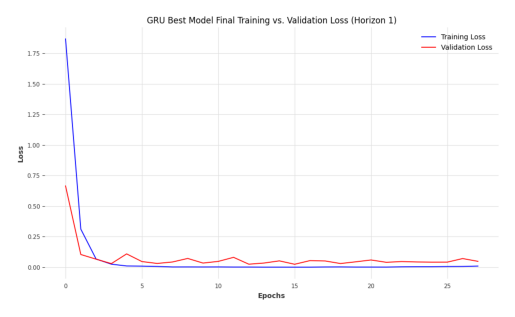

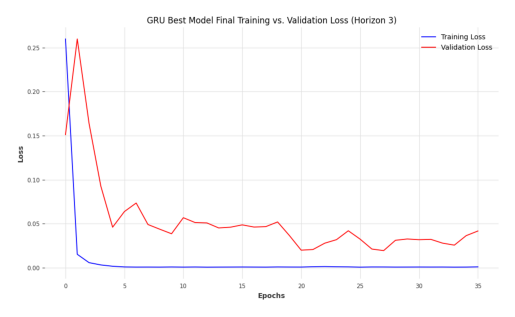

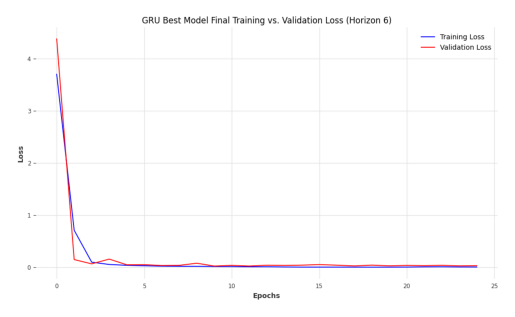

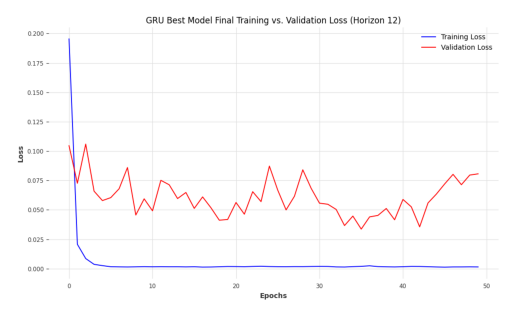

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path

# Paths to the saved plot images for each horizon (for GRU)
plot_paths = [
    Path(project_root) / "Plots" / "GRU" / "GRU_vs_Loss_H1_TRAIN.png",
    Path(project_root) / "Plots" / "GRU" / "GRU_vs_Loss_H3_TRAIN.png",
    Path(project_root) / "Plots" / "GRU" / "GRU_vs_Loss_H6_TRAIN.png",
    Path(project_root) / "Plots" / "GRU" / "GRU_vs_Loss_H12_TRAIN.png"
]

# Display each plot
for plot_path in plot_paths:
    img = mpimg.imread(plot_path)
    plt.imshow(img)
    plt.axis('off')  # Turn off axes for a cleaner look
    plt.show()


Evaluation Metrics (Test Set):

In [16]:
import numpy as np
import os
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

# === Set Project Root as a Path object ===
project_root = Path(os.path.abspath(os.path.join(os.getcwd(), "..", "..")))

# === Collect metrics for all horizons ===
results = []

for horizon in [1, 3, 6, 12]:
    pred_file = project_root / "Predictions" / f"Horizon{horizon}" / f"GRU1990_horizon_{horizon}.npy"
    
    if not pred_file.exists():
        print(f"Missing: {pred_file}")
        continue
    
    preds = np.load(pred_file)
    y_true, y_pred = preds[:, 0], preds[:, 1]

    # === Metrics ===
    rmse = mean_squared_error(y_true, y_pred)  # Get RMSE directly
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    results.append({
        "Horizon": horizon,
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2
    })

# === Display nicely ===
df_results = pd.DataFrame(results)
print("\nGRU Evaluation Metrics (Test Set):")
print(df_results.to_string(index=False))



GRU Evaluation Metrics (Test Set):
 Horizon     RMSE      MAE       R²
       1 6.177290 1.786180 0.875366
       3 0.143931 0.301494 0.996942
       6 0.143583 0.301053 0.996602
      12 0.142245 0.296560 0.995569


RMSE and Saving Predictions & Main Execution Function

In [17]:
import os

# Function to load the model with error handling
def load_model(model_save_path, model_invariates, best_model_params, device, model_name):
    best_model_path = os.path.join(model_save_path, f"{model_name}_best.pth")
    
    # Check if the model file exists before loading it
    if not os.path.exists(best_model_path):
        print(f"Model file not found: {best_model_path}")
        return None  # Return None if model file does not exist
    
    model = GRUModel(**model_invariates, **best_model_params).to(device)
    
    # Try loading the model with strict=False to allow shape mismatches
    model.load_state_dict(torch.load(best_model_path), strict=False)
    
    model.eval()
    return model


In [18]:
# Function to trim the last N values of predictions and save the file
def trim_and_save_predictions(predictions_path, n_trim=48):
    gru_preds = np.load(predictions_path)
    gru_preds_trimmed = gru_preds[-n_trim:]
    np.save(predictions_path, gru_preds_trimmed)
    print(f"Trimmed GRU_exog.npy to {len(gru_preds_trimmed)} values and saved.")

# Main execution function for predictions
def main(model_save_path, model_invariates, best_model_params, val_loader, scaler, device, project_root):
    model = load_model(model_save_path, model_invariates, best_model_params, device, f"GRU_exog_Optuna_H{horizon}")

    y_pred_original, y_val_original = make_evaluation_predictions(
    model, val_loader, device=device, y_scaler=scaler, y_scaler_features=['y']
    )

    # --- Debug check ---
    print(f"Preds shape: {y_pred_original.shape}, Labels shape: {y_val_original.shape}")

    # --- Align shapes if necessary ---
    min_len = min(len(y_val_original), len(y_pred_original))
    y_val_original = y_val_original[:min_len]
    y_pred_original = y_pred_original[:min_len]


    metrics = calc_metrics_arrays(y_val_original, y_pred_original, model_names=['GRU_exog'])
    print('Metrics on validation predictions:')
    display(metrics)

    pred_save_path = os.path.join(project_root, "Predictions", "GRU.npy")
    np.save(pred_save_path, y_pred_original)


# Assuming these variables are already defined: model_save_path, best_params, val_loader, scaler, feature_cols, device, project_root
main(model_save_path, model_invariates, best_model_params, val_loader, scaler, device, project_root)

Preds shape: (900,), Labels shape: (900,)
Metrics on validation predictions:


,RMSE,MAE,r2
GRU_exog,4.453568,3.066825,0.526561


Plots: Forecast vs Actual PCE (Horizon 1, 3, 6, 12)

In [19]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_gru_vs_actual(y_true, y_pred, title="GRU vs Actual PCE", time_index=None, save_path=None, smoothing_window=6):
    """
    Plot actual vs predicted PCE with optional smoothing and save.
    """
    plt.figure(figsize=(14, 6))

    # Convert to Series for smoothing
    y_true_series = pd.Series(y_true, index=time_index).rolling(window=smoothing_window, center=True, min_periods=1).mean()
    y_pred_series = pd.Series(y_pred, index=time_index).rolling(window=smoothing_window, center=True, min_periods=1).mean()

    # Plot
    plt.plot(time_index, y_true_series, label='Actual PCE (Smoothed)', color='black', linewidth=2, alpha=0.8)
    plt.plot(time_index, y_pred_series, label='GRU Prediction (Smoothed)', color='skyblue', linewidth=2, linestyle='--', alpha=0.8)

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("PCE")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
        print(f"Saved plot to: {save_path}")
    else:
        plt.show()

# ==== TRAINING VISUALIZATION PER HORIZON ====
def plot_train_forecasts_per_horizon(project_root, feature_cols):
    train_file = Path(project_root) / "Data" / "Train" / "train1990s.csv"
    df = pd.read_csv(train_file)
    df['ds'] = pd.to_datetime(df['observation_date'], format='%m/%Y')
    pce_train_series = df.set_index('ds')['fred_PCEPI']

    for horizon in [1, 3, 6, 12]:
        path = Path(project_root) / "Predictions" / f"Horizon{horizon}" / f"GRU1990_horizon_{horizon}.npy"
        if not path.exists():
            print(f"Missing prediction file: {path}")
            continue

        preds = np.load(path)
        half = preds.shape[1] // 2
        if preds.shape[1] % 2 != 0:
            print(f"Unexpected shape: {preds.shape}. Trimming extra columns.")
            preds = preds[:, :half*2]  # Trim to even number of columns
        y_true, y_pred = preds[:, :half], preds[:, half:]


        # Use just the first step from each
        y_true_first = y_true[:, 0] if y_true.ndim > 1 else y_true
        y_pred_first = y_pred[:, 0] if y_pred.ndim > 1 else y_pred

        if preds.shape[1] != 2 * horizon:
            print(f"Unexpected number of columns in predictions for horizon {horizon}: {preds.shape[1]}")
            continue  # Skip and handle differently if necessary



        # Only use the first step of the true and predicted values
        y_true, y_pred = preds[:, 0], preds[:, horizon]  # horizon-th col is first predicted step
        n = len(y_true)
        time_index = pce_train_series.index[-n:]

        save_path = Path(project_root) / "Plots" / "GRU" / f"GRU_vs_PCE_H{horizon}_TRAIN.png"
        plot_gru_vs_actual(y_true, y_pred, f"GRU Forecast vs Actual PCE (Horizon {horizon})", time_index, save_path)


        print(f"y_val_orig shape: {y_val_orig.shape}, y_pred_orig shape: {y_pred_orig.shape}")


Saved plot to: c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Plots\GRU\GRU_vs_PCE_H1_TRAIN.png
y_val_orig shape: (75, 12), y_pred_orig shape: (75, 12)
Saved plot to: c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Plots\GRU\GRU_vs_PCE_H3_TRAIN.png
y_val_orig shape: (75, 12), y_pred_orig shape: (75, 12)
Saved plot to: c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Plots\GRU\GRU_vs_PCE_H6_TRAIN.png
y_val_orig shape: (75, 12), y_pred_orig shape: (75, 12)
Saved plot to: c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Plots\GRU\GRU_vs_PCE_H12_TRAIN.png
y_val_orig shape: (75, 12), y_pred_orig shape: (75, 12)


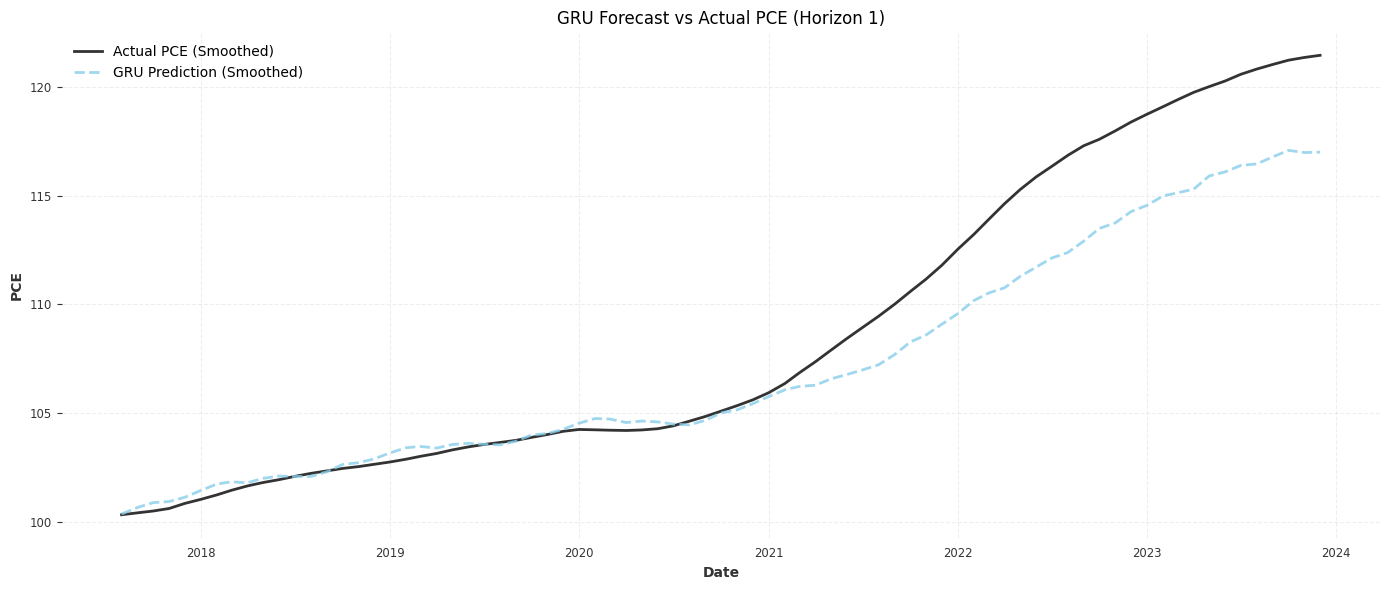

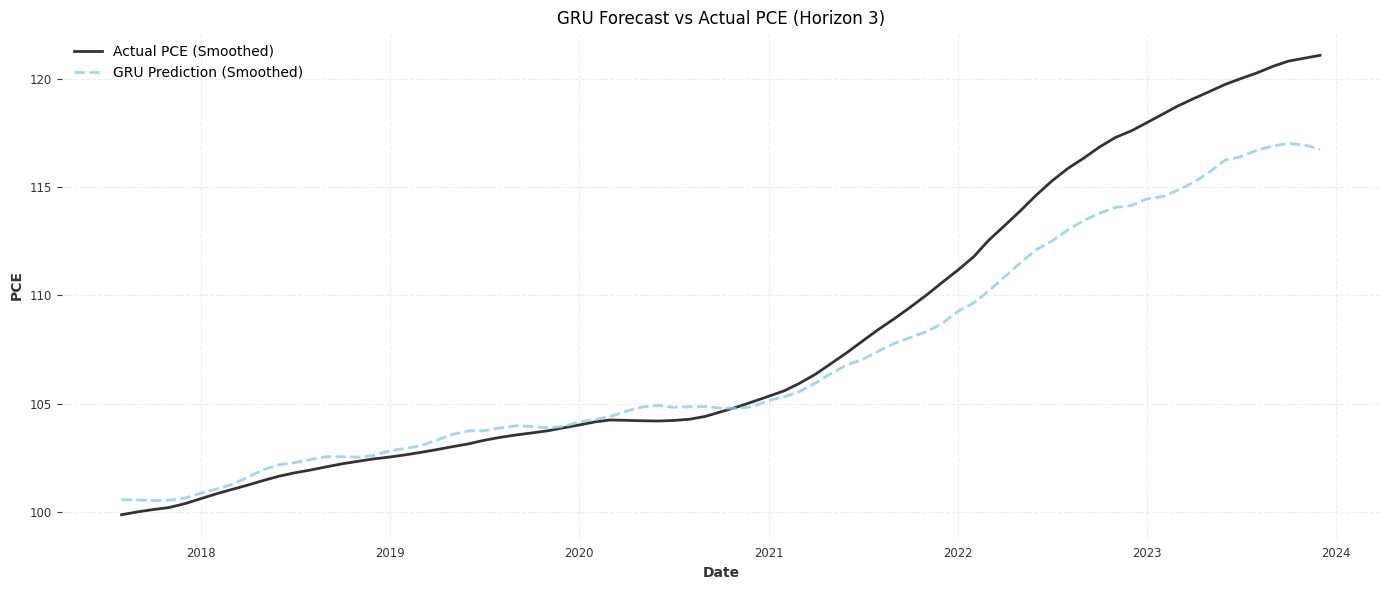

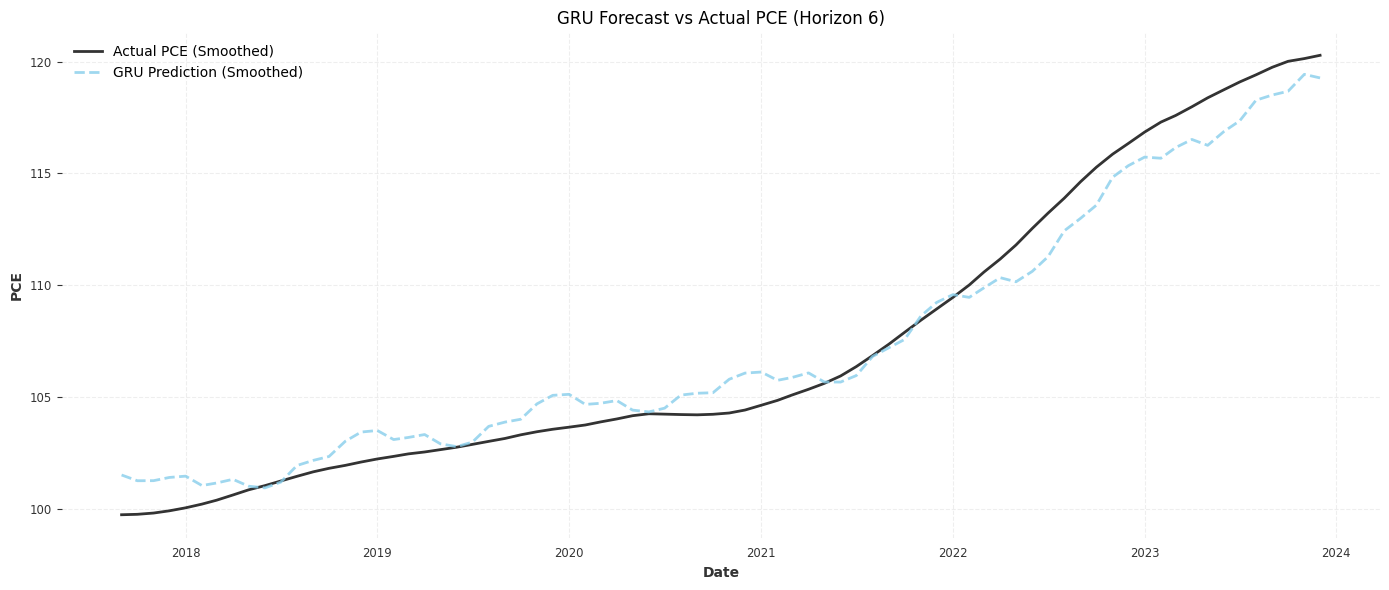

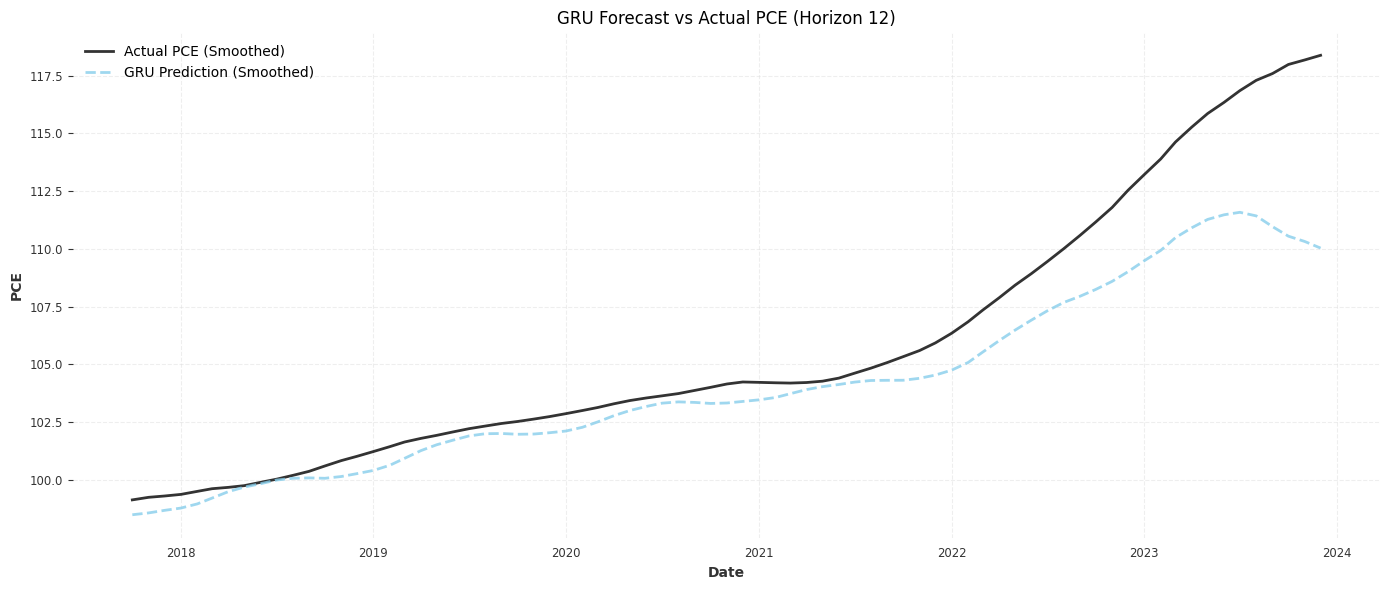

In [20]:
# Now you can call the plotting functions
plot_train_forecasts_per_horizon(project_root, feature_cols)